# 원티드 프리온보딩 3주차 - 모두의 주차장

### 디지털 스킬셋 기술과제

주제
- 	앱 이용자 별 향후 이용 건수 예측

Value chain상 정의
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용

모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측

### Data 정의

Input: Tabular 데이터
- 	2020.01.01 ~ 2020.12-31 

Output: Regression (향후 이용 건수 예측)

Task 정의
- 	Regression, 유저 별 한 달 후 이용 건수 예측

Metric 정의
- 	MSE, MAE

데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터



In [ ]:
!pip install pycaret

     |████████████████████████████████| 264 kB 4.3 MB/s 
     |████████████████████████████████| 248 kB 37.8 MB/s 
     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 2.0 MB 28.0 MB/s 
     |████████████████████████████████| 108 kB 41.7 MB/s 
     |████████████████████████████████| 14.4 MB 62 kB/s 
     |████████████████████████████████| 167 kB 44.5 MB/s 
     |████████████████████████████████| 6.8 MB 40.2 MB/s 
     |████████████████████████████████| 271 kB 34.3 MB/s 
     |████████████████████████████████| 1.7 MB 37.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 675 kB 51.1 MB/s 
     |████████████████████████████████| 10.1 MB 32.0 MB/s 
     |██████████████████

라이브러리 임포트

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### 라이브러리 임포트
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib as mpl



plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    font = fm.FontProperties(fname=fontpath, size=10)
    fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

데이터 불러오기

In [ ]:
### 데이터 불러오기
# C:\Users\Bonghwan\Downloads\week3\modu
#/content/drive/MyDrive/Colab Notebooks/data/modu/2020교통량통합.xlsx
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/modu/실전db.csv')
traffic = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/modu/2020교통량통합.xlsx')
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/modu/서울시_기상데이터.csv', encoding='cp949')

df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


### 각 데이터 확인

- 유저 정보
1. USER_ID : 유저별 ID 
2. JOIN_DATE : 유저별 가입일

- 결제 정보
1. D_TYPE :
2. STORE_ID : 점포별 ID
3. GOODS_TYPE : 상품 타입(주차권 종류)
4. COUNT : 결제건수 ( LABEL )
5. AD1 : 주소

- 추가 정보
1. 서울시 지점별 교통량 데이터
2. 기상데이터



In [ ]:
##컬럼별 데이터 확인
len(df['USER_ID'].unique()) # USER_ID : 165425 개
type(df['JOIN_DATE'].unique()[0]) # 가입일 : str

type(df['D_TYPE'][0]) # d_type : AA, BB, CC 그룹 분류, str
len(df['STORE_ID'].unique()) ## 1061 점포 갯수
df['GOODS_TYPE'].unique() ## 상품 타입(?) A, B, C, D 그룹 분류, str
type(df['DATE'][0]) # 날짜 : str
len(df['COUNT'].unique()) ## count : 61 개
len(df['AD1'].unique()) ## 85개

85

DATE & JOIN_DATE 데이터 타입 변경

In [ ]:
from datetime import datetime
df['DATE']=df['DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df['JOIN_DATE']=df['JOIN_DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
df['day']=df['DATE'].dt.dayofweek
df['month']=df['DATE'].dt.month
df['week']=df['DATE'].dt.week

### 고객 등급
- 고객별 결제 건수를 통해 고객 등급을 나눔

- 아래와 같이 가정 


In [ ]:
df.groupby('USER_ID')['COUNT'].sum() # len165425

USER_ID
224         2
232        24
342         1
565         2
729         1
           ..
1830551     1
1830570     1
1830580     1
1830589     1
1830598     1
Name: COUNT, Length: 165425, dtype: int64

In [ ]:
user_count_sum = df.groupby('USER_ID')['COUNT'].sum().reset_index().sort_values('COUNT', ascending = False)

In [ ]:
user_count_sum['COUNT'].describe()

count    165425.000000
mean          5.469784
std          22.823610
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7919.000000
Name: COUNT, dtype: float64

#### 고객 등급 나누기 전, 기준 보기

In [ ]:
# 처음 이용 고객(COUNT=1)
new_user = user_count_sum.loc[user_count_sum['COUNT']==1].count()
new_user

USER_ID    73947
COUNT      73947
dtype: int64

In [ ]:
# 실버고객(COUNT=2~4)
silver_user = user_count_sum.loc[user_count_sum['COUNT']>1]
silver_user.describe()

,USER_ID,COUNT
count,9.147800e+04,91478.000000
mean,1.220464e+06,9.082971
std,4.322625e+05,30.212644
min,2.240000e+02,2.000000
25%,9.040532e+05,2.000000
50%,1.343640e+06,4.000000
75%,1.571649e+06,9.000000
max,1.830491e+06,7919.000000


In [ ]:
# 골드고객(COUNT=5~18)
gold_user = user_count_sum.loc[user_count_sum['COUNT']>=5]
gold_user.describe()

,USER_ID,COUNT
count,4.084900e+04,40849.000000
mean,1.202377e+06,17.051360
std,4.259325e+05,43.917121
min,2.320000e+02,5.000000
25%,8.884810e+05,6.000000
50%,1.316468e+06,10.000000
75%,1.548143e+06,18.000000
max,1.826434e+06,7919.000000


In [ ]:
# VIP고객(COUNT=19~47)
vip_user = user_count_sum.loc[user_count_sum['COUNT']>=18]
vip_user.describe()

,USER_ID,COUNT
count,1.076200e+04,10762.000000
mean,1.198506e+06,40.742241
std,4.104179e+05,80.789425
min,2.320000e+02,18.000000
25%,9.030650e+05,22.000000
50%,1.314580e+06,30.000000
75%,1.527769e+06,47.000000
max,1.811081e+06,7919.000000


In [ ]:
# VVIP고객(COUNT=48~90)
vvip_user = user_count_sum.loc[user_count_sum['COUNT']>=48]
vvip_user.describe()

,USER_ID,COUNT
count,2.605000e+03,2605.000000
mean,1.171384e+06,81.368138
std,3.977281e+05,156.802573
min,7.973000e+03,48.000000
25%,8.798010e+05,56.000000
50%,1.281026e+06,68.000000
75%,1.508428e+06,90.000000
max,1.739610e+06,7919.000000


In [ ]:
# MVP고객(COUNT=91~)
mvp_user = user_count_sum.loc[user_count_sum['COUNT']>=91]
mvp_user.describe()

,USER_ID,COUNT
count,6.510000e+02,651.000000
mean,1.127322e+06,134.855607
std,3.798447e+05,307.027291
min,3.088200e+04,91.000000
25%,8.503255e+05,99.000000
50%,1.211118e+06,115.000000
75%,1.482670e+06,138.000000
max,1.690069e+06,7919.000000


총 165,424 유저 중

- new = 73947명
- silver = 50629명
- gold = 30087명
- vip = 8157명
- vvip = 1954명
- mvp = 650명

In [ ]:
# 고객 등급 컬럼 생성
grade_list = []

for c in user_count_sum['COUNT']:
    if c == 1:
        grade_list.append('new')
    elif 2 <= c < 5:
        grade_list.append('silver')
    elif 5 <= c < 19:
        grade_list.append('gold')
    elif 19 <= c < 48:
        grade_list.append('vip')
    elif 48 <= c < 91:
        grade_list.append('vvip')
    elif c >= 91:
        grade_list.append('mvp')
    else:
        print('not_our_customer')
        
user_count_sum['GRADE'] = grade_list

In [ ]:
user_count_sum.loc[user_count_sum['GRADE']=='vvip'].sort_values('COUNT',ascending=False)

,USER_ID,COUNT,GRADE
98832,1506437,90,vvip
68867,1286164,90,vvip
120713,1595426,90,vvip
86508,1444258,90,vvip
25983,743044,90,vvip
...,...,...,...
46231,1030767,48,vvip
128236,1625197,48,vvip
93610,1483357,48,vvip
99032,1507281,48,vvip


In [ ]:
user_count_sum = user_count_sum.rename({'COUNT':'COUNT_SUM'}, axis=1)
user_count_sum

,USER_ID,COUNT_SUM,GRADE
44115,999665,7919,mvp
100781,1514190,284,mvp
16448,591610,245,mvp
90227,1467323,239,mvp
76230,1355841,235,mvp
...,...,...,...
45671,1023974,1,new
110166,1551355,1,new
45674,1024027,1,new
45676,1024047,1,new


In [ ]:
# 주 데이터에 유저ID별_결제건수_합과 고객등급에 관한 컬럼 merge
df = pd.merge(df, user_count_sum, how='left', on='USER_ID')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2,1,1,1,new
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2,1,1,2,silver
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2,1,1,3,silver
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2,1,1,33,vip
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2,1,1,3,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,3,12,53,1,new
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,3,12,53,1,new
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,3,12,53,1,new
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,3,12,53,1,new


In [ ]:
df.groupby('D_TYPE')['COUNT'].value_counts()

D_TYPE  COUNT
AA      1        484275
        2          7801
        3           726
        4           183
        5            83
                  ...  
CC      53            1
        55            1
        58            1
        59            1
        61            1
Name: COUNT, Length: 88, dtype: int64

In [ ]:
## 가입일에 따른 유저수 파악
df.groupby('JOIN_DATE')['USER_ID'].value_counts()

JOIN_DATE   USER_ID
1970-01-01  654237     67
            1355917    52
            1477219    50
            1251357    41
            1163314    39
                       ..
2020-12-31  1830551     1
            1830570     1
            1830580     1
            1830589     1
            1830598     1
Name: USER_ID, Length: 165425, dtype: int64

In [ ]:
len(df[df['JOIN_DATE']<'1971']['USER_ID'].unique())
len(df.query('JOIN_DATE < 2000')['USER_ID'].unique())
len(df.USER_ID.unique())
len(df.JOIN_DATE.unique())

2352

USER_ID 별 JOIN_DATE 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


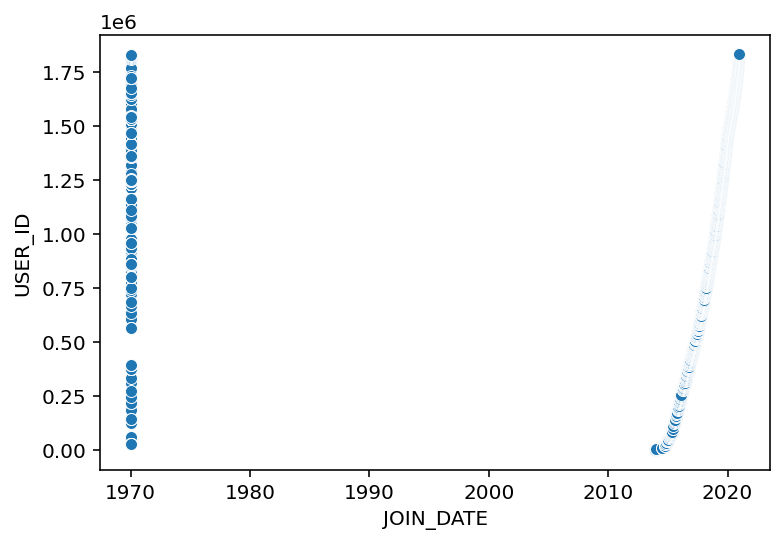

In [ ]:
sns.scatterplot(data=df, x='JOIN_DATE', y = 'USER_ID')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


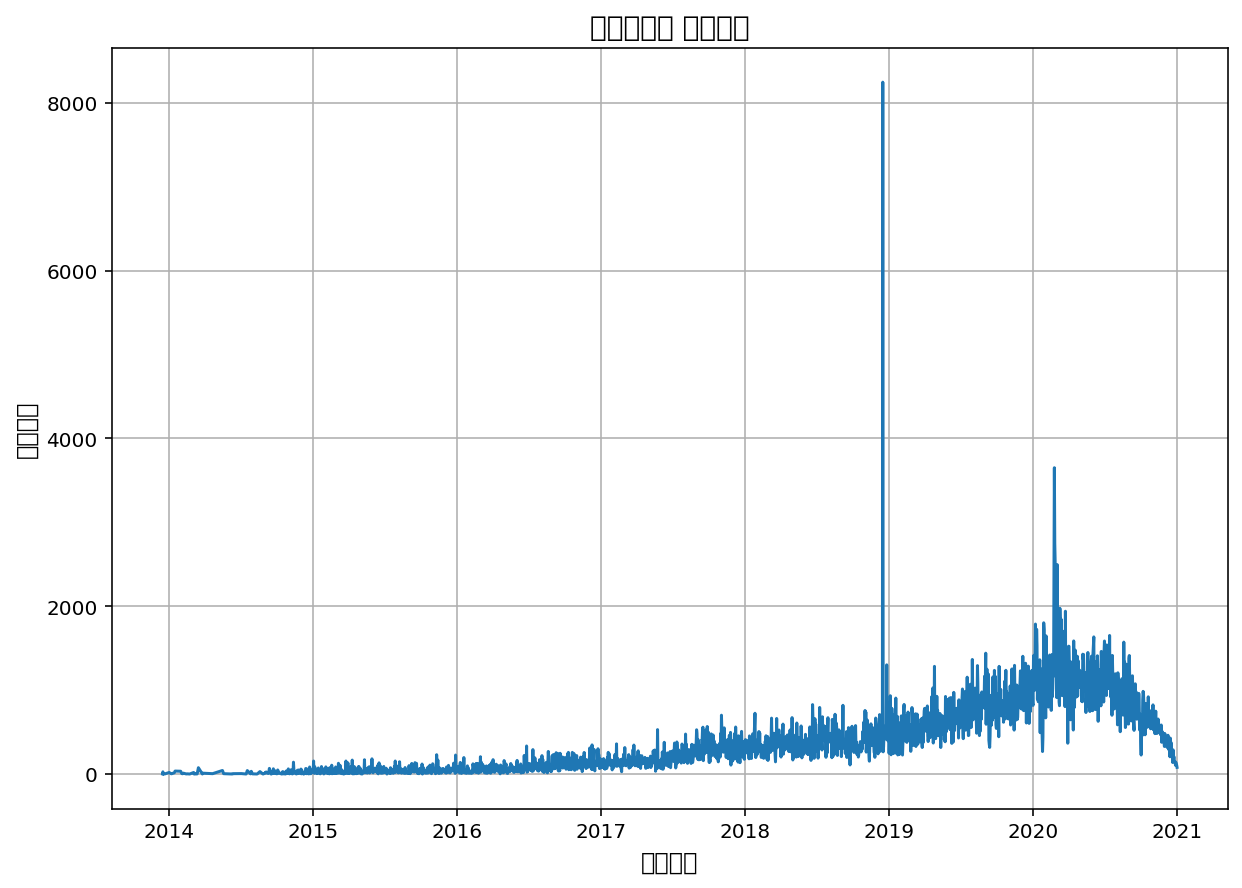

In [ ]:
# JOIN_DATE별 COUNT값(가입일 미상인 데이터는 제외) - 그래프를 위해
abn_list =df[df['JOIN_DATE'] < '1971']['USER_ID'].tolist()
normal_joindate_df = df[~df['USER_ID'].isin(abn_list)]

plt.figure(figsize=(10,7))
sns.lineplot(normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum().keys(),normal_joindate_df.groupby("JOIN_DATE")["COUNT"].sum())
plt.title('가입년도별 결제건수', fontsize=14)
plt.ylabel('결제건수', fontsize=12)
plt.xlabel('가입년도', fontsize=12)
plt.grid()
plt.show()

USER_ID는 JOIN_DATE가 1970년에 집중적, 그리고 2010년 중반 이후에 분포

- 2018년에 튀는 데이터는 999665

- 이상치로 처리하지 않은 이유
1. 가입일이 1970-01-01인 데이터는 결제일이 2020년에 집계되므로 가입일을 알 수 없는 고객 데이터일 것으로 추정
2. 결제건수로 향후 이용 건수를 예측한다면 가입일 미상인 데이터도 활용할 수 있을 것


In [ ]:
df.groupby(["USER_ID", "D_TYPE"])['JOIN_DATE'].count()

USER_ID  D_TYPE
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: JOIN_DATE, Length: 165425, dtype: int64

In [ ]:
## USER_ID 별 D_TYPE이 다른지 확인
from tqdm import tqdm

id_list = df["USER_ID"].unique().tolist()
for i in tqdm(id_list):
  # print(df[df['USER_ID']==i]["D_TYPE"])
  ch_list = df[df['USER_ID']==i]["D_TYPE"].tolist()
  for c in ch_list:
    
    if ch_list.count(c) != len(ch_list):
      # print(ch_list.count(c), len(ch_list))
      print('{}의 D_TYPE이 다름'.format(i))
    

100%|██████████| 165425/165425 [05:29<00:00, 502.72it/s]


### USER_ID별 D_TYPE은 동일한 것으로 보아, D_TYPE은 유저별 고정값으로 볼 수 있음


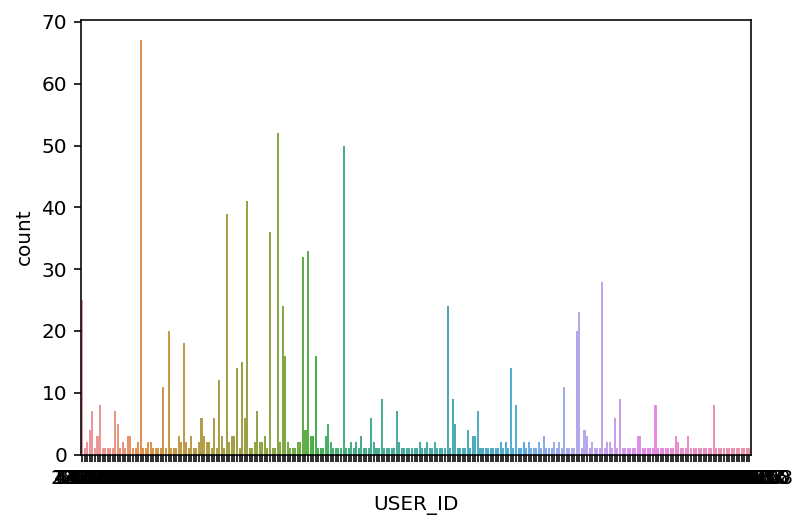

In [ ]:
sns.countplot(data=df[df["JOIN_DATE"]=='1970'], x='USER_ID')

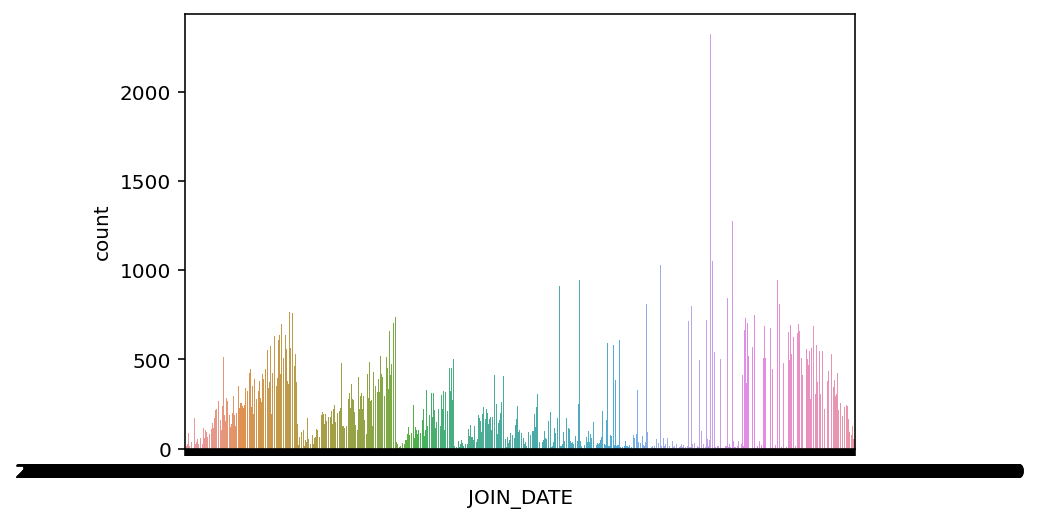

In [ ]:
sns.countplot(data=df.query('D_TYPE=="AA"'), x='JOIN_DATE')

In [ ]:
df[df['COUNT']==df['COUNT'].max()]
df[df['D_TYPE']=='AA']['COUNT'].max() # 23
df[df['D_TYPE']=='AA']['COUNT'].min() # 1
df[df['D_TYPE']=='BB']['COUNT'].max() # 19
df[df['D_TYPE']=='BB']['COUNT'].min() # 1
df[df['D_TYPE']=='CC']['COUNT'].max() # 61
df[df['D_TYPE']=='CC']['COUNT'].min() # 1

1

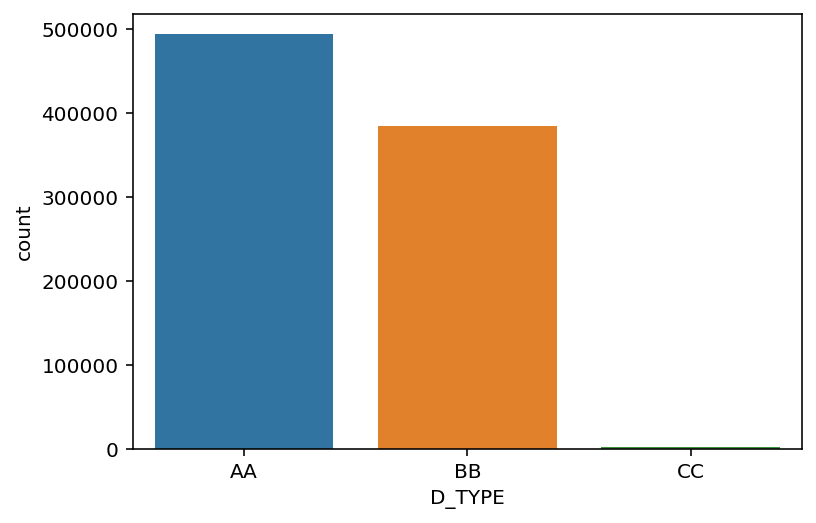

In [ ]:
sns.countplot(data=df, x='D_TYPE')

### D_TYPE은 
1. AA 그룹에서 1~23
2. BB 그룹에서 1~19
3. CC 그룹에서 1~61
의 범위를 가짐

C 그룹의 결제건수가 확연히 적음

In [ ]:
adf = df.query("D_TYPE == 'AA'")
bdf = df.query("D_TYPE == 'BB'")
cdf = df.query("D_TYPE == 'CC'")

In [ ]:
adf.query('GOODS_TYPE == "A"') # 345779 
adf.query('GOODS_TYPE == "B"') #  65966
adf.query('GOODS_TYPE == "C"') #  70010

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2,1,1,3,silver
14,88589,2015-05-18,AA,2334,C,2020-01-01,1,MP,2,1,1,1,new
16,118732,2015-07-03,AA,220690,C,2020-01-01,1,GN,2,1,1,1,new
20,138118,2015-08-09,AA,102276,C,2020-01-01,1,SC,2,1,1,8,gold
25,175466,2015-10-10,AA,82408,C,2020-01-01,1,GSN,2,1,1,5,gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879213,1829862,2020-12-31,AA,109877,C,2020-12-31,1,GN,3,12,53,1,new
879226,1829935,2020-12-31,AA,220893,C,2020-12-31,1,J,3,12,53,1,new
879231,1829962,2020-12-31,AA,220689,C,2020-12-31,1,GN,3,12,53,1,new
879236,1830033,2020-12-31,AA,109050,C,2020-12-31,1,GJ,3,12,53,1,new


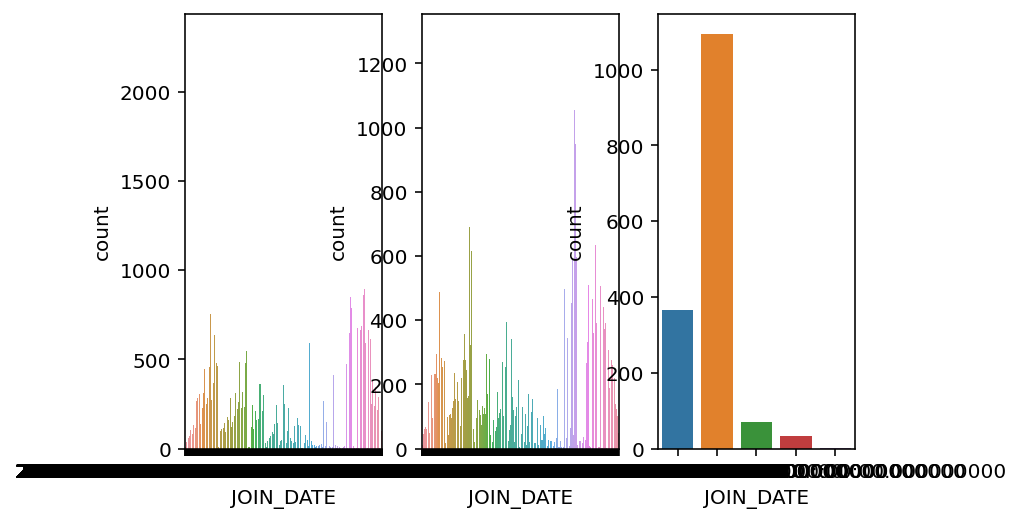

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1)
sns.countplot(data=adf, x='JOIN_DATE', ax=ax1)
sns.countplot(data=bdf, x='JOIN_DATE', ax=ax2)
sns.countplot(data=cdf, x='JOIN_DATE', ax=ax3)

D_TYPE이 CC 인 경우 JOIN_DATE가 특정일에 몰려있는 것을 볼 수 있음 
-> D_TYPE이 될 수 있는 데이터 가정
1. Driver_Type
2. 가입경로(개인, 소셜, 기업)
3. 결제수단


In [ ]:
adf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week,COUNT_SUM
count,4.931660e+05,493166.000000,493166.000000,493166.000000,493166.000000,493166.000000,493166.000000
mean,1.219591e+06,149413.979623,1.021920,2.865410,6.975572,29.003654,31.649566
std,4.139052e+05,68951.682792,0.197749,1.912934,3.347686,14.647331,39.145364
min,2.240000e+02,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,9.298790e+05,92305.000000,1.000000,1.000000,4.000000,17.000000,5.000000
50%,1.338080e+06,172934.000000,1.000000,3.000000,7.000000,30.000000,16.000000
75%,1.542206e+06,220661.000000,1.000000,4.000000,10.000000,42.000000,43.000000
max,1.830598e+06,231465.000000,23.000000,6.000000,12.000000,53.000000,284.000000


In [ ]:
bdf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week,COUNT_SUM
count,3.845410e+05,384541.000000,384541.000000,384541.000000,384541.000000,384541.000000,384541.000000
mean,1.189914e+06,149854.344278,1.018617,2.873649,7.018695,29.185551,31.162053
std,4.287848e+05,68840.134196,0.172946,1.917025,3.327902,14.554846,37.703861
min,2.320000e+02,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,8.638920e+05,92437.000000,1.000000,1.000000,4.000000,17.000000,5.000000
50%,1.297911e+06,173176.000000,1.000000,3.000000,7.000000,30.000000,16.000000
75%,1.542989e+06,220661.000000,1.000000,4.000000,10.000000,42.000000,43.000000
max,1.830589e+06,231465.000000,19.000000,6.000000,12.000000,53.000000,223.000000


In [ ]:
cdf.describe()

,USER_ID,STORE_ID,COUNT,day,month,week,COUNT_SUM
count,1.564000e+03,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,1.193629e+06,145698.795396,5.858696,2.843990,5.689258,23.342711,1872.765985
std,3.641901e+05,65876.144630,10.229165,1.882324,3.215941,13.953591,3343.064458
min,2.829200e+04,635.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,9.996650e+05,92437.000000,1.000000,1.000000,3.000000,12.000000,8.000000
50%,1.247912e+06,131081.000000,1.000000,3.000000,5.000000,22.000000,32.000000
75%,1.477219e+06,220655.000000,2.000000,4.000000,8.000000,34.000000,85.000000
max,1.829458e+06,231060.000000,61.000000,6.000000,12.000000,53.000000,7919.000000


- D_TYPE   
AA와 BB는 평균이나 표준 편차, MAX값에서도 큰 차이가 없음.  
CC의 경우 MAX값이나 표준 편차 평균에서도 큰 차이를 보임. 다만 표본 자체가 적은편

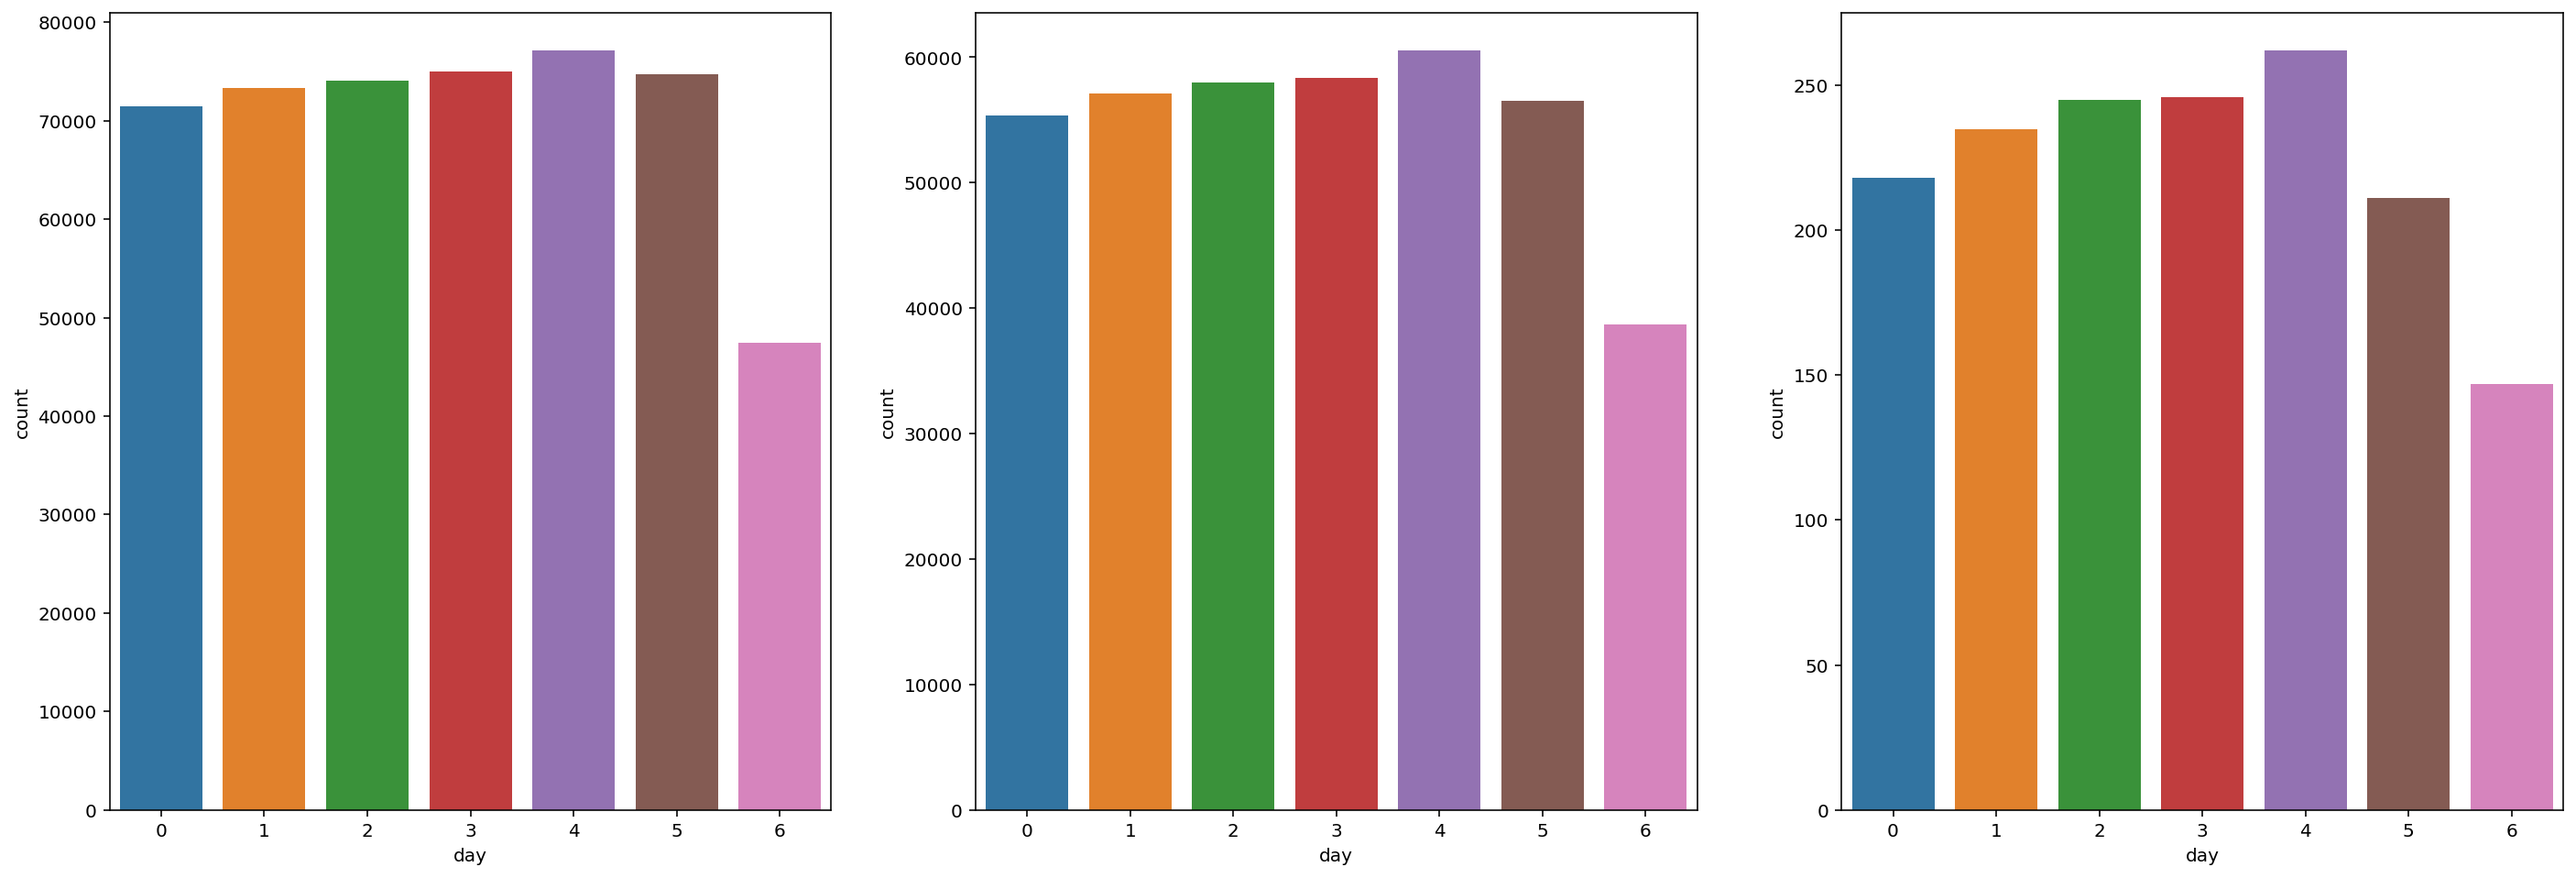

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="day", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="day", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="day", ax=ax3)

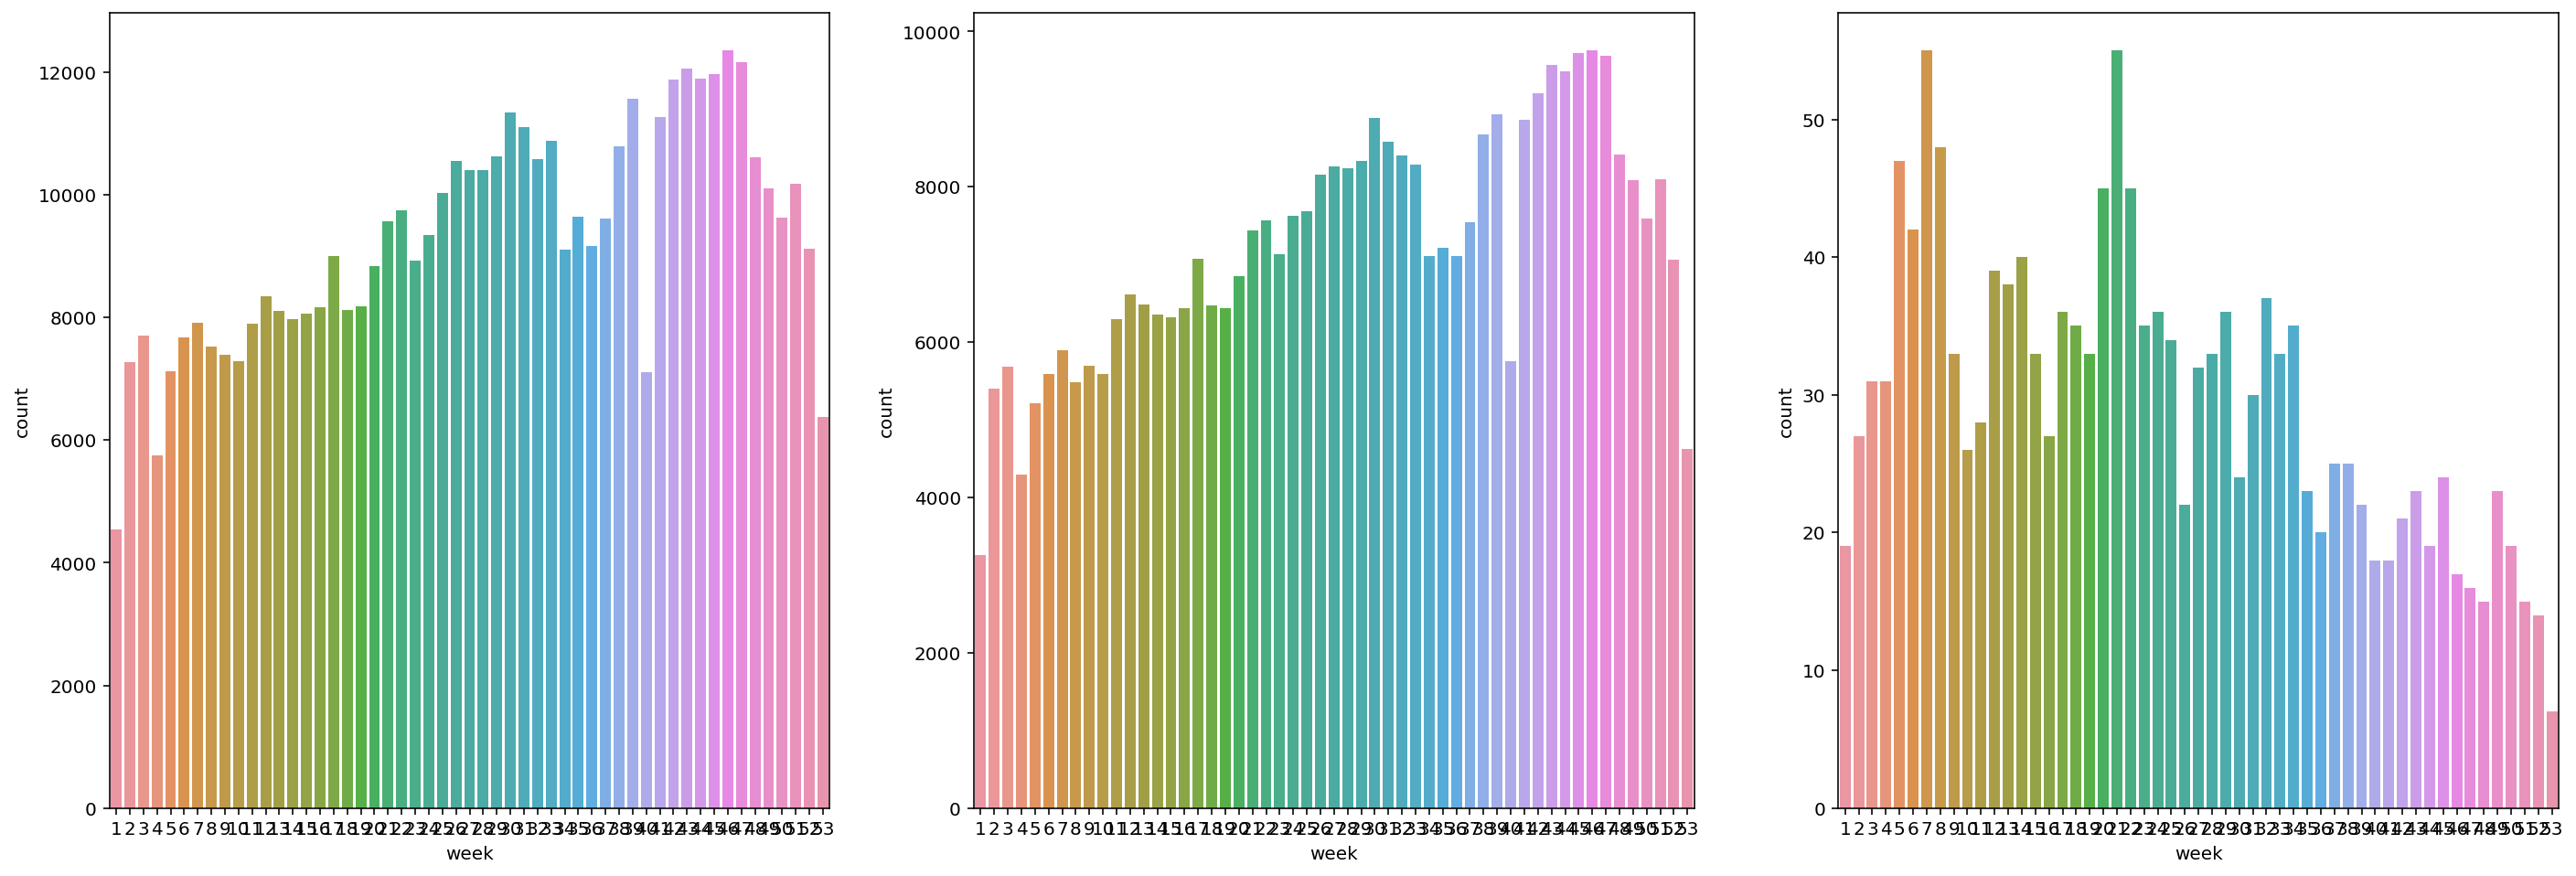

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="week", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="week", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="week", ax=ax3)


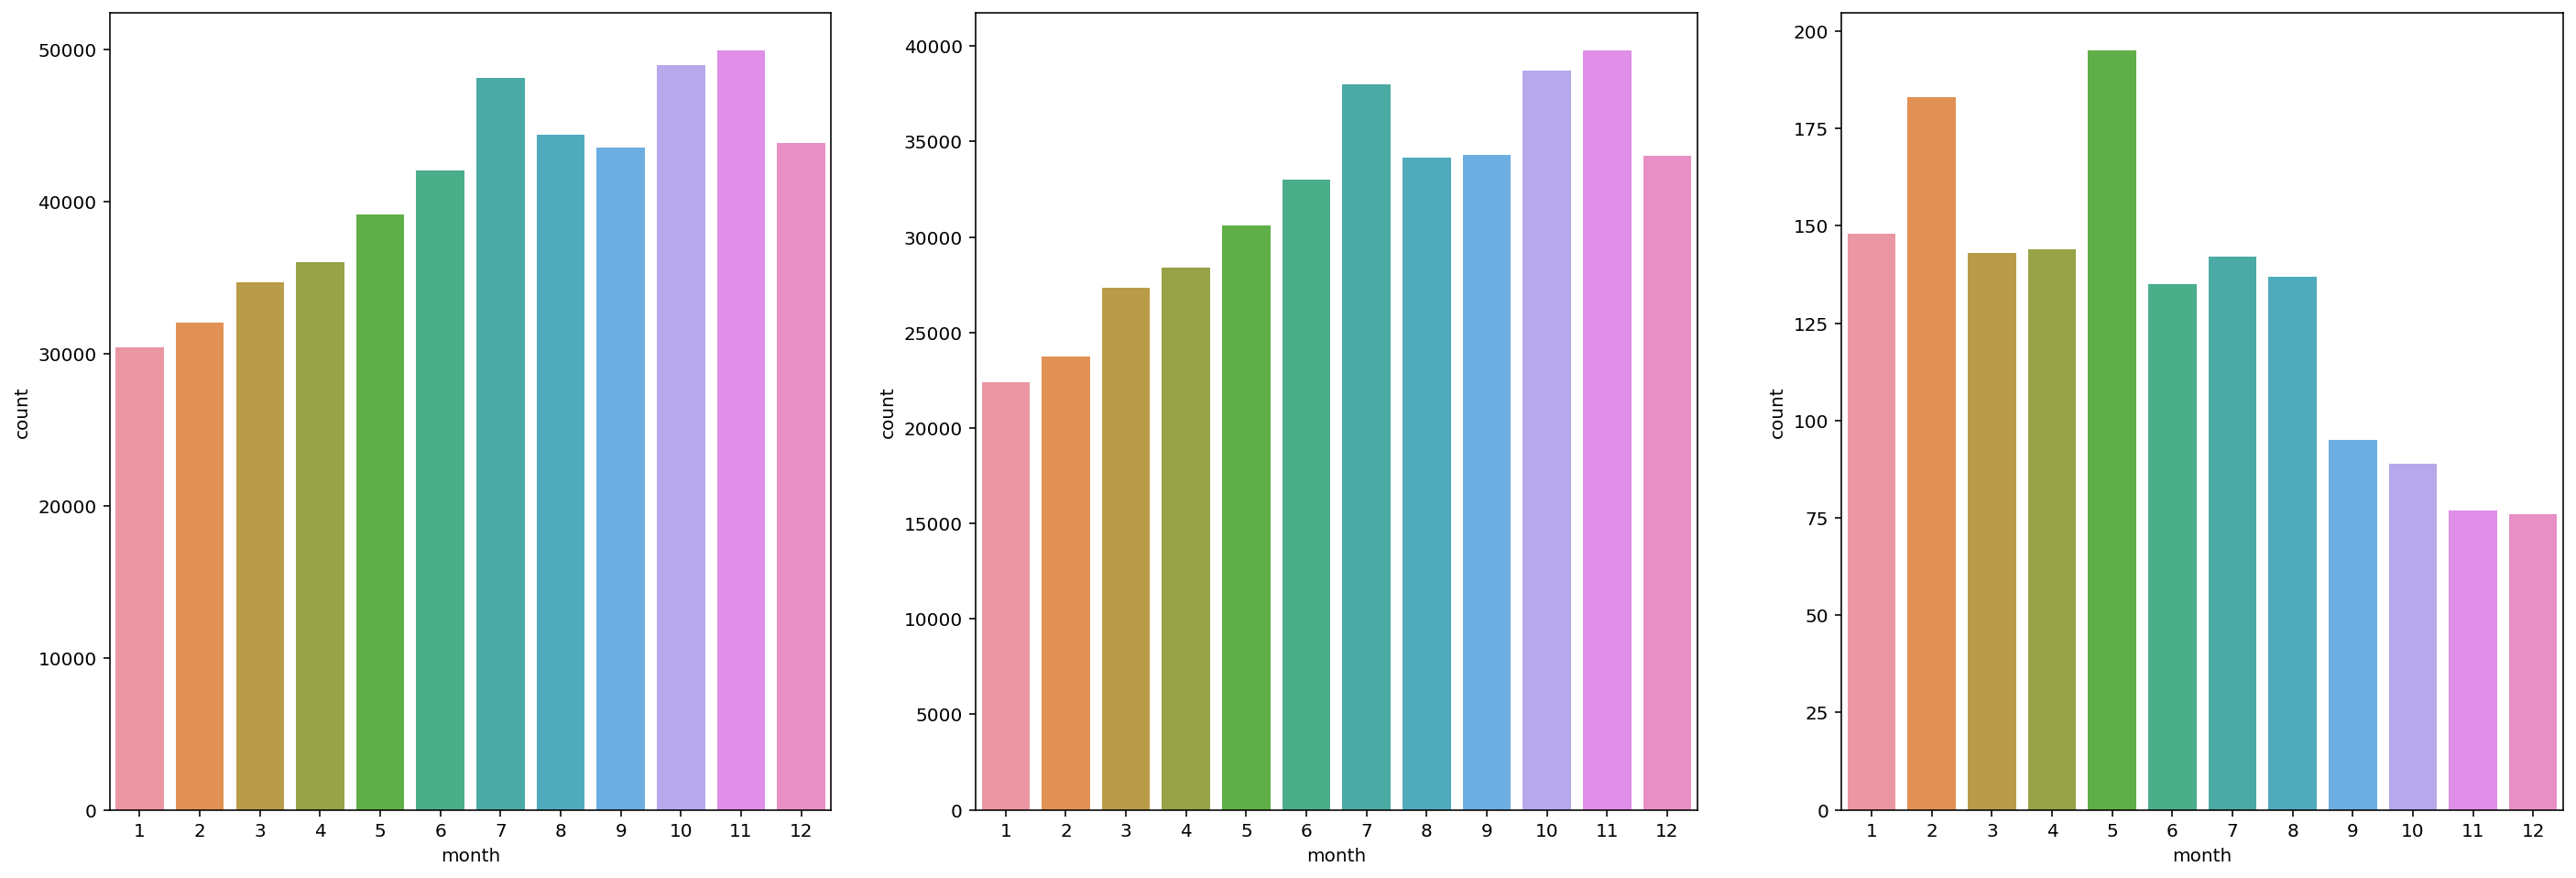

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('D_TYPE == "AA"'), x="month", ax=ax1)
sns.countplot(data=df.query('D_TYPE == "BB"'), x="month", ax=ax2)
sns.countplot(data=df.query('D_TYPE == "CC"'), x="month", ax=ax3)


D_TYPE 별 데이터를 
요일 별(day)로 볼 때는 특이점이 보이지 않지만,
주 차별(week)& 월별(month)로 볼 경우 CC 그룹의 경우 AA, BB그룹의 데이터와 달리 꾸준히 count 가 줄어드는 것을 볼 수 있다.


### GOODS_TYPE

1. A 그룹에서 1~61
2. B 그룹에서 1~23
3. C 그룹에서 1~49
4. D 그룹에서 1~40 의 범위를 가짐

A 그룹이 결제 건수가 압도적으로 높고, D 그룹의 결제 건수는 확연히 적음

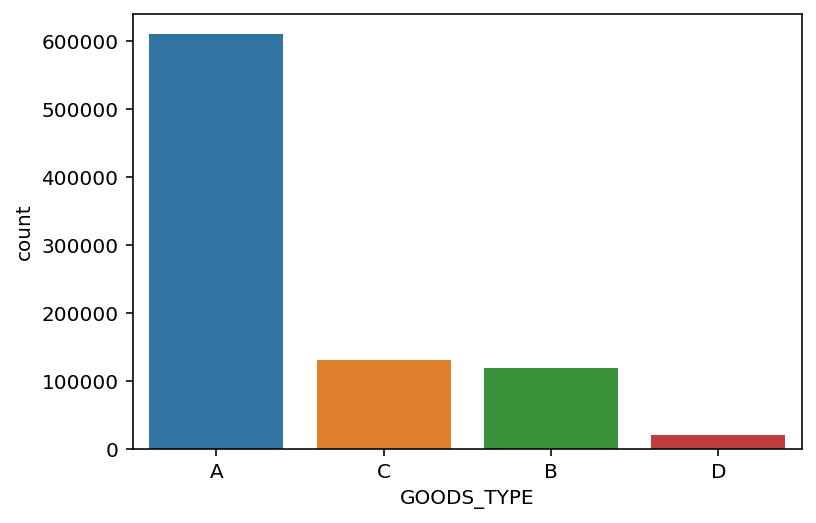

In [ ]:
sns.countplot(data=df, x='GOODS_TYPE')

### 주 별 GOODS_TYPE별 결제 건수

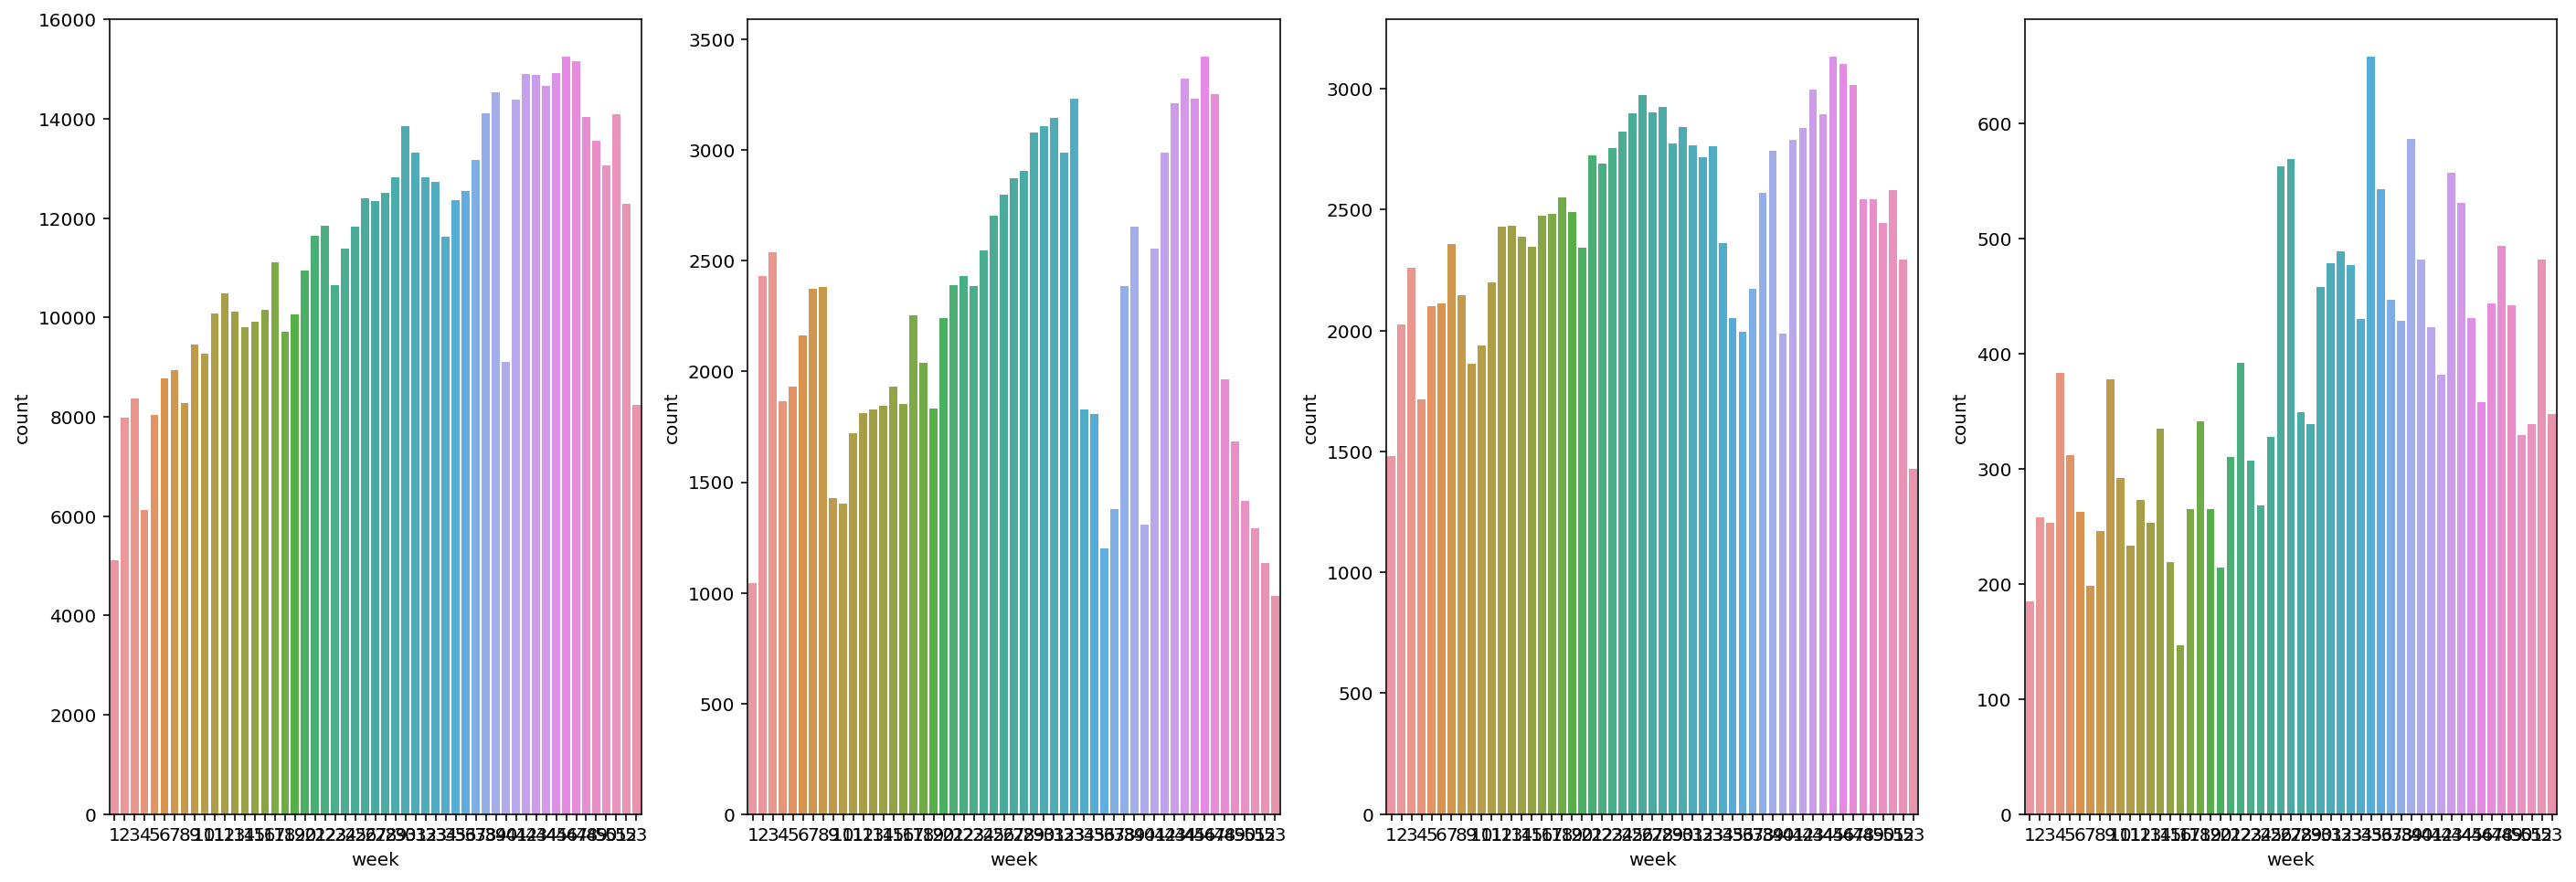

In [ ]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(24, 8)
sns.countplot(data=df.query('GOODS_TYPE == "A"'), x="week", ax=ax1)
sns.countplot(data=df.query('GOODS_TYPE == "B"'), x="week", ax=ax2)
sns.countplot(data=df.query('GOODS_TYPE == "C"'), x="week", ax=ax3)
sns.countplot(data=df.query('GOODS_TYPE == "D"'), x="week", ax=ax4)

GOODS_TYPE은 주 차별로 확인시
 A의 경우만 확연한 증가추세.


### STORE_ID별


<Figure size 1152x720 with 0 Axes>

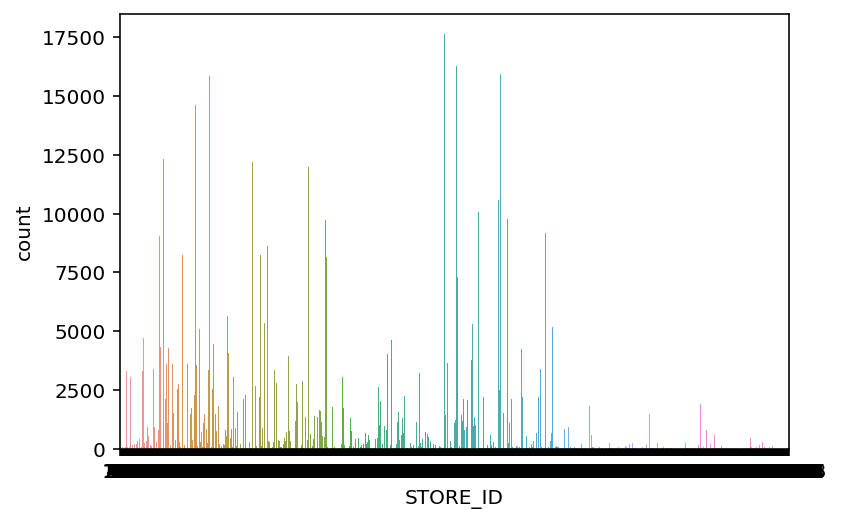

<Figure size 1152x720 with 0 Axes>

In [ ]:
sns.countplot(data=df, x='STORE_ID')
plt.figure(figsize=(16,10))

In [ ]:
sdf = pd.DataFrame(df.groupby('STORE_ID')['COUNT'].sum())
sdf.reset_index(level=[0], inplace=True)
sdf.sort_values('COUNT', ascending=False, inplace=True)
sdf

,STORE_ID,COUNT
514,220557,17854
612,220893,17653
533,220655,16815
142,92437,16495
603,220848,16298
...,...,...
931,230196,1
927,230190,1
464,220018,1
923,228955,1


STORE_ID별 결제 건수의 편차가 큼.

In [ ]:
df.groupby('USER_ID')['COUNT'].count().max()
df.query('COUNT == COUNT.max()')

## 이상치라고 생각되는 유저 
df[df['USER_ID'] == 999665]
# df[df['USER_ID'] == 999665]['COUNT'].sum()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2,1,1,7919,mvp
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,3,1,1,7919,mvp
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,4,1,1,7919,mvp
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,5,1,1,7919,mvp
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,6,1,1,7919,mvp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,6,12,52,7919,mvp
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,0,12,53,7919,mvp
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,1,12,53,7919,mvp
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2,12,53,7919,mvp


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879271 entries, 0 to 879270
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   D_TYPE      879271 non-null  object        
 3   STORE_ID    879271 non-null  int64         
 4   GOODS_TYPE  879271 non-null  object        
 5   DATE        879271 non-null  datetime64[ns]
 6   COUNT       879271 non-null  int64         
 7   AD1         879271 non-null  object        
 8   day         879271 non-null  int64         
 9   month       879271 non-null  int64         
 10  week        879271 non-null  int64         
 11  COUNT_SUM   879271 non-null  int64         
 12  GRADE       879271 non-null  object        
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 133.9+ MB


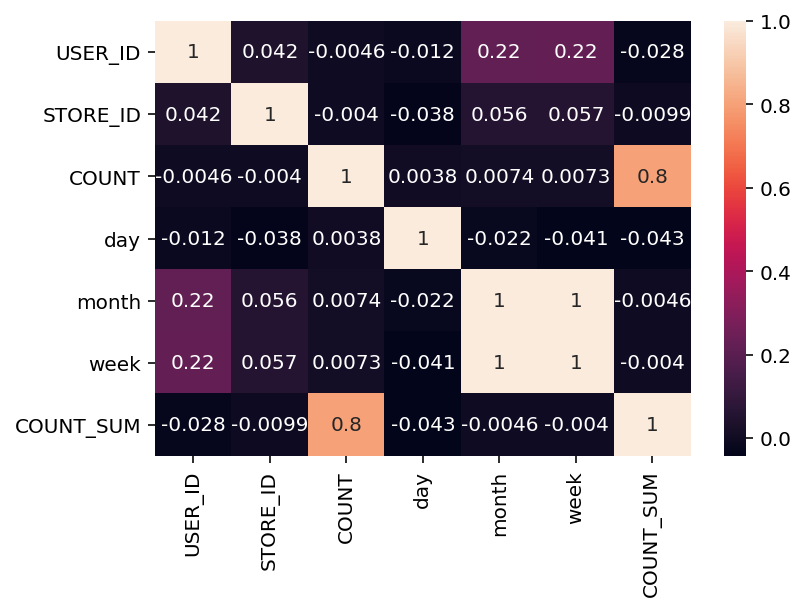

In [ ]:
sns.heatmap(df.corr(), annot=True)

### 2020 공휴일

날짜	요일	공휴일   
1월 1일	수요일	새해  
1월 24일 ~ 1월 26일	금요일 ~ 일요일	설날  
3월 1일	일요일	3·1 운동/삼일절  
4월 30일	목요일	부처님 오신 날  
5월 5일	화요일	어린이날  
6월 6일	토요일	현충일  
8월 15일	토요일	광복절  
8월 17일	월요일	광복절 휴일  
9월 30일 ~ 10월 2일	수요일 ~ 금요일	추석  
10월 3일	토요일	개천절  
10월 9일	금요일	한글날  
12월 25일	금요일	크리스마스  



In [ ]:
df.sort_values('COUNT', ascending=False, inplace=True)
# df.groupby("STORE_ID")['COUNT'].value_counts()

### 날짜별 분석


In [ ]:
df['day'] = [k for k in df['DATE'].dt.dayofweek] ## 요일 칼럼
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,7919,mvp
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,7919,mvp
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,7919,mvp
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,7919,mvp
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,7919,mvp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,47,vip
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,1,new
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,44,vip
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,7,gold


In [ ]:
df['is_weekend'] = df['day'].apply(lambda x: 1 if x > 4 else 0)
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE,is_weekend
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,7919,mvp,1
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,7919,mvp,0
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,7919,mvp,1
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,7919,mvp,0
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,7919,mvp,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,47,vip,0
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,1,new,0
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,44,vip,0
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,7,gold,0


### 공휴일 분류

In [ ]:
h_list = ['2020-01-01', '2020-01-24', '2020-01-25','2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15','2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']
hol_list =[]
for i in h_list:
  hol = datetime.date(datetime.strptime(i, '%Y-%m-%d'))
  # print(hol)
  hol_list.append(hol)
hol_list

[datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 8, 15),
 datetime.date(2020, 8, 17),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 10, 2),
 datetime.date(2020, 10, 3),
 datetime.date(2020, 10, 9),
 datetime.date(2020, 12, 25)]

In [ ]:
df['is_holiday'] = df['DATE'].apply(lambda x: 1 if x in hol_list else 0)

In [ ]:
df.query('is_holiday == 1')['COUNT'].sum()/df.query('is_holiday == 1')['COUNT'].count()

1.0331672248999264

In [ ]:
df.query('is_holiday == 0')['COUNT'].sum()/df.query('is_holiday == 0')['COUNT'].count()

1.0289615331970814

In [ ]:
df.query('day < 6 and is_holiday == 0')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].count()

1.226101431137252

In [ ]:
df.query('day <6 and is_holiday == 1')['COUNT'].sum()/df.query('day > 5 and is_holiday == 1')['COUNT'].count()

11.867414584395716

### 요일별 결제건수, 평일과 공휴일, 평일과 주말 데이터 시각화

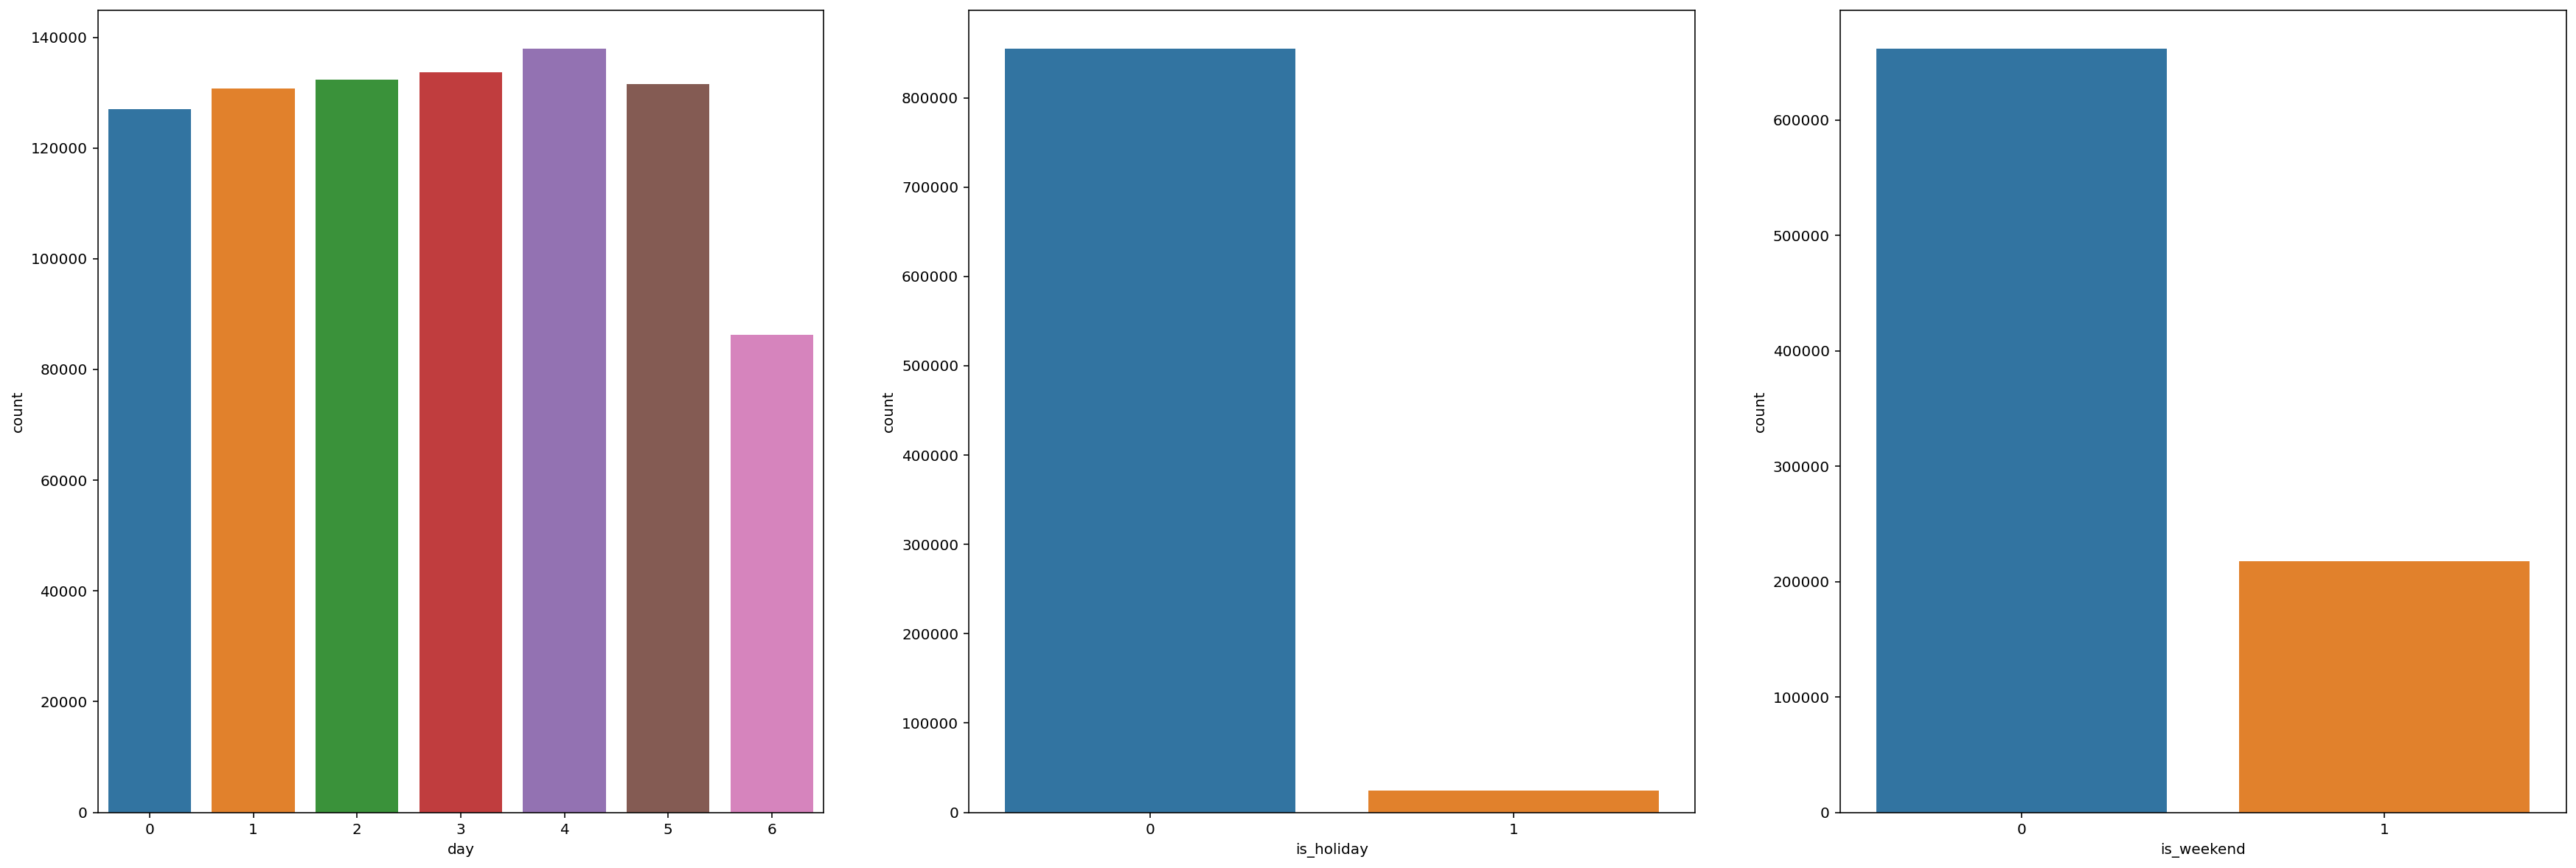

In [ ]:
df.groupby('day')['COUNT'].sum()
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 10)
# sns.barplot(data = df.groupby('day')['COUNT'].sum(), x = 'day')
sns.countplot(data=df, x='day', ax = ax1)
sns.countplot(data=df, x='is_holiday', ax = ax2)
sns.countplot(data=df, x='is_weekend', ax = ax3)

- 주말, 특히 일요일의 경우 결제 건수가 확연히 줄어드는 모습
- 주말인 경우와 공휴일의 경우 절대적인 날짜의 차이가 있기때문에, 차이를 볼 수 있지만, 날짜 대비 결제 건수는 주말과 공휴일에 늘어나는 것을 볼 수 있다.


### 요일별  각 상품 이용량 분석

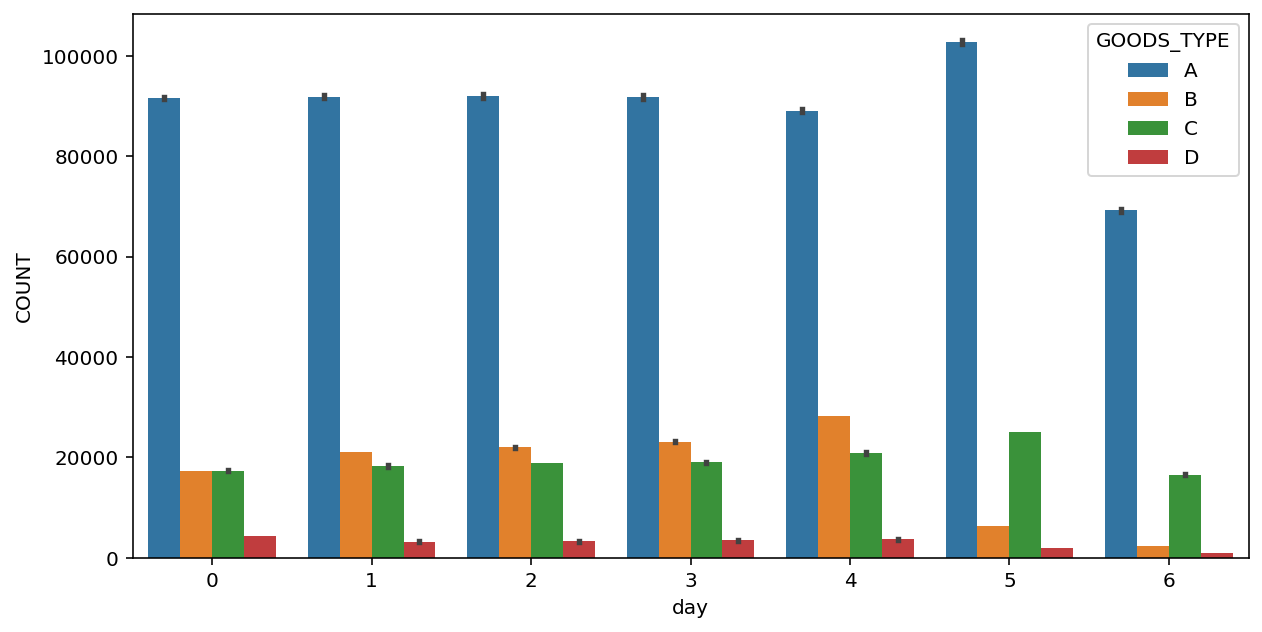

In [ ]:
# 요일별 goods_type별 결제 건수
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='day', y='COUNT',hue='GOODS_TYPE',
             hue_order=['A','B','C','D'], estimator=sum)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


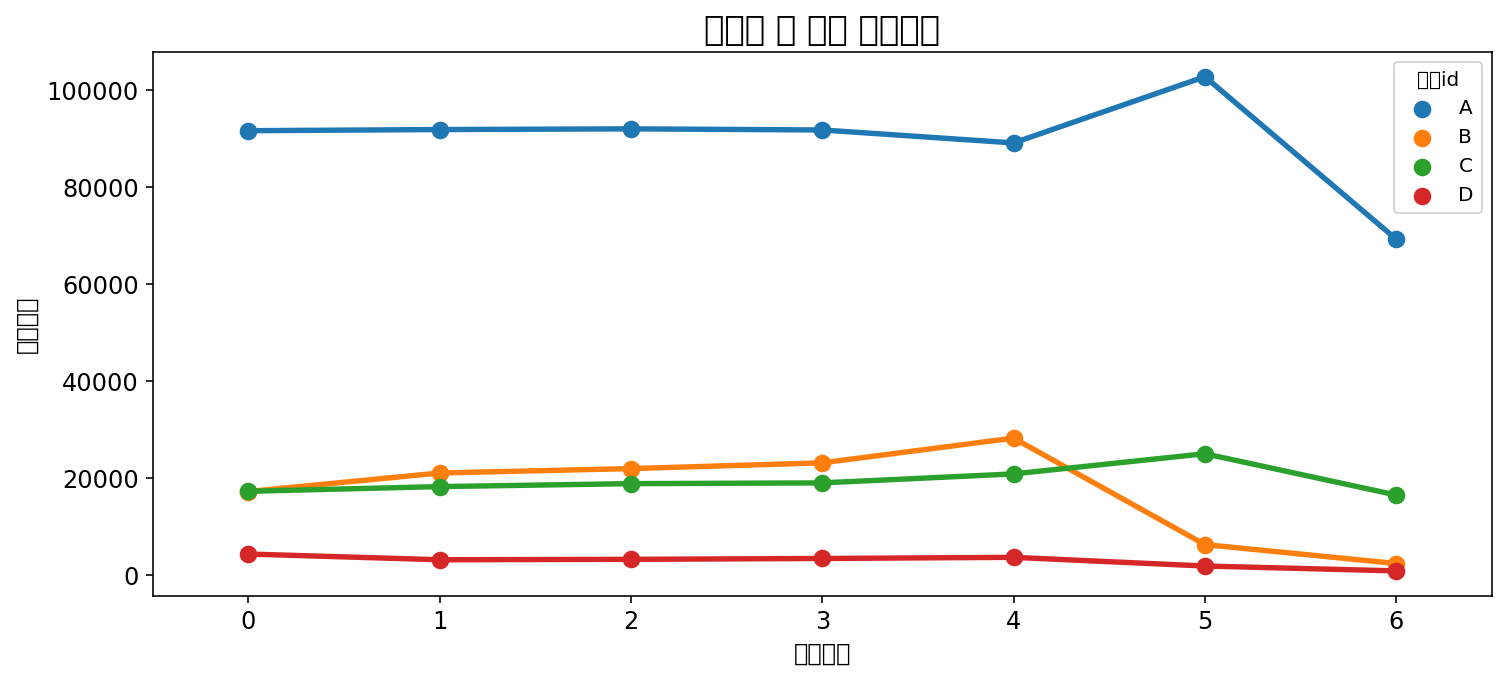

In [ ]:
#요일별 이용량 분석

df['DAY'] = df['DATE'].dt.weekday
counts_days = df.groupby(['DAY','GOODS_TYPE'])['COUNT'].sum().reset_index()
counts_days_df = counts_days[['DAY','GOODS_TYPE','COUNT']]
counts_days_df.columns = ['결제요일','상품id','결제건수']

fig, ax = plt.subplots(1,1, figsize = (12,5))
sns.pointplot(x = '결제요일', y = '결제건수', hue = '상품id', data = counts_days_df)
plt.title('요일별 각 상품 결제건수', fontsize = 17)
plt.xlabel('결제요일', fontsize = 12)
plt.ylabel('결제건수', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

### 요일별 상품 결제 건수에 대해서는 GOODS_TYPE 이 A일 때, 토요일에 결제건수가 평일 대비 높은 것을 볼 수 있다.
이를 통해 확인 할 수 있는 것은,
1. A의 결제건수가 가장 많으므로 시간권으로 예상할 수 있다.
2. B의 결제건수가 주말이 되면 크게 줄어들기 때문에 평일 당일권임을 추측할 수 있다.
3. C의 결제건수는 주말이 되면 오히려 증가하므로 휴일 당일권일 것으로 추측했다.
4. D의 결제건수는 가장 적고 주말에 감소하는 경향이 있어서 평일 심야권일 것으로 생각했다.

In [ ]:
df.query('GOODS_TYPE == "A" and day == 6')['COUNT'].sum()
df.loc[df['GOODS_TYPE']=='A'].groupby('day')["COUNT"].sum()

day
0     91607
1     91838
2     91987
3     91754
4     89083
5    102734
6     69250
Name: COUNT, dtype: int64

###  주 별, 월 별 결제 건수 시각화

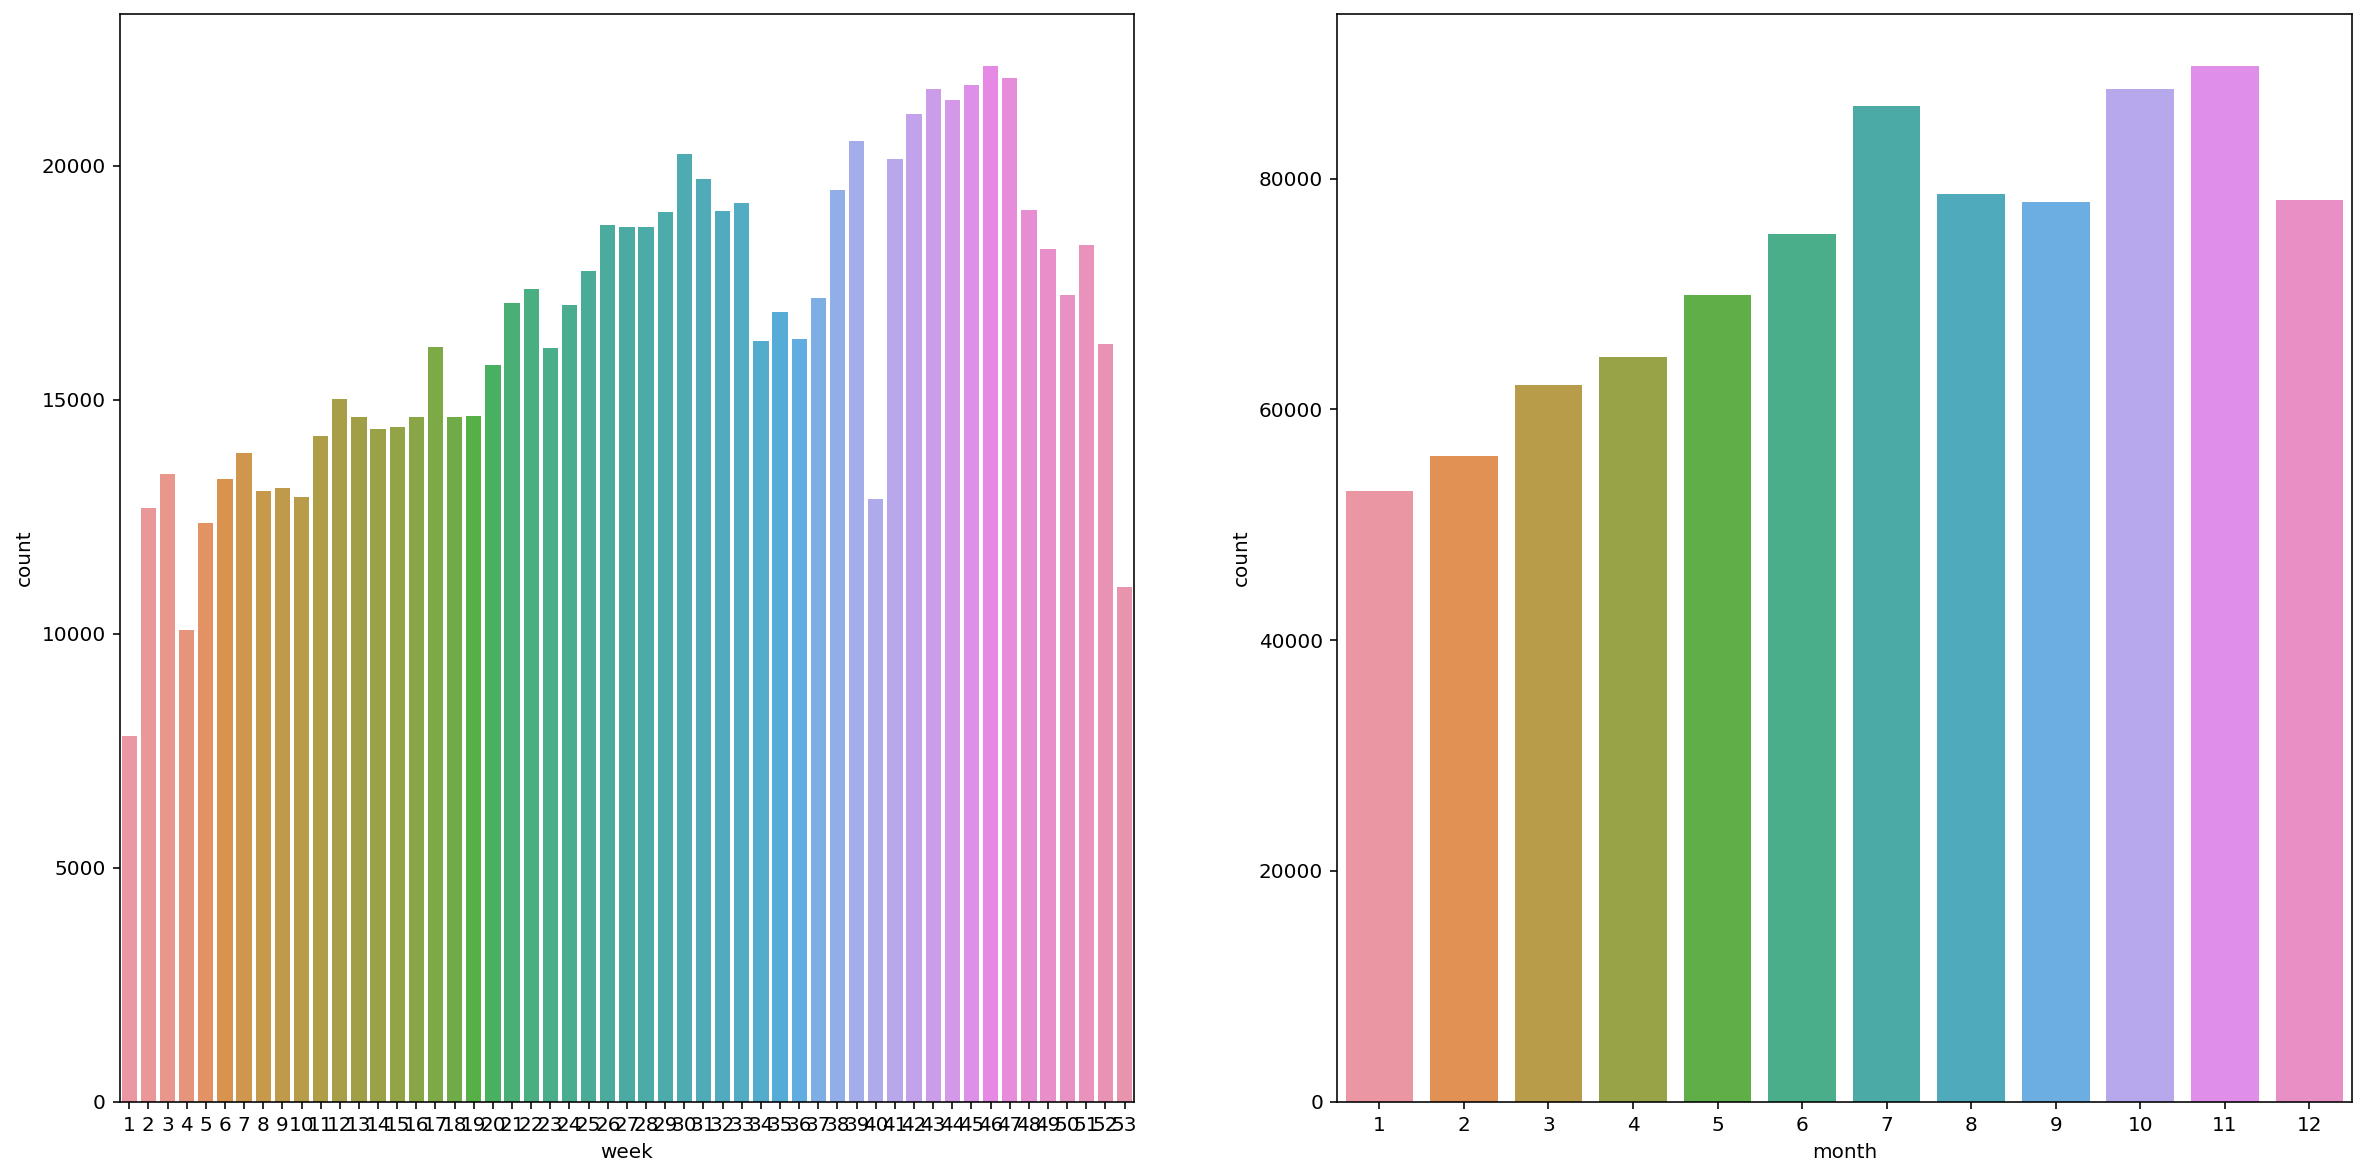

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,10)
sns.countplot(data=df, x='week', ax=ax1)
sns.countplot(data=df, x='month', ax=ax2)

### 주 별  상품 TYPE 별 결제 건수

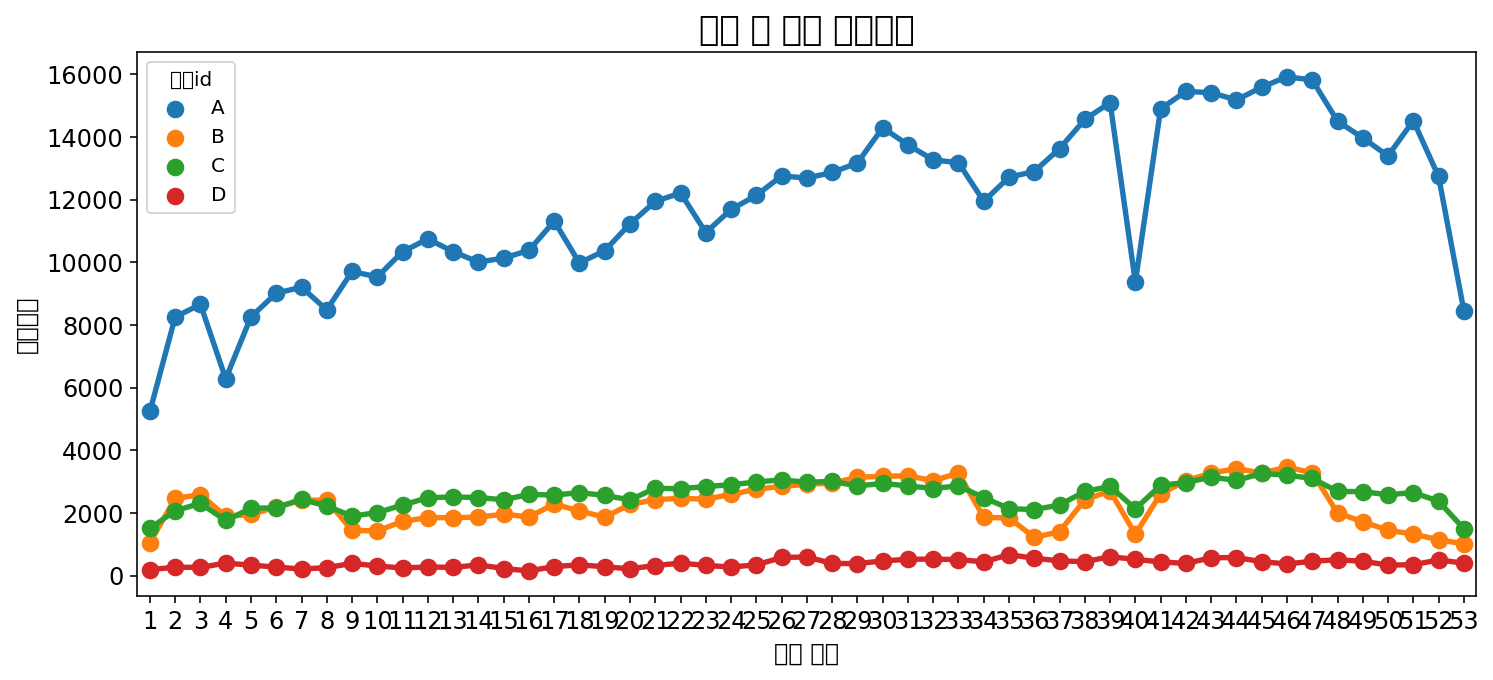

In [ ]:
df.loc[df['GOODS_TYPE']=='A'].groupby('week')["COUNT"].sum()

counts_days = df.groupby(['week','GOODS_TYPE'])['COUNT'].sum().reset_index()
counts_days_df = counts_days[['week','GOODS_TYPE','COUNT']]
counts_days_df.columns = ['주','상품id','결제건수']

fig, ax = plt.subplots(1,1, figsize = (12,5))
sns.pointplot(x = '주', y = '결제건수', hue = '상품id', data = counts_days_df)
plt.title('주별 각 상품 결제건수', fontsize = 17)
plt.xlabel('결제 주차', fontsize = 12)
plt.ylabel('결제건수', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

- 급격한 하락을 보이는 40번째 주와 34번째 주의 경우 각각 추석과, 광복절 대체연휴가 있는 주
- 연휴 또는 공휴일에는 대체로 결제건수가 줄어드는 모습을 볼 수 있음.

In [ ]:
df.query('week == 41')['COUNT'].sum() # 20816
df.query('week == 40')['COUNT'].sum() # 13329
df.query('week == 40') ## 추석이 있는 주
df.query('week == 34') ## 광복절, 대체연휴가 있는 주

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE,is_weekend,is_holiday,DAY
517910,999665,2018-12-16,CC,105274,C,2020-08-20,31,CY,3,8,34,7919,mvp,0,0,3
515223,999665,2018-12-16,CC,221018,A,2020-08-19,24,MP,2,8,34,7919,mvp,0,0,2
520614,999665,2018-12-16,CC,219891,A,2020-08-21,22,ZE,4,8,34,7919,mvp,0,0,4
512451,999665,2018-12-16,CC,90193,C,2020-08-18,22,GW,1,8,34,7919,mvp,0,0,1
510288,999665,2018-12-16,CC,220893,A,2020-08-17,21,J,0,8,34,7919,mvp,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517311,428194,2016-12-13,AA,109422,A,2020-08-20,1,J,3,8,34,19,vip,0,0,3
517312,428836,2016-12-14,AA,96266,A,2020-08-20,1,GN,3,8,34,125,mvp,0,0,3
517313,429225,2016-12-14,BB,109421,A,2020-08-20,1,J,3,8,34,40,vip,0,0,3
517314,431298,2016-12-18,AA,220848,B,2020-08-20,1,GN,3,8,34,24,vip,0,0,3


### 월별로 보면 주로 겨울에 비해 여름과 특히 가을에 사용량이 비교적 많은 편
### 주차별로 확인 할 경우, 연초와 연말 그리고 추석이 있는 주 차에서 이용량이 급감

In [ ]:
# def make_season(sent):
#     if sent < 3 or sent >11:
#         season = '겨울'
#     elif sent >= 3 and sent < 6:
#         season = '봄'
#     elif sent >= 6 and sent < 9:
#         season = "여름"
#     elif sent >= 9 and sent < 12:
#         season = '가을'
#     return season
# df['season'] = df['month'].apply(lambda x: make_season(x))

In [ ]:
cdf.query('day == 6 or day == 7')
cdf.query('day < 6 ')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2,1,1,7919,mvp
437,1081430,1970-01-01,CC,90070,A,2020-01-01,1,GD,2,1,1,13,gold
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,3,1,1,7919,mvp
2196,1410151,1970-01-01,CC,92437,B,2020-01-02,1,J,3,1,1,32,vip
2204,1415023,1970-01-01,CC,131081,A,2020-01-02,1,YO,3,1,1,33,vip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871598,1035854,2019-01-14,CC,92505,A,2020-12-29,1,J,1,12,53,85,vvip
873707,1828010,1970-01-01,CC,220635,C,2020-12-29,1,GN,1,12,53,1,new
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2,12,53,7919,mvp
877120,999665,2018-12-16,CC,220893,A,2020-12-31,42,J,3,12,53,7919,mvp


---
## AD1 별

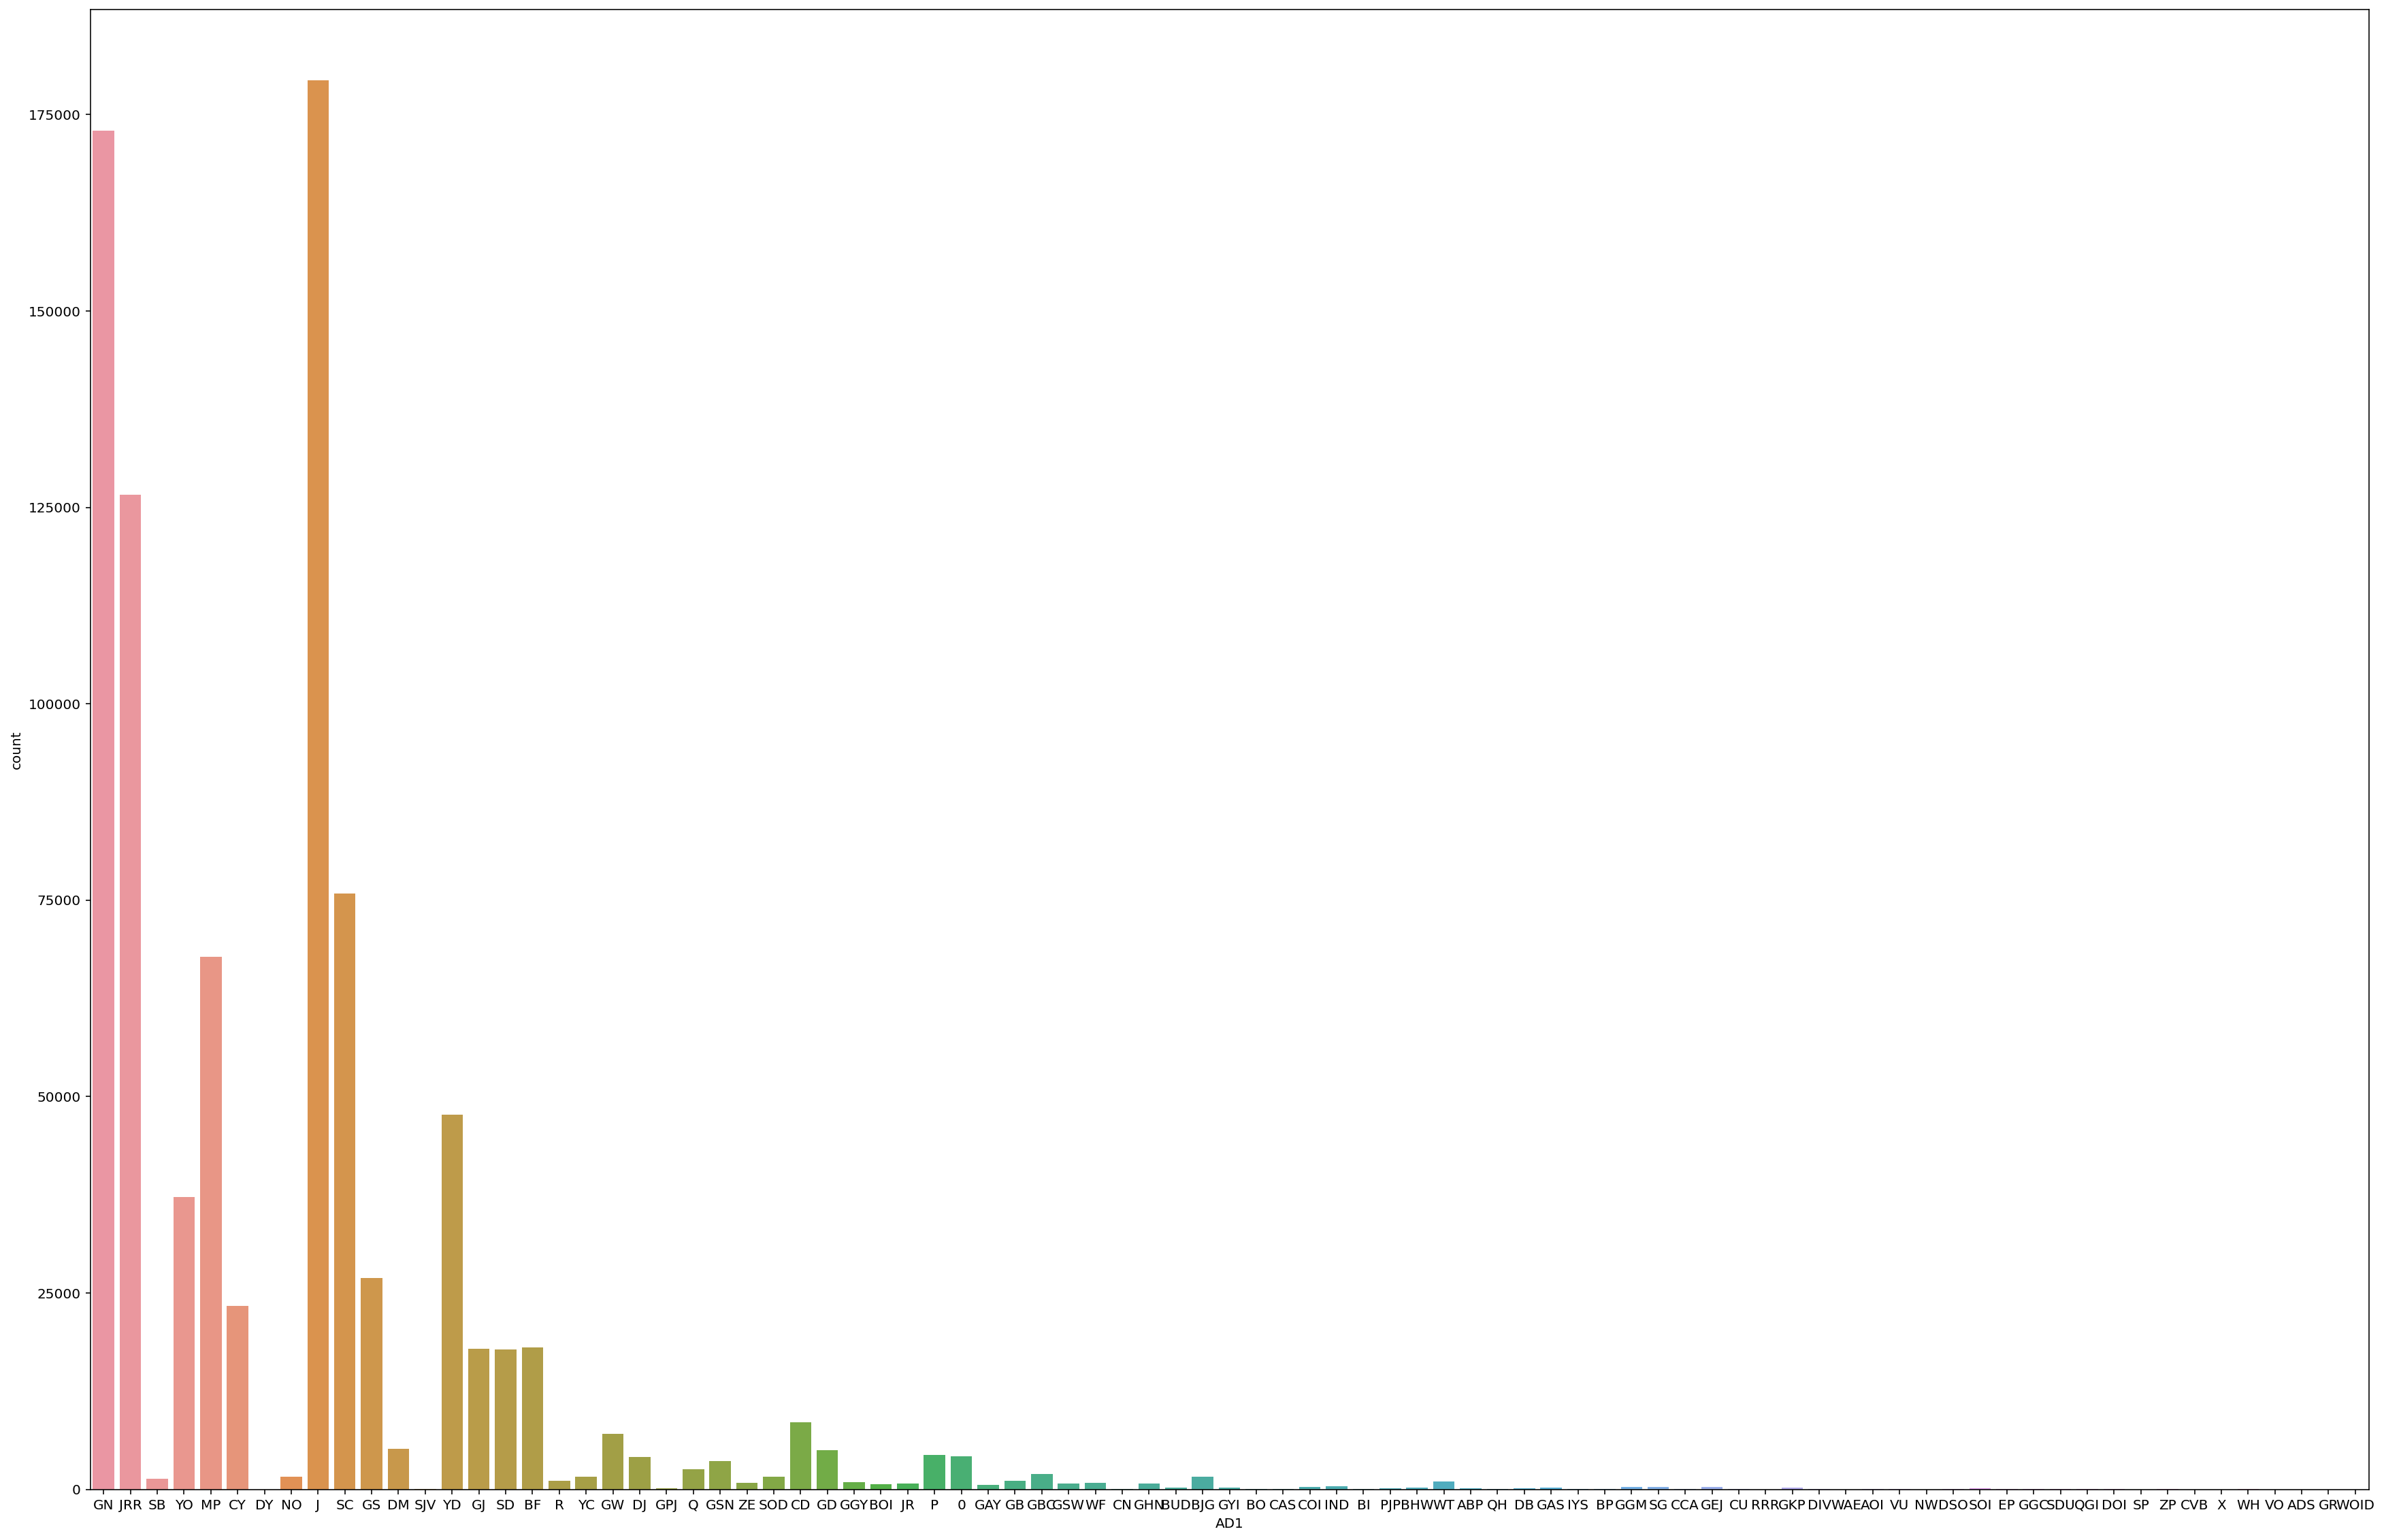

In [ ]:
fig, ax = plt.subplots(figsize=(30,20))
sns.countplot(data=df, x='AD1', ax=ax)

In [ ]:
df.groupby('AD1')['COUNT'].value_counts()
ad_df = df.groupby('AD1')['COUNT'].sum().sort_values(ascending=False).reset_index()
ad_df

,AD1,COUNT
0,J,184660
1,GN,178190
2,JRR,130476
3,SC,78176
4,MP,69277
...,...,...
80,SP,3
81,VO,1
82,NW,1
83,ADS,1


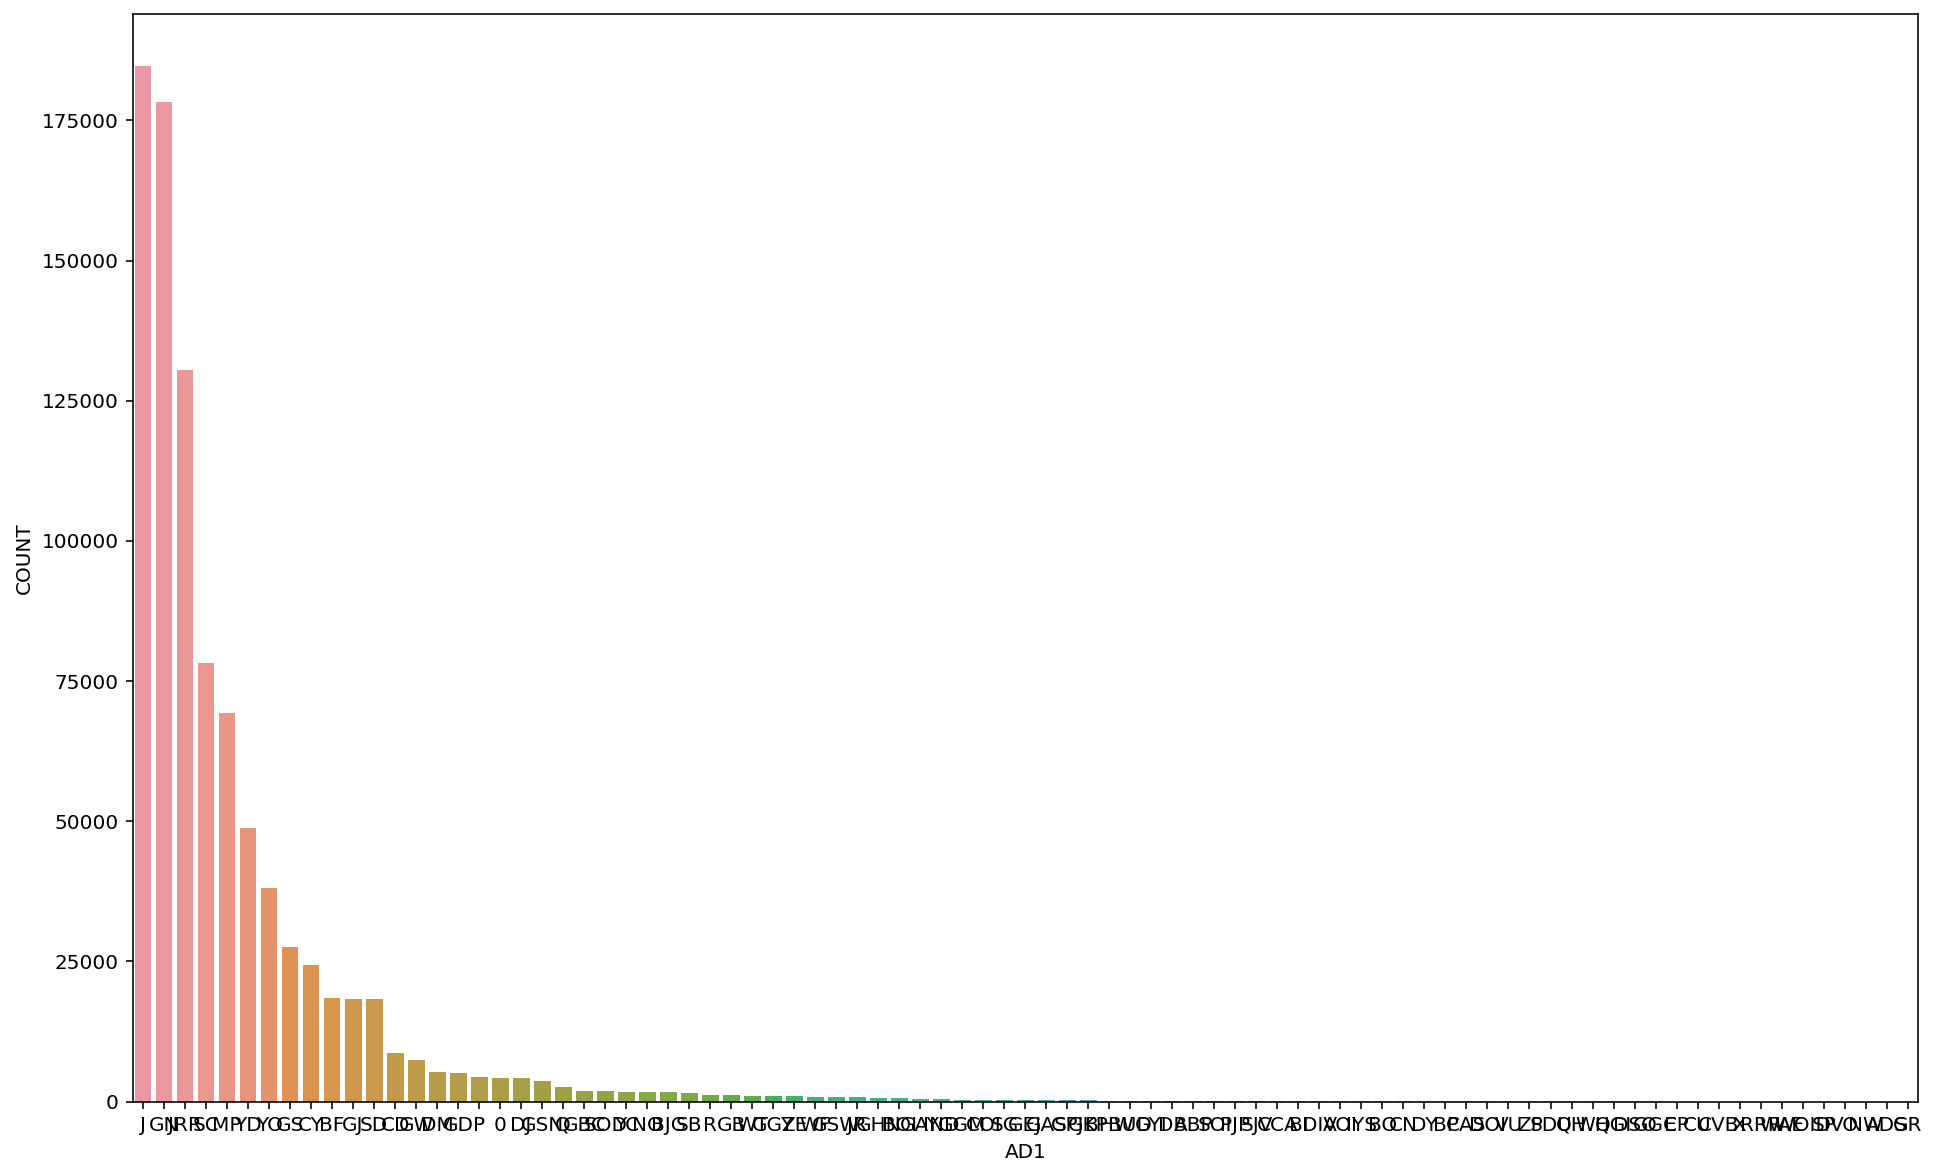

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(16,10)
sns.barplot(data=ad_df, x='AD1', y='COUNT', ax=ax)

- AD1 별로 결제 건수의 편차가 심함.
- STORE_ID의 plot과 비슷한 형태인 것으로 파악됨
- AD1과 STORE_ID와의 연관성 파악할 필요성 느낌

## STORE_ID와 AD1과의 상관관계

In [ ]:
df.groupby(['AD1','STORE_ID'])['COUNT'].sum() # 1061
# ad1store_df = ad1store.to_frame()
# ad1store_df.sort_values(['AD1','COUNT'])
# len(df['STORE_ID'].unique()) # 1061

AD1  STORE_ID
0    157708       296
     172827      2409
     173849        70
     190306        22
     203766        42
                 ... 
ZE   222384        60
     222385        19
     223124         1
ZP   220973        23
     221040         7
Name: COUNT, Length: 1061, dtype: int64

In [ ]:
#STORE_ID와 AD1과의 상관관계
ad_list = df['AD1'].unique().tolist()
ndf_list = []
for i in ad_list :
    ndf = df[df['AD1']==i]
    ndf_list.append(ndf)
    print(i,"의 STORE_ID 리스트 : ", ndf['STORE_ID'].unique())

GN 의 STORE_ID 리스트 :  [ 96266 220607   1900 109832   2058  90542 109905  83199 220689 220578
 228946  90545 190482 221045  90461 220700 207620 190483 220071 219913
  82429  90444 109796  90447 104916   1892 104988 220848  90448 221022
 222819 109839 220685 220284 131080  82430 220906 109780  82407 231045
  90500 220690  90445 104905 219886    472 207623 204458 106347 108963
 109768 137450  97308 220773 203642 220635 220850 220259 204526 220660
 109805 220087 219888  96257 105426 173176 204443 190054 109877 220971
 106329 220667 106112 223653 228941 220962 220692 220735   2457   1070
 204444 173872 221013 231434 109819 181817 231087 219977 230732  96255
 231406 223135 222317 220612 230836  90473 222313   1053 105424 204481
 220933 220854 109745 220628 220394 108914  90433    774  90516 228926
 223650 220582 220680   1058 105345 229411 223012 106355 228962 223025
 222381 222210 230736 204535 204500    456 230866 220377 106353 222238
 109801 222331 231041 230998 231444 231428 173848 220763

In [ ]:
ndf_list

[        USER_ID  JOIN_DATE D_TYPE  ...  is_weekend is_holiday DAY
 729776   999665 2018-12-16     CC  ...           1          0   5
 764097   999665 2018-12-16     CC  ...           0          0   2
 705100   999665 2018-12-16     CC  ...           0          0   4
 777538   999665 2018-12-16     CC  ...           1          0   6
 711885   999665 2018-12-16     CC  ...           1          0   6
 ...         ...        ...    ...  ...         ...        ...  ..
 295475  1578458 2020-05-25     AA  ...           0          0   2
 295482  1578659 2020-05-26     AA  ...           0          0   2
 295484  1578663 2020-05-26     BB  ...           0          0   2
 295488  1578797 2020-05-26     BB  ...           0          0   2
 295495  1579168 2020-05-26     AA  ...           0          0   2
 
 [172967 rows x 16 columns],
         USER_ID  JOIN_DATE D_TYPE  ...  is_weekend is_holiday DAY
 748372   999665 2018-12-16     CC  ...           0          0   4
 751974   999665 2018-12-16    

In [ ]:
df.query('JOIN_DATE == 1970 and D_TYPE =="CC"')
df.query('JOIN_DATE != 1970 and D_TYPE =="CC"')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE,is_weekend,is_holiday,DAY
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,7919,mvp,1,0,5
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,7919,mvp,0,0,4
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,7919,mvp,1,0,5
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,7919,mvp,0,0,4
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,7919,mvp,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287530,1393530,2019-11-15,CC,220721,C,2020-05-24,1,BF,6,5,21,26,vip,1,0,6
282415,1393529,2019-11-15,CC,220722,A,2020-05-22,1,BF,4,5,21,13,gold,0,0,4
299887,1393530,2019-11-15,CC,220721,A,2020-05-29,1,BF,4,5,22,26,vip,0,0,4
302692,1393530,2019-11-15,CC,220721,A,2020-05-30,1,BF,5,5,22,26,vip,1,0,5


In [ ]:
## STORE_ID 별 AD1의 값 변동 여부 확인
from tqdm import tqdm

store_list = df["STORE_ID"].unique().tolist()
for i in tqdm(store_list):
  # print(df[df['USER_ID']==i]["D_TYPE"])
  str_list = df[df['STORE_ID']==i]["AD1"].tolist()
  # print(str_list)
  for s in str_list:
    
    if ch_list.count(c) != len(ch_list):
      # print(ch_list.count(c), len(ch_list))
      print('{}의 AD1이 다름'.format(i))
    

100%|██████████| 1061/1061 [00:02<00:00, 381.96it/s]


### STORE_ID 별 AD1값은 변동되지 않음 -> 각각 STORE_ID 별로 AD1 값이 할당되었다고 볼 수 있음 

이를 통해 AD1을 주소로 가정 및 이니셜 및 결제건수를 통해 지역구 추정

+ 서울 지역구  
1. 종로구 : JR
2. 중구 : J
3. 용산구 : YO
4. 성동구 : SOD
5. 광진구 : GJ
6. 동대문구 : DM
7. 중랑구 : JRR
8. 성북구 : SB
9. 강북구 : GB
10. 도봉구 : DB
11. 노원구 : NW
12. 은평구 : EP
13. 서대문구 : SD
14. 마포구 : MP
15. 양천구 : YC
16. 강서구 : GS
17. 구로구 : GR
18. 금천구 : GHN
19. 영등포구 : YD
20. 동작구 : DJ
21. 관악구 : GW
22. 서초구 : SC
23. 강남구 : GN
24. 송파구 : SP
25. 강동구 : GD



### 회원 등급별 결제 장소(AD1)의 차이가 있을까?

In [ ]:
ad_top10 = df.groupby(['AD1'])['COUNT'].sum().sort_values(ascending=False).reset_index()
order_list = ad_top10.AD1.tolist()
# order_list

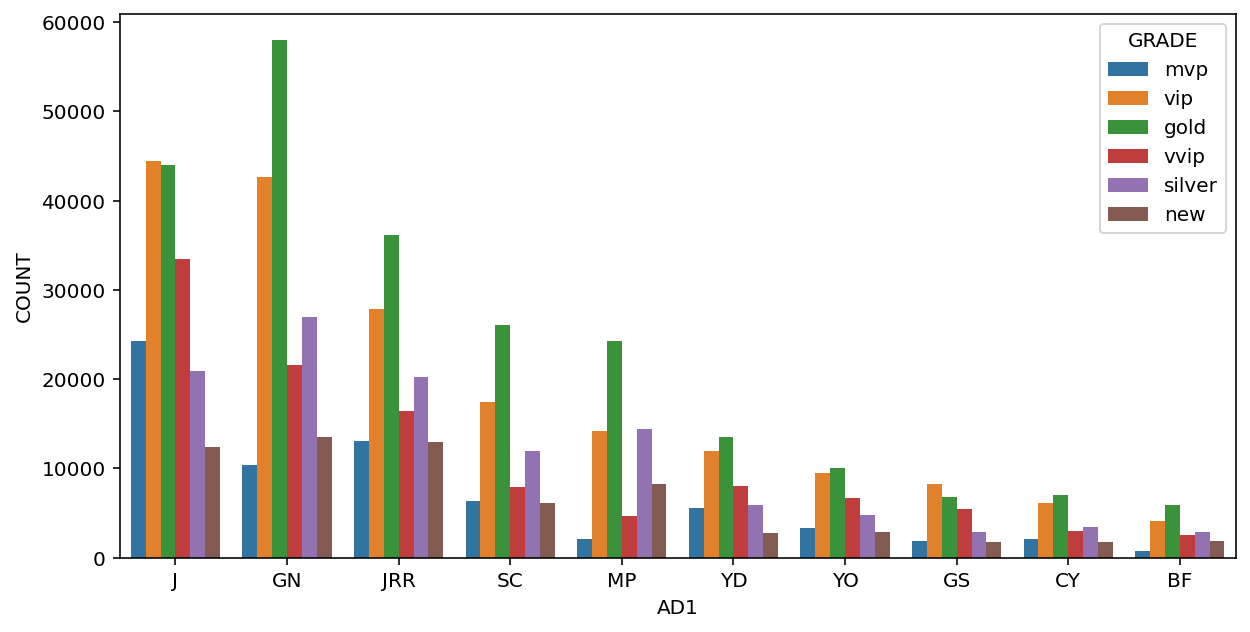

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='AD1',y='COUNT',hue='GRADE',
            order = order_list[:10], 
           estimator=len)

- 중구 : vip와 gold 등급이 유사,
- 강남구 : mvp등급이 적은편이며, 골드 등급이 월등하게 많음
- 중랑구 : 골드 등급이 월등히 많음
- 마포구 : mvp와 vvip등급이 적은편 

### 중구의 골드 등급, 강남구의 mvp 등급, 마포구의 mvp, vvip 등급이 타 지역의 등급별 비율에 비해 적으므로, 이들의 등급을 높이기 위한 전략이 필요

### 회원 등급별 결제 요일의 차이가 있을까?

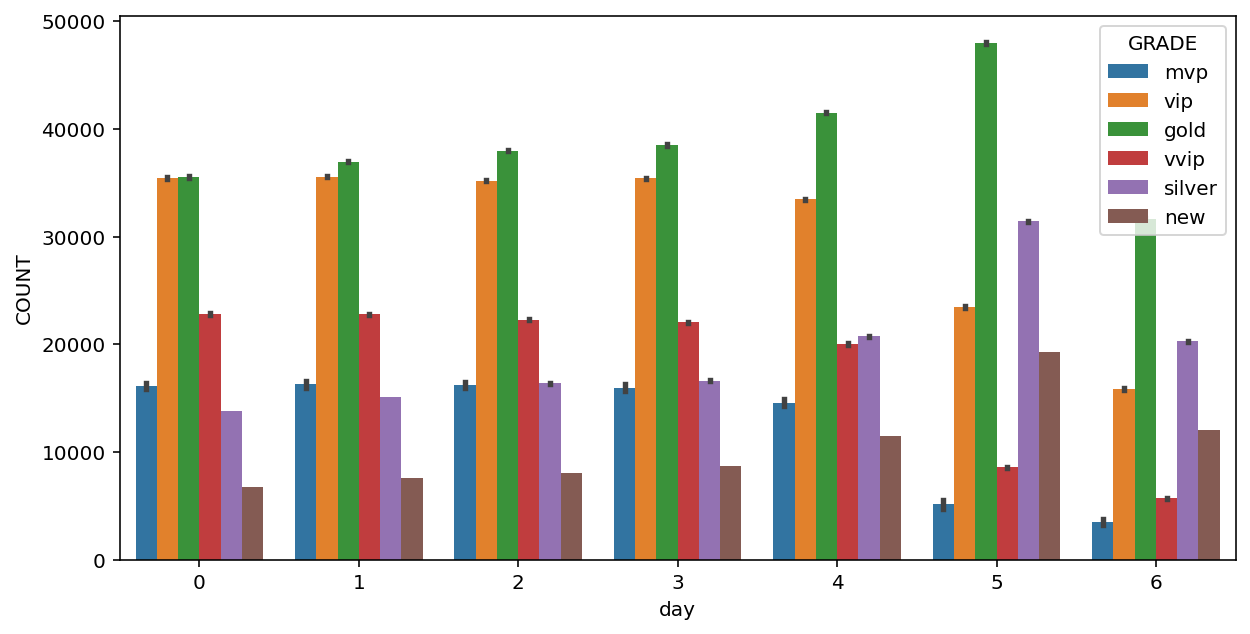

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='day', y='COUNT', estimator=sum,
           hue = 'GRADE'
           )

- mvp 등급의 경우 주로 평일에 결제가 많이 이루어지는 것으로 보아, 직장인일 가능성이 높음
- vvip, vip 등급도 마찬가지로 주로 평일에 결제
- gold 와 silver 등급의 경우 평일보다 주말에 결제를 더 많이 하는 모습

### 따라서 주 타겟인 직장인을 대상으로 프로모션 진행하는 것을 고려해볼만함

### 평일 기준, 지역별 회원등급별 결제 건수 확인
- 직장인으로 추정되는 mvp등급이 많은 지역 판단 위함

Text(0.5, 1.0, '주말')

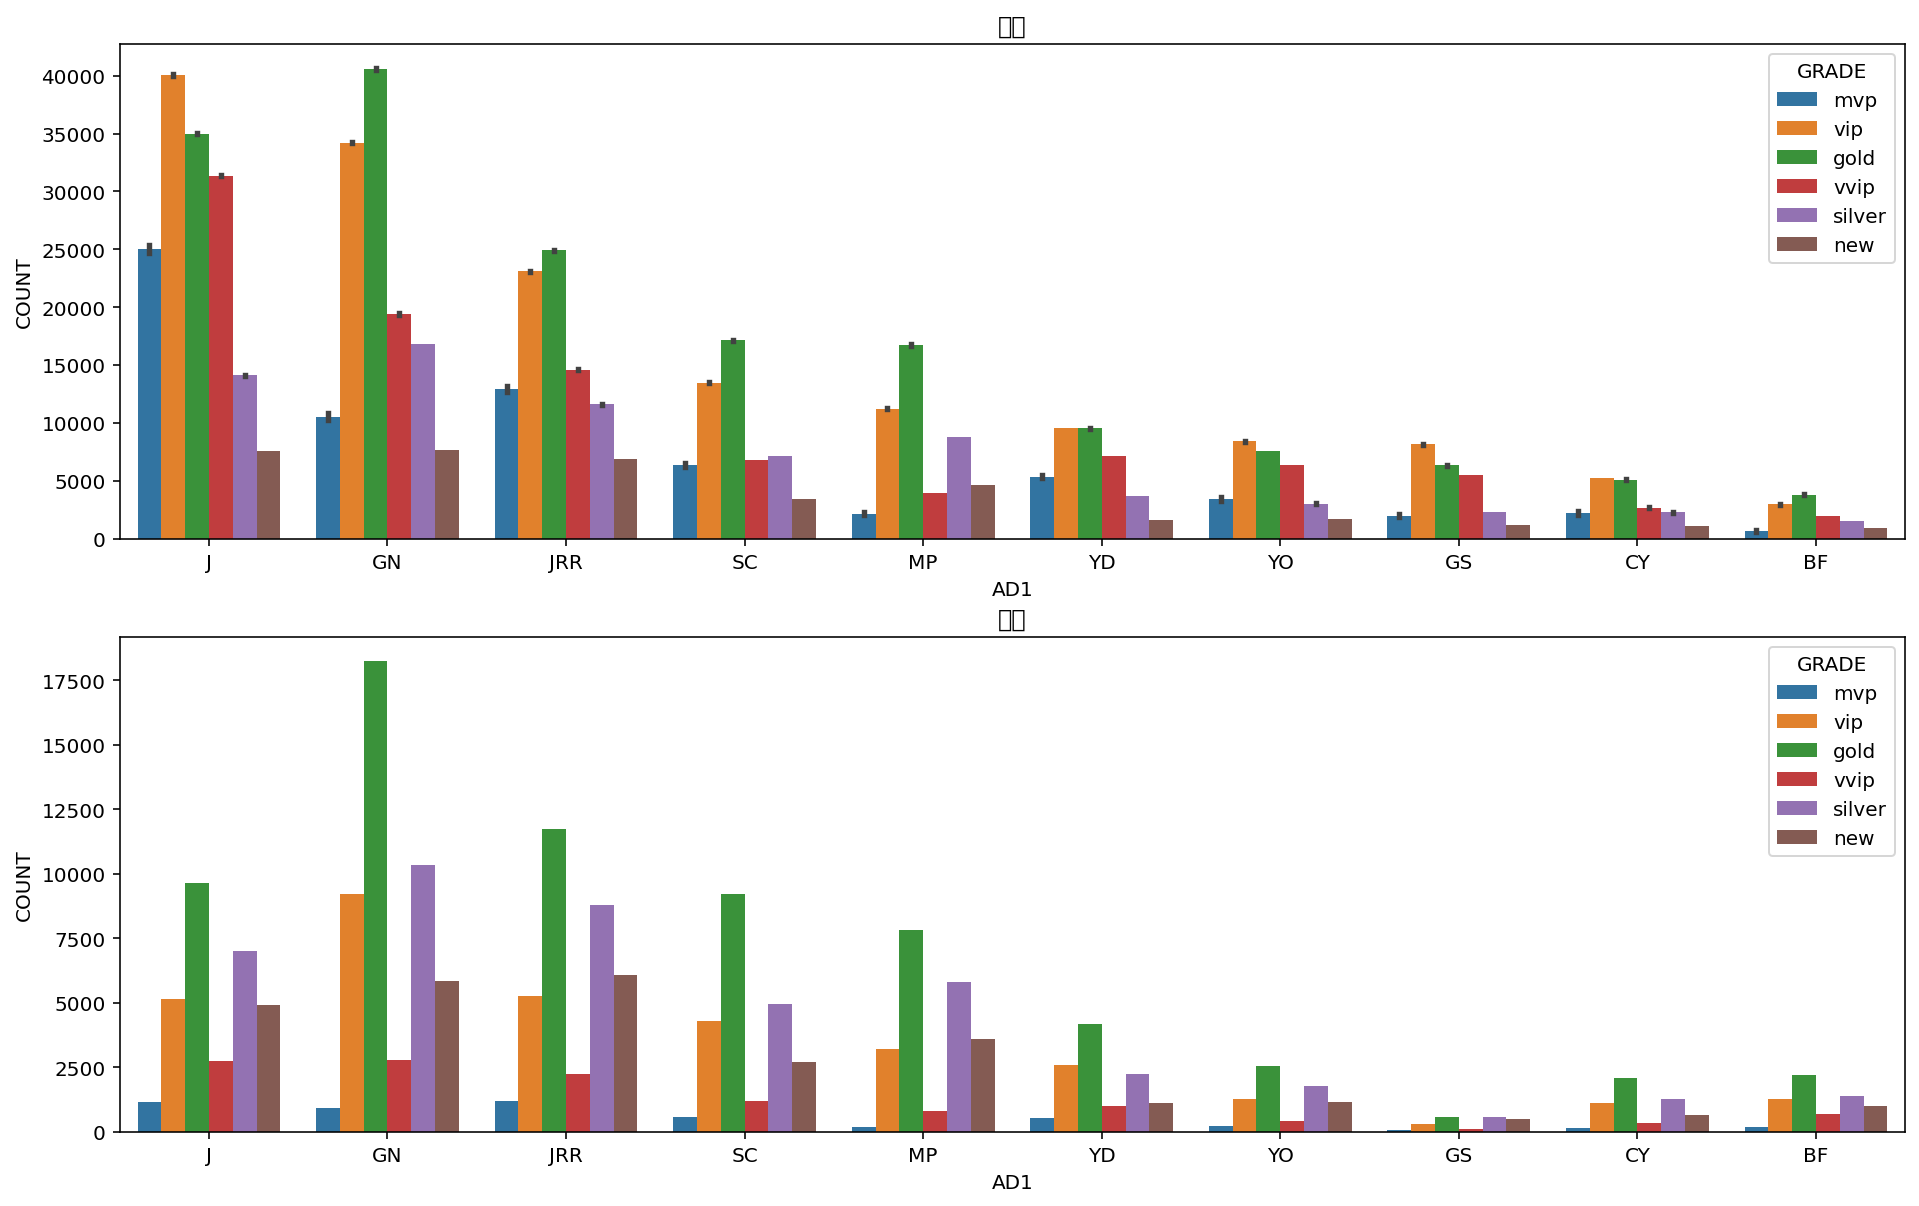

In [ ]:
df_weekend = df[df['day']>=5]
df_week = df[df['day']<5]
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16,10)
sns.barplot(data=df_week, x='AD1',y='COUNT',hue='GRADE',
            order = order_list[:10],
           estimator=sum,
           ax=ax1).set_title('평일')


sns.barplot(data=df_weekend, x='AD1',y='COUNT',hue='GRADE',
            order = order_list[:10], 
           estimator=len,
           ax=ax2).set_title('주말')

- 위의 요일별 등급별 결제 건수와 같이, 평일에는 mvp 등급의 결제 건수가 지역별로도 확연히 늘어나는 모습을 볼 수 있음
- 중구, 강남구, 중랑구, 서초구 등 직장이 많은 곳으로 보임
- 마포구의 경우, 직장인은 적은 것으로 보임

### GOODS_TYPE 과 지역별 결제 건수

Text(0.5, 1.0, '주말')

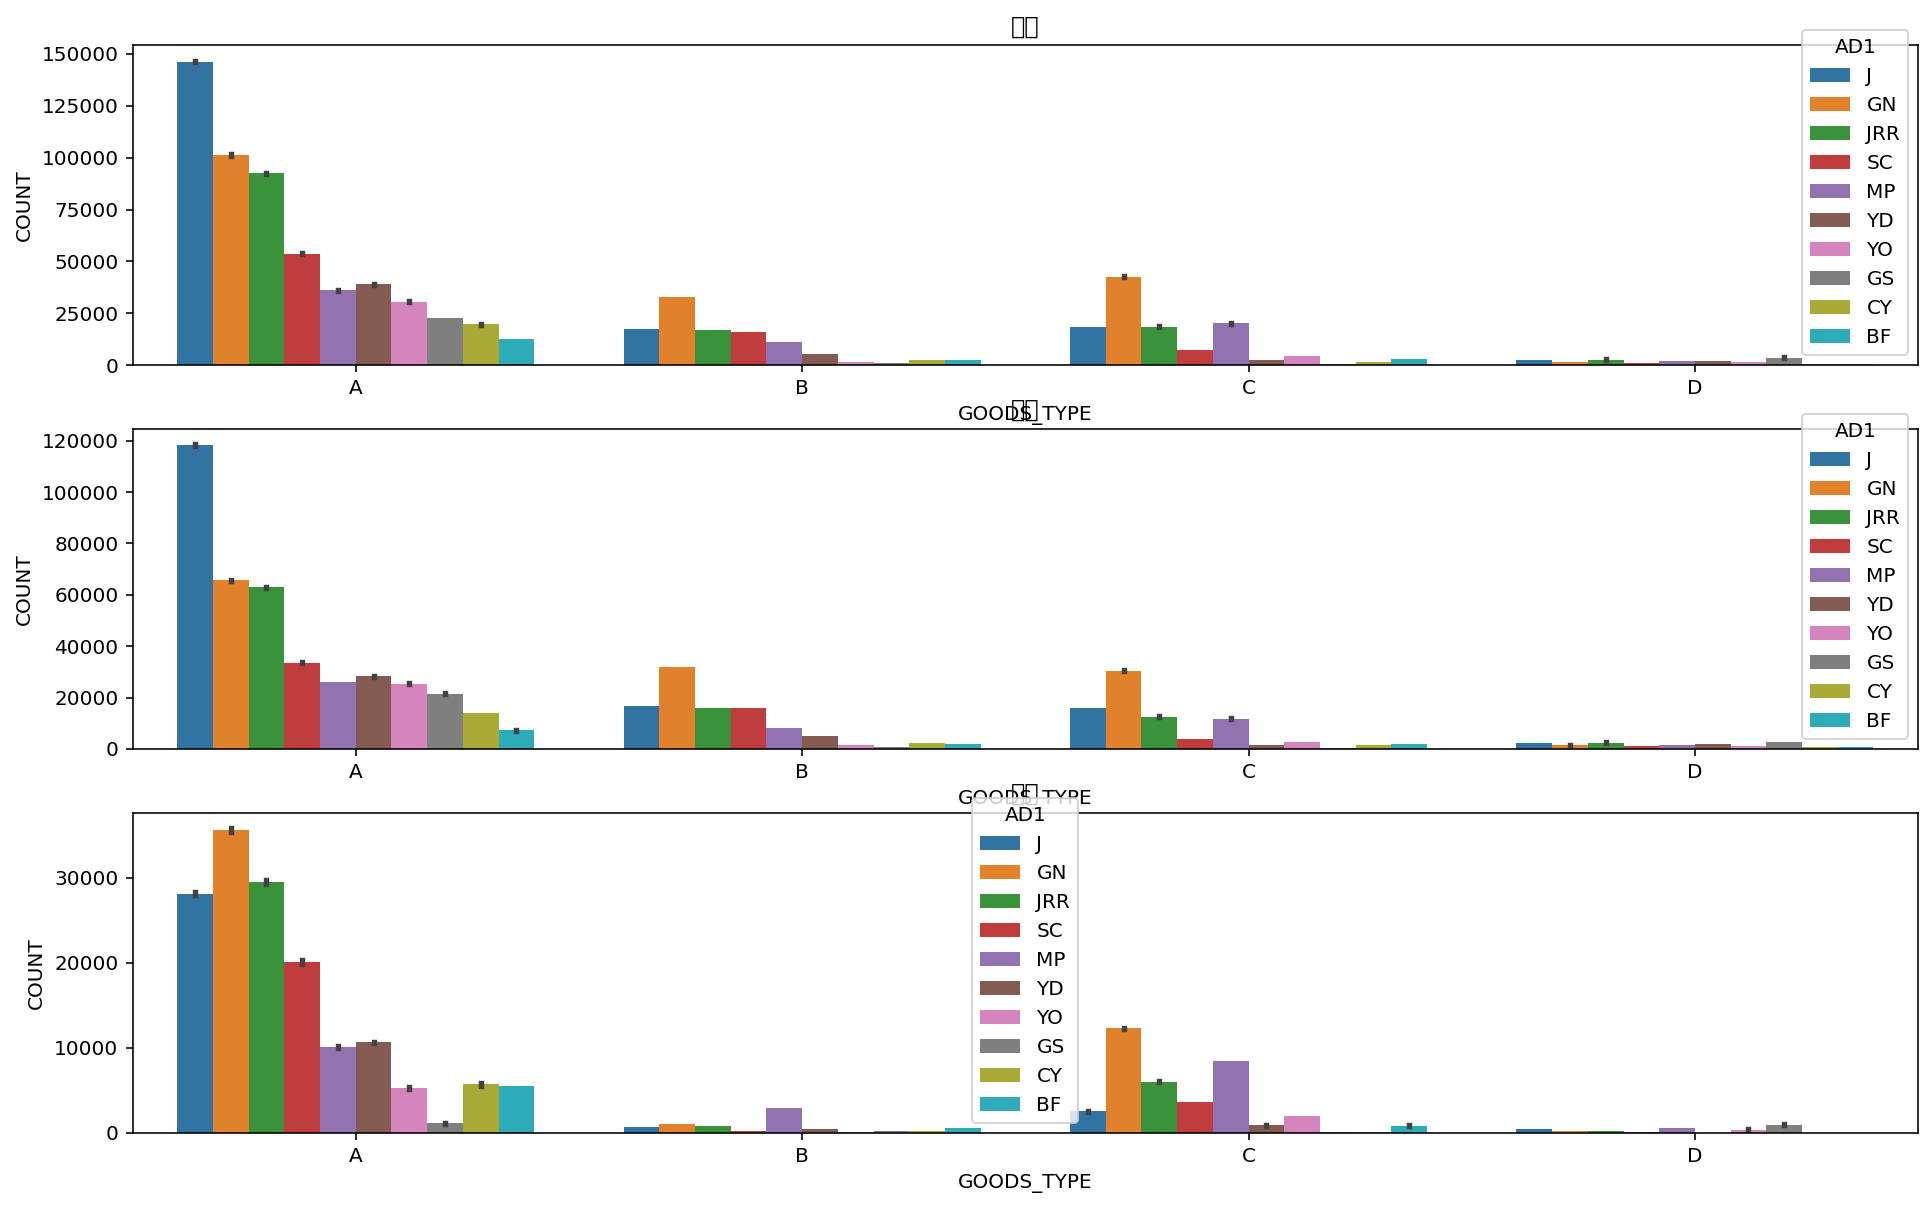

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(16,10)
# plt.figure(figsize=(10,5))
sns.barplot(data=df, x='GOODS_TYPE', y='COUNT',hue='AD1',
           order = ['A','B','C','D'], hue_order = order_list[:10],
           estimator=sum,
           ax=ax1).set_title('전체')


sns.barplot(data=df_week, x='GOODS_TYPE',y='COUNT',hue='AD1',
            order = ['A','B','C','D'], hue_order = order_list[:10],
           estimator=sum, ax=ax2).set_title('평일')


sns.barplot(data=df_weekend, x='GOODS_TYPE',y='COUNT',hue='AD1',
            order = ['A','B','C','D'], hue_order = order_list[:10],
           estimator=sum,
           ax=ax3).set_title('주말')

- 전체 데이터 중 상품 타입별
1. A타입
- 중구는 확실히 A타입의 평일의 결제비율이 높은 편
- 강남의 경우, A 타입의 결제율은 전체에서는 높지만, 평일에는 낮은 편, 중랑구도 마찬가지
- 강서의 경우 주말에는 낮은 편, 평일에는 높은 편, 
---
2. B타입
- 마포구를 제외하고 주말에 확연히 줄어드는 편

3. C타입
- 강남구,, 마포구는 주말에 늘어남



Text(0.5, 1.0, '평일')

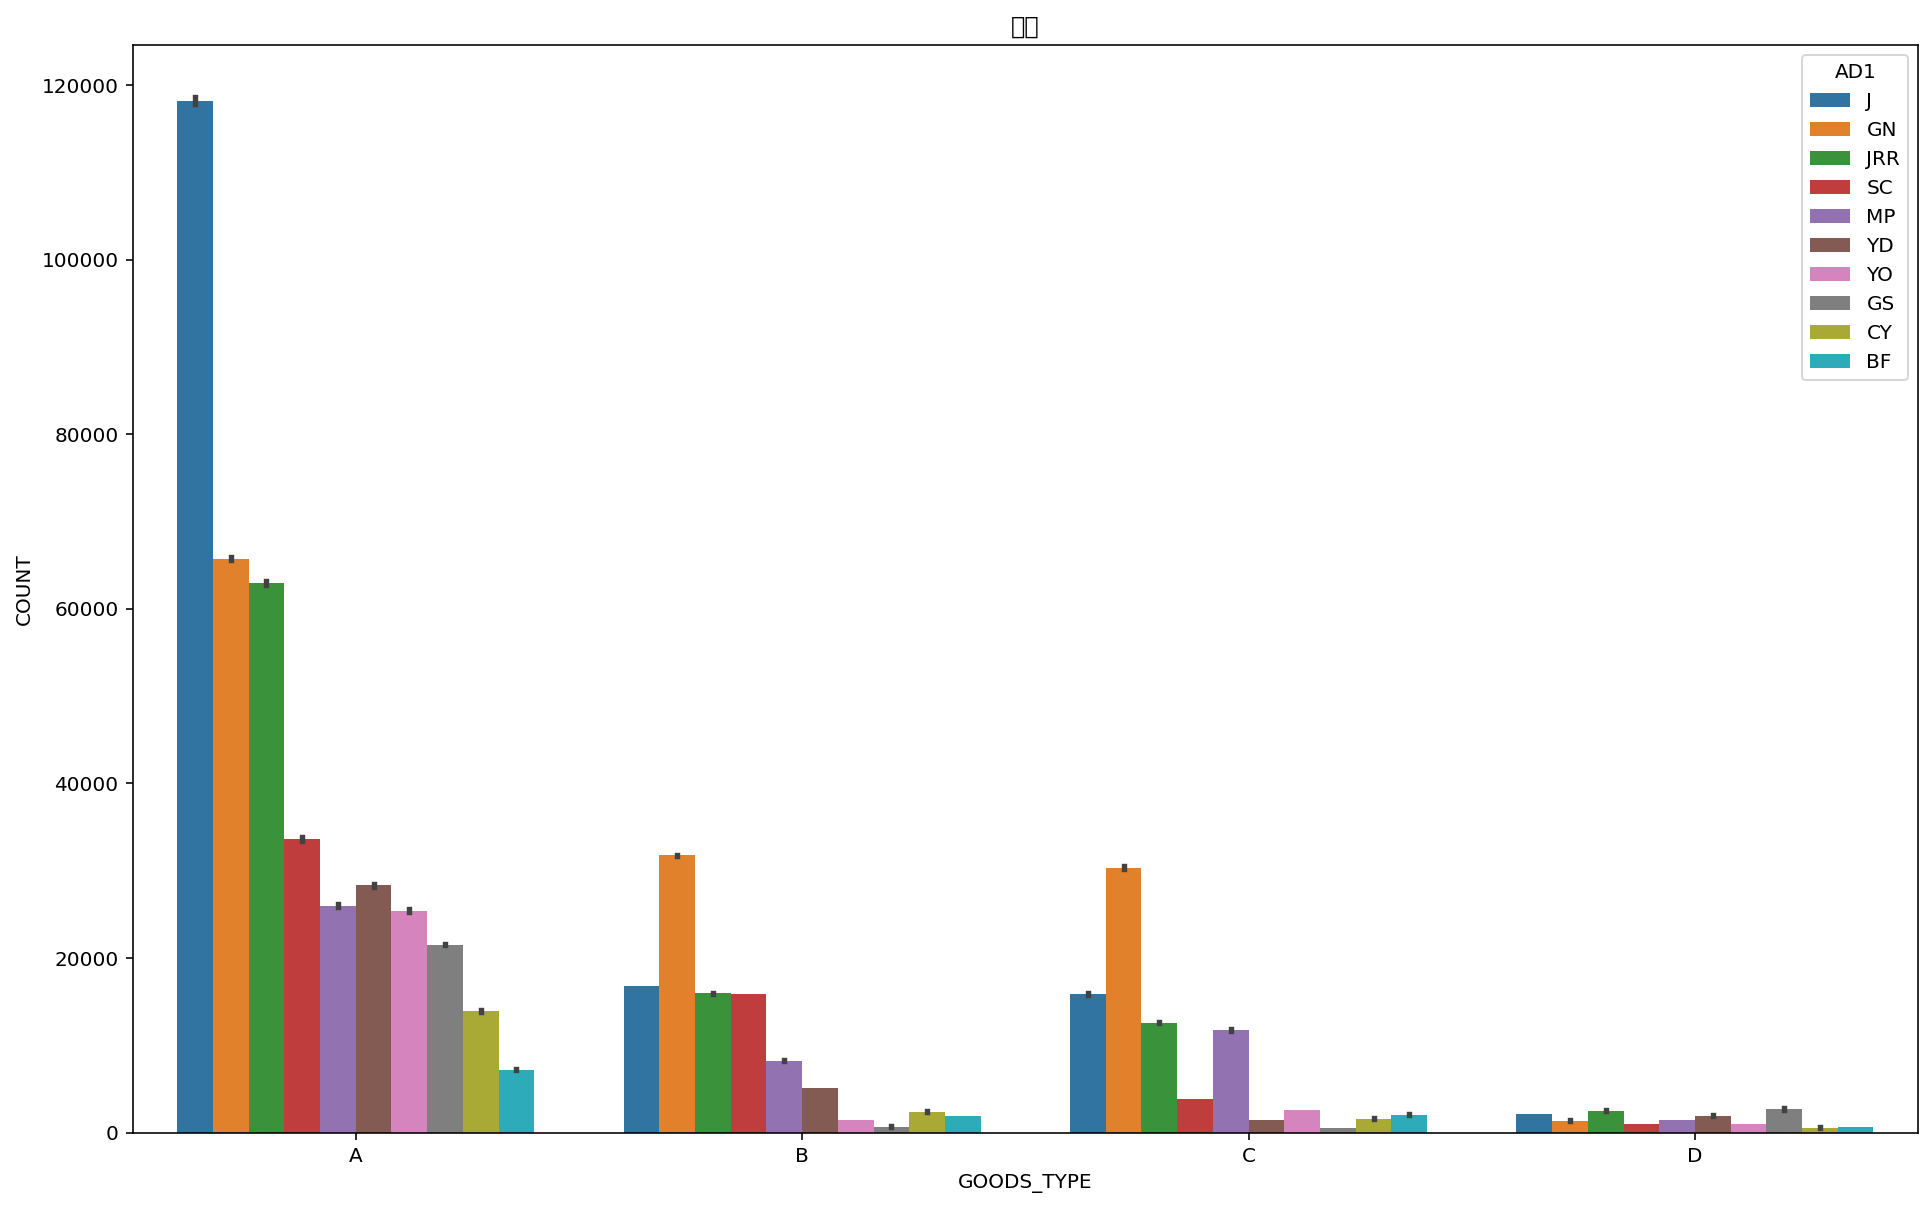

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(16,10)
sns.barplot(data=df_week, x='GOODS_TYPE',y='COUNT',hue='AD1',
            order = ['A','B','C','D'], hue_order = order_list[:10],
           estimator=sum, ax=ax1).set_title('평일')

Text(0.5, 1.0, '주말')

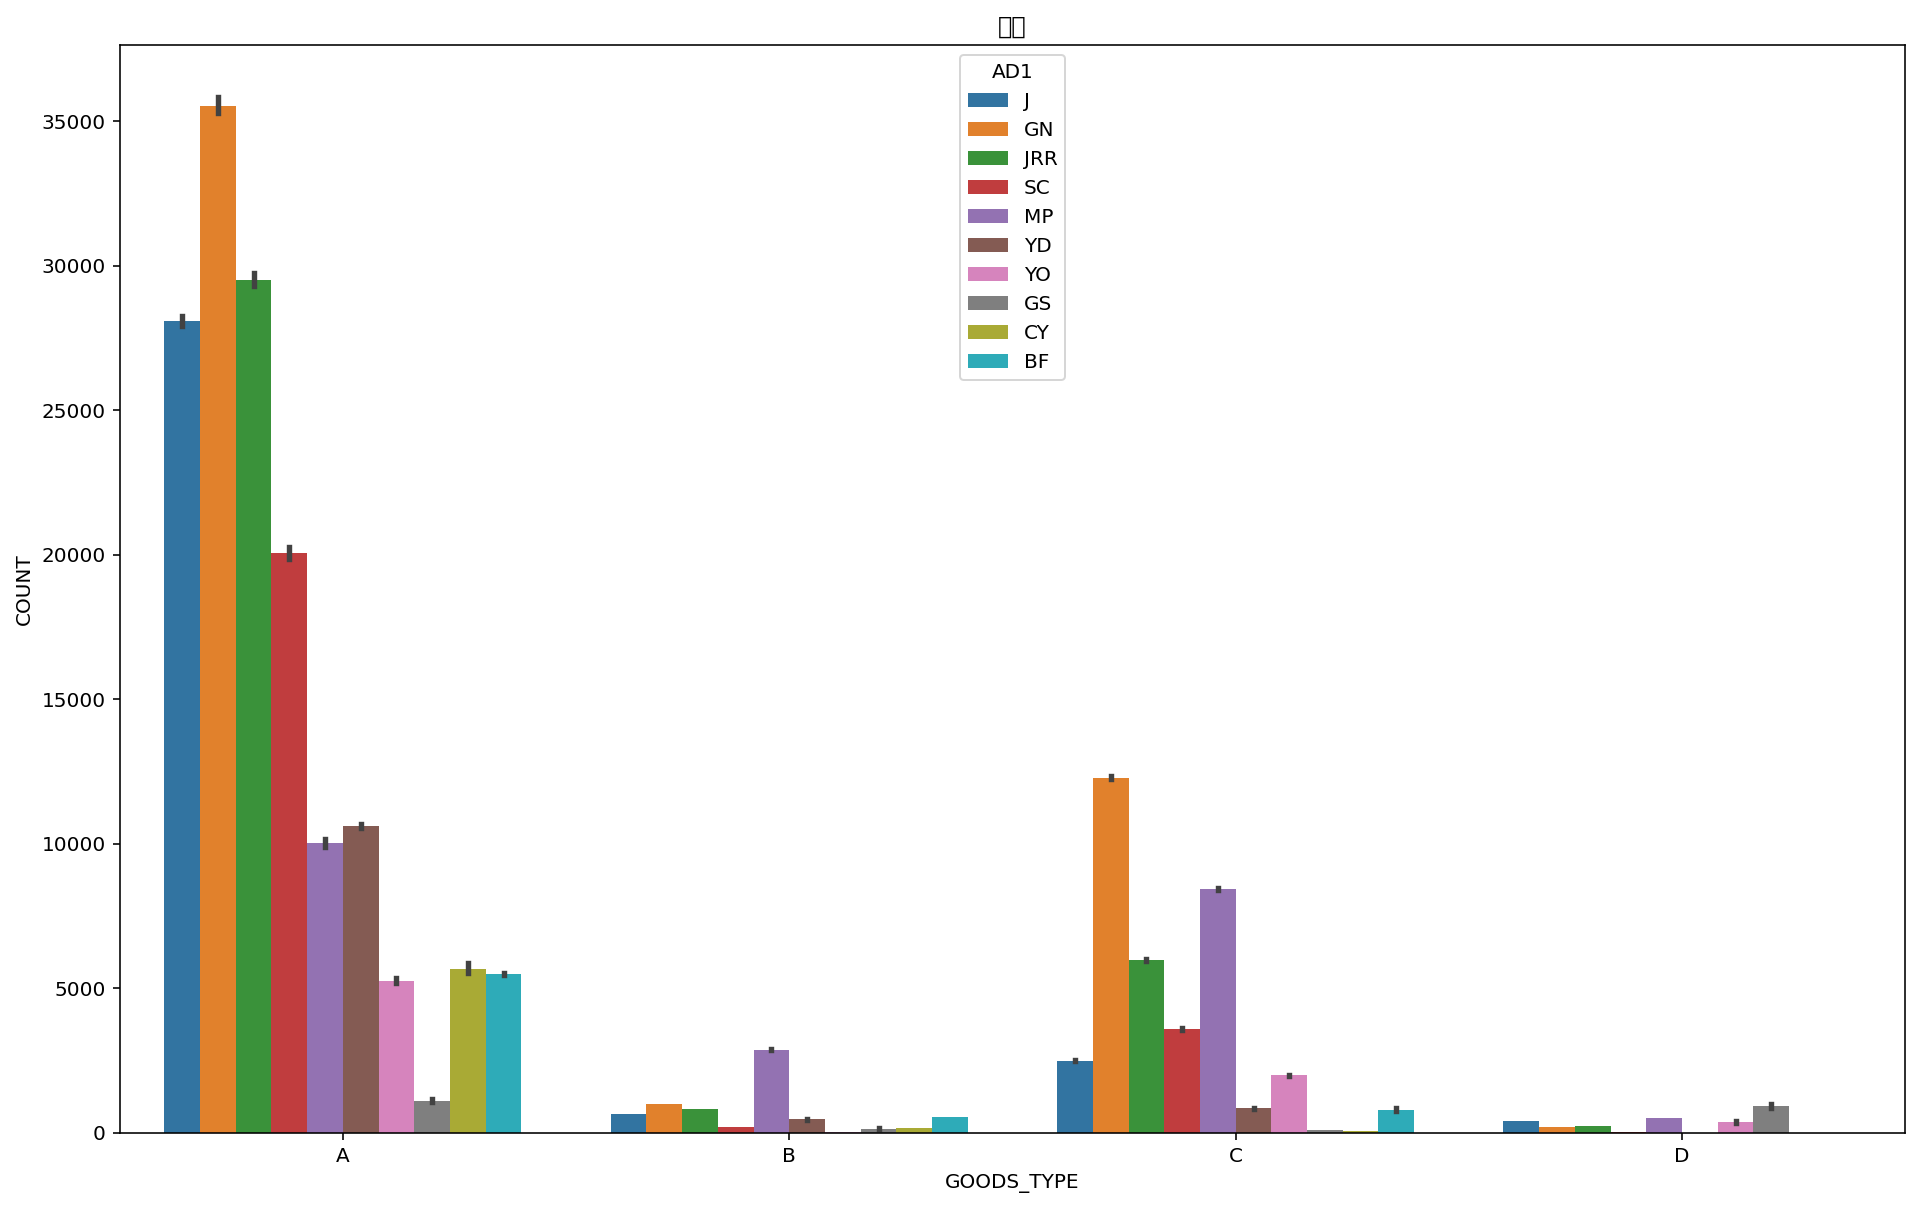

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(16,10)
sns.barplot(data=df_weekend, x='GOODS_TYPE',y='COUNT',hue='AD1',
            order = ['A','B','C','D'], hue_order = order_list[:10],
           estimator=sum,
           ax=ax1).set_title('주말')

### 회원 등급과 D_TYPE 별 결제 건수

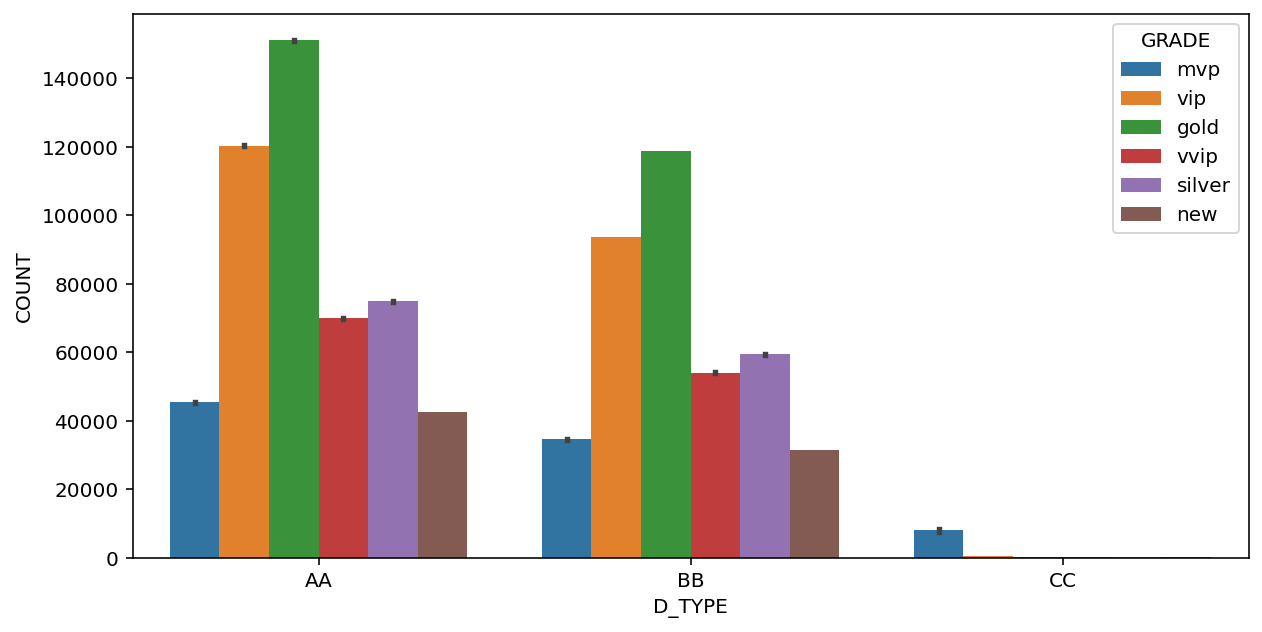

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='D_TYPE', y='COUNT',hue='GRADE',
           order = ['AA','BB','CC'],
           estimator=sum)

### 특이점
- CC에선 적은 양이지만 대부분 mvp등급
- AA그룹과 BB그룹은 별다른 특이점이 보이지 않음.

### 월 별 D_TYPE 별 결제건수 

Text(0.5, 1.0, 'BB')

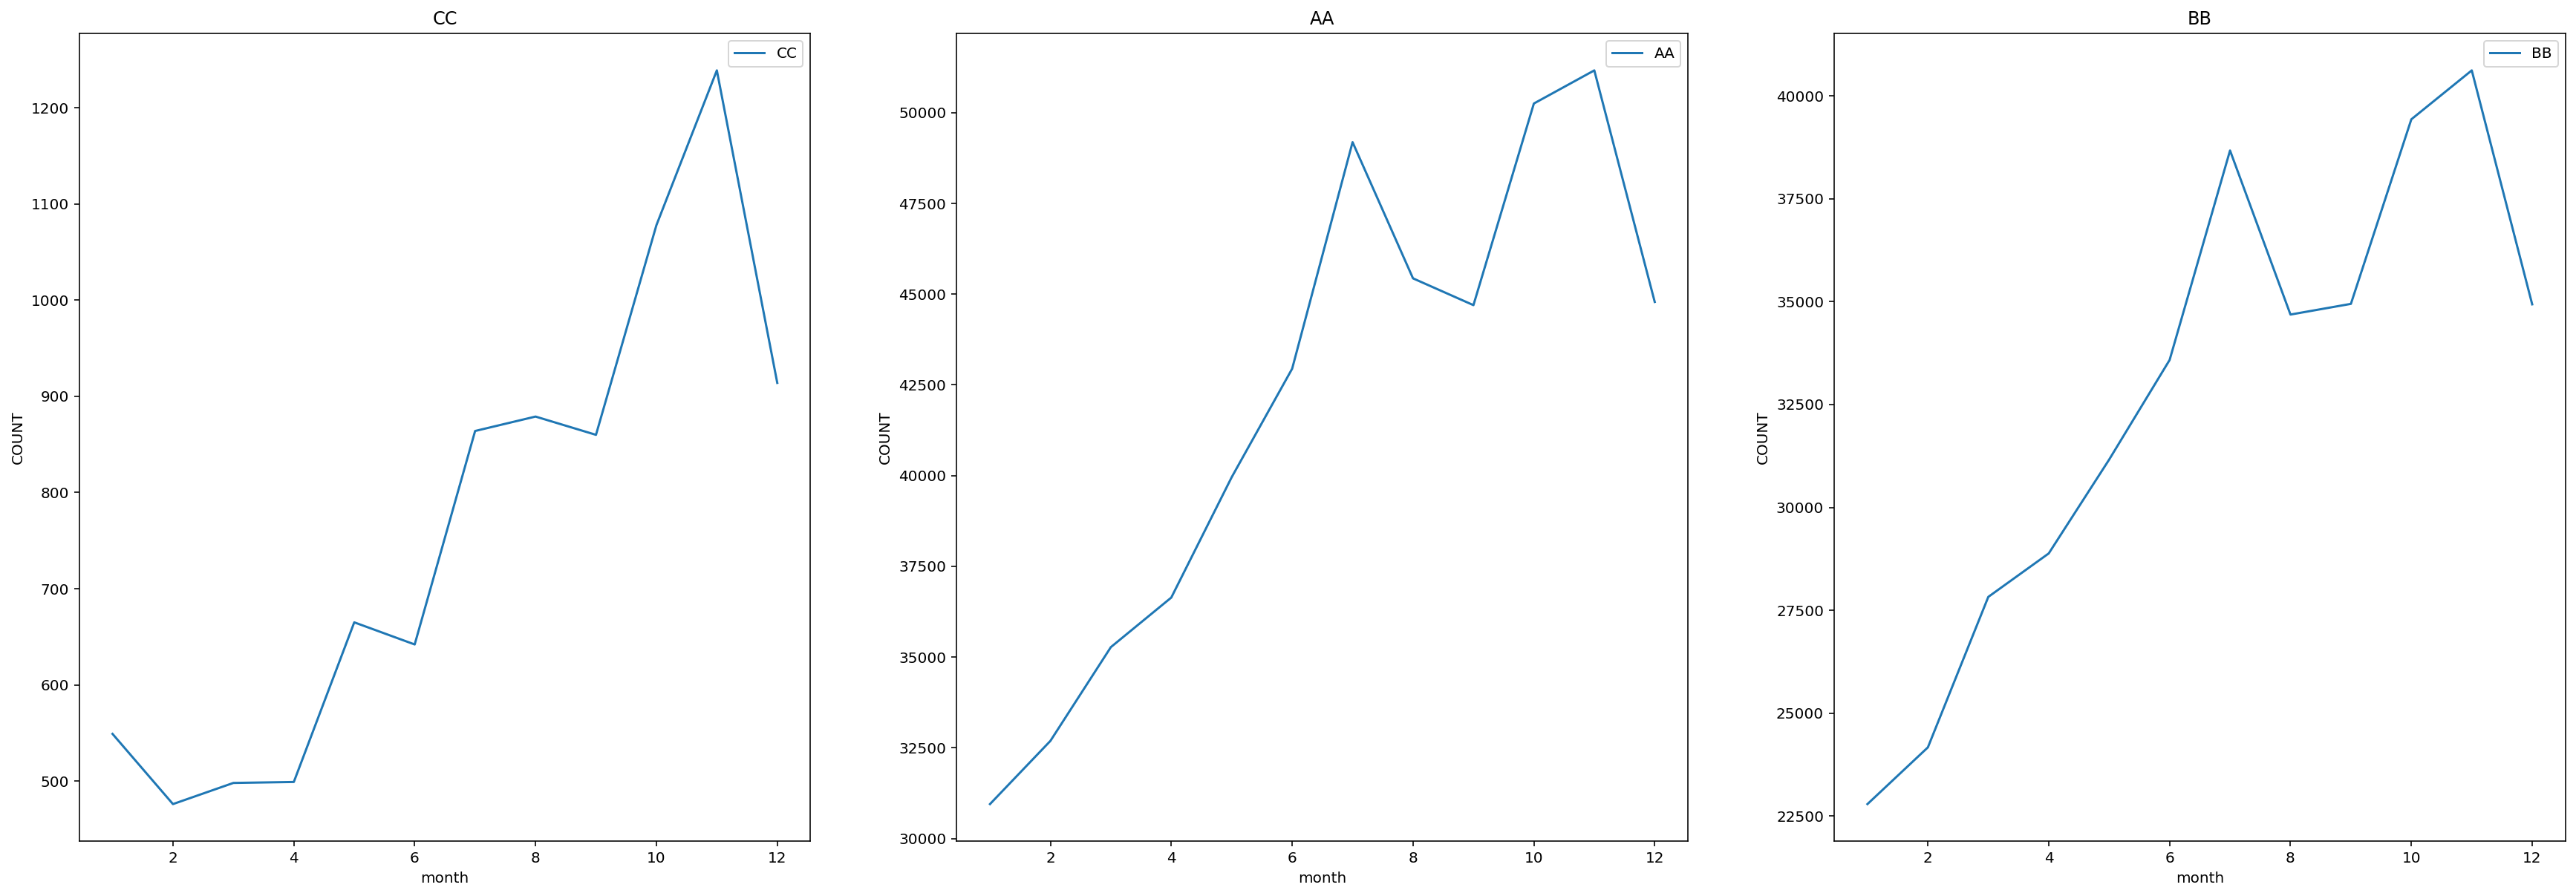

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30,10)
count_df = cdf.groupby('month')['COUNT'].sum().reset_index()
count_df2 = adf.groupby('month')['COUNT'].sum().reset_index()
count_df3 = bdf.groupby('month')['COUNT'].sum().reset_index()
sns.lineplot(data=count_df, x='month', y = 'COUNT', label = 'CC', ax=ax1).set_title('CC')
sns.lineplot(data=count_df2, x='month', y = 'COUNT', label = 'AA', ax=ax2).set_title('AA')
sns.lineplot(data=count_df3, x='month', y = 'COUNT', label="BB", ax=ax3).set_title('BB')

## 외부 데이터
### 기상 자료 확인

In [ ]:
weather

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


결측치 확인

In [ ]:
weather.isnull().sum()

지점         0
일시         0
기온         1
강수량     7701
풍속         0
습도         0
일조시간    3969
적설량     8552
지면온도       8
지중온도      12
dtype: int64

In [ ]:
## DATE 컬럼 생성 JOIN시 편의
weather['DATE']= weather['일시'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))

In [ ]:
## 기온 결측치 처리
np.where(weather.기온.isnull()) # 5724
weather.iloc[5724]
weather[weather['DATE']=='2020-08-26']

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,DATE
5711,108,2020-08-26 0:00,28.7,NaN,2.7,76,NaN,NaN,27.1,27.9,2020-08-26
5712,108,2020-08-26 1:00,28.4,NaN,2.1,77,NaN,NaN,26.6,27.9,2020-08-26
5713,108,2020-08-26 2:00,28.1,NaN,1.8,79,NaN,NaN,26.1,27.8,2020-08-26
5714,108,2020-08-26 3:00,27.6,NaN,2.0,80,NaN,NaN,25.8,27.8,2020-08-26
5715,108,2020-08-26 4:00,27.3,NaN,2.0,82,NaN,NaN,25.6,27.8,2020-08-26
5716,108,2020-08-26 5:00,27.2,NaN,2.1,82,NaN,NaN,25.4,27.8,2020-08-26
5717,108,2020-08-26 6:00,27.0,NaN,2.9,82,0.0,NaN,25.3,27.7,2020-08-26
5718,108,2020-08-26 7:00,27.3,NaN,2.7,82,0.6,NaN,25.8,27.7,2020-08-26
5719,108,2020-08-26 8:00,28.6,NaN,2.7,79,1.0,NaN,28.1,27.6,2020-08-26
5720,108,2020-08-26 9:00,29.7,NaN,3.2,74,0.8,NaN,31.2,27.6,2020-08-26


In [ ]:
# 결측치 대체 후 null값 제대로 채워졌는지 확인
weather['기온'] = weather['기온'].fillna((33.3+34.1)/2)
weather[weather['DATE']=='2020-08-26']


,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,DATE
5711,108,2020-08-26 0:00,28.7,NaN,2.7,76,NaN,NaN,27.1,27.9,2020-08-26
5712,108,2020-08-26 1:00,28.4,NaN,2.1,77,NaN,NaN,26.6,27.9,2020-08-26
5713,108,2020-08-26 2:00,28.1,NaN,1.8,79,NaN,NaN,26.1,27.8,2020-08-26
5714,108,2020-08-26 3:00,27.6,NaN,2.0,80,NaN,NaN,25.8,27.8,2020-08-26
5715,108,2020-08-26 4:00,27.3,NaN,2.0,82,NaN,NaN,25.6,27.8,2020-08-26
5716,108,2020-08-26 5:00,27.2,NaN,2.1,82,NaN,NaN,25.4,27.8,2020-08-26
5717,108,2020-08-26 6:00,27.0,NaN,2.9,82,0.0,NaN,25.3,27.7,2020-08-26
5718,108,2020-08-26 7:00,27.3,NaN,2.7,82,0.6,NaN,25.8,27.7,2020-08-26
5719,108,2020-08-26 8:00,28.6,NaN,2.7,79,1.0,NaN,28.1,27.6,2020-08-26
5720,108,2020-08-26 9:00,29.7,NaN,3.2,74,0.8,NaN,31.2,27.6,2020-08-26


In [ ]:
# 최고기온
max_temp_df = weather.groupby('DATE')['기온'].max().reset_index().rename(columns={'기온':'최고기온'}, inplace=False)

# 최저기온
min_temp_df = weather.groupby('DATE')['기온'].min().reset_index().rename(columns={'기온':'최저기온'}, inplace=False)

# 일 평균 시간당 강수량
rain_day_df = weather.groupby('DATE')['강수량'].mean().reset_index().rename(columns={'강수량':'일 평균 시간당 강수량'}, inplace=False)

# 최고습도
humidity_df = weather.groupby('DATE')['습도'].max().reset_index().rename(columns={'습도':'최고습도'}, inplace=False)

# Merge
dailyweather_df = pd.merge(max_temp_df, rain_day_df, how='outer', on='DATE')
dailyweather_df2 = pd.merge(dailyweather_df, min_temp_df, how='outer', on='DATE')
dailyweather_df3 = pd.merge(dailyweather_df2, humidity_df, how='outer', on='DATE')

# 12월 31일 날씨 데이터가 0:00시 밖에 없음 => 누락된 데이터 당일 최고기온으로 수정
# -> 기상청 자료
dailyweather_df3.loc[dailyweather_df3['DATE']=='2020-12-31', '최저기온'] = -5.00
dailyweather_df3

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도
0,2020-01-01,0.3,0.025000,-5.9,76
1,2020-01-02,3.8,NaN,-0.7,74
2,2020-01-03,4.3,NaN,-3.3,86
3,2020-01-04,6.1,NaN,-2.7,64
4,2020-01-05,6.5,NaN,-3.1,61
...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77
362,2020-12-28,11.0,0.650000,4.3,91
363,2020-12-29,4.2,0.066667,-5.5,85
364,2020-12-30,-6.2,NaN,-12.9,63


 ### *강수량과 적설량의 차이*

 “예보관들이 적설량을 관측할 때 쌓여있는 눈이 몇 ㎝인지 잰다”며 “하지만 눈이 내린 전체 양을 기록하기 위해서는 관측할 때 쌓여 있는 눈 외에 이미 녹은 양도 포함해 기록해야 하기 때문에 강수량인 ㎜로도 표기하는 것”

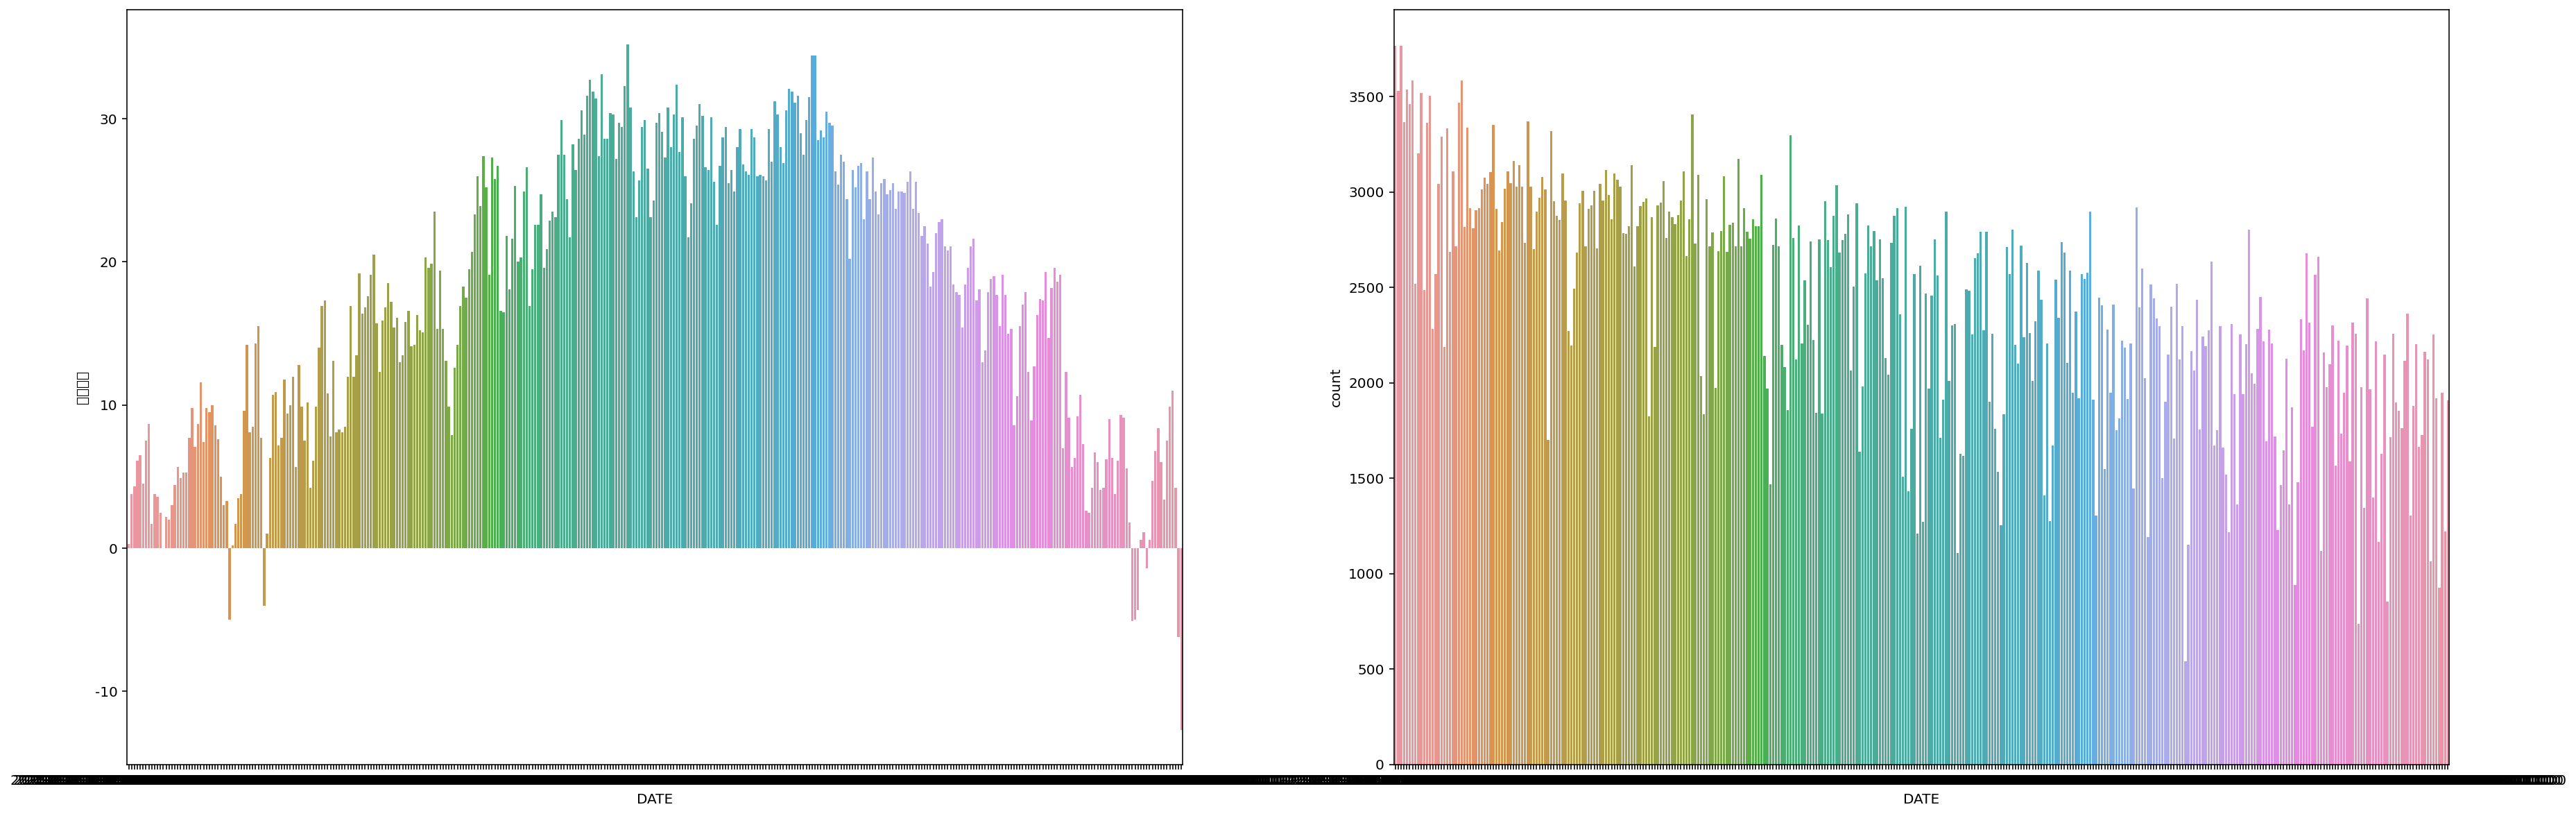

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=dailyweather_df3, x='DATE', y='최고기온', ax=ax1)
sns.countplot(data=df, x='DATE', ax=ax2)

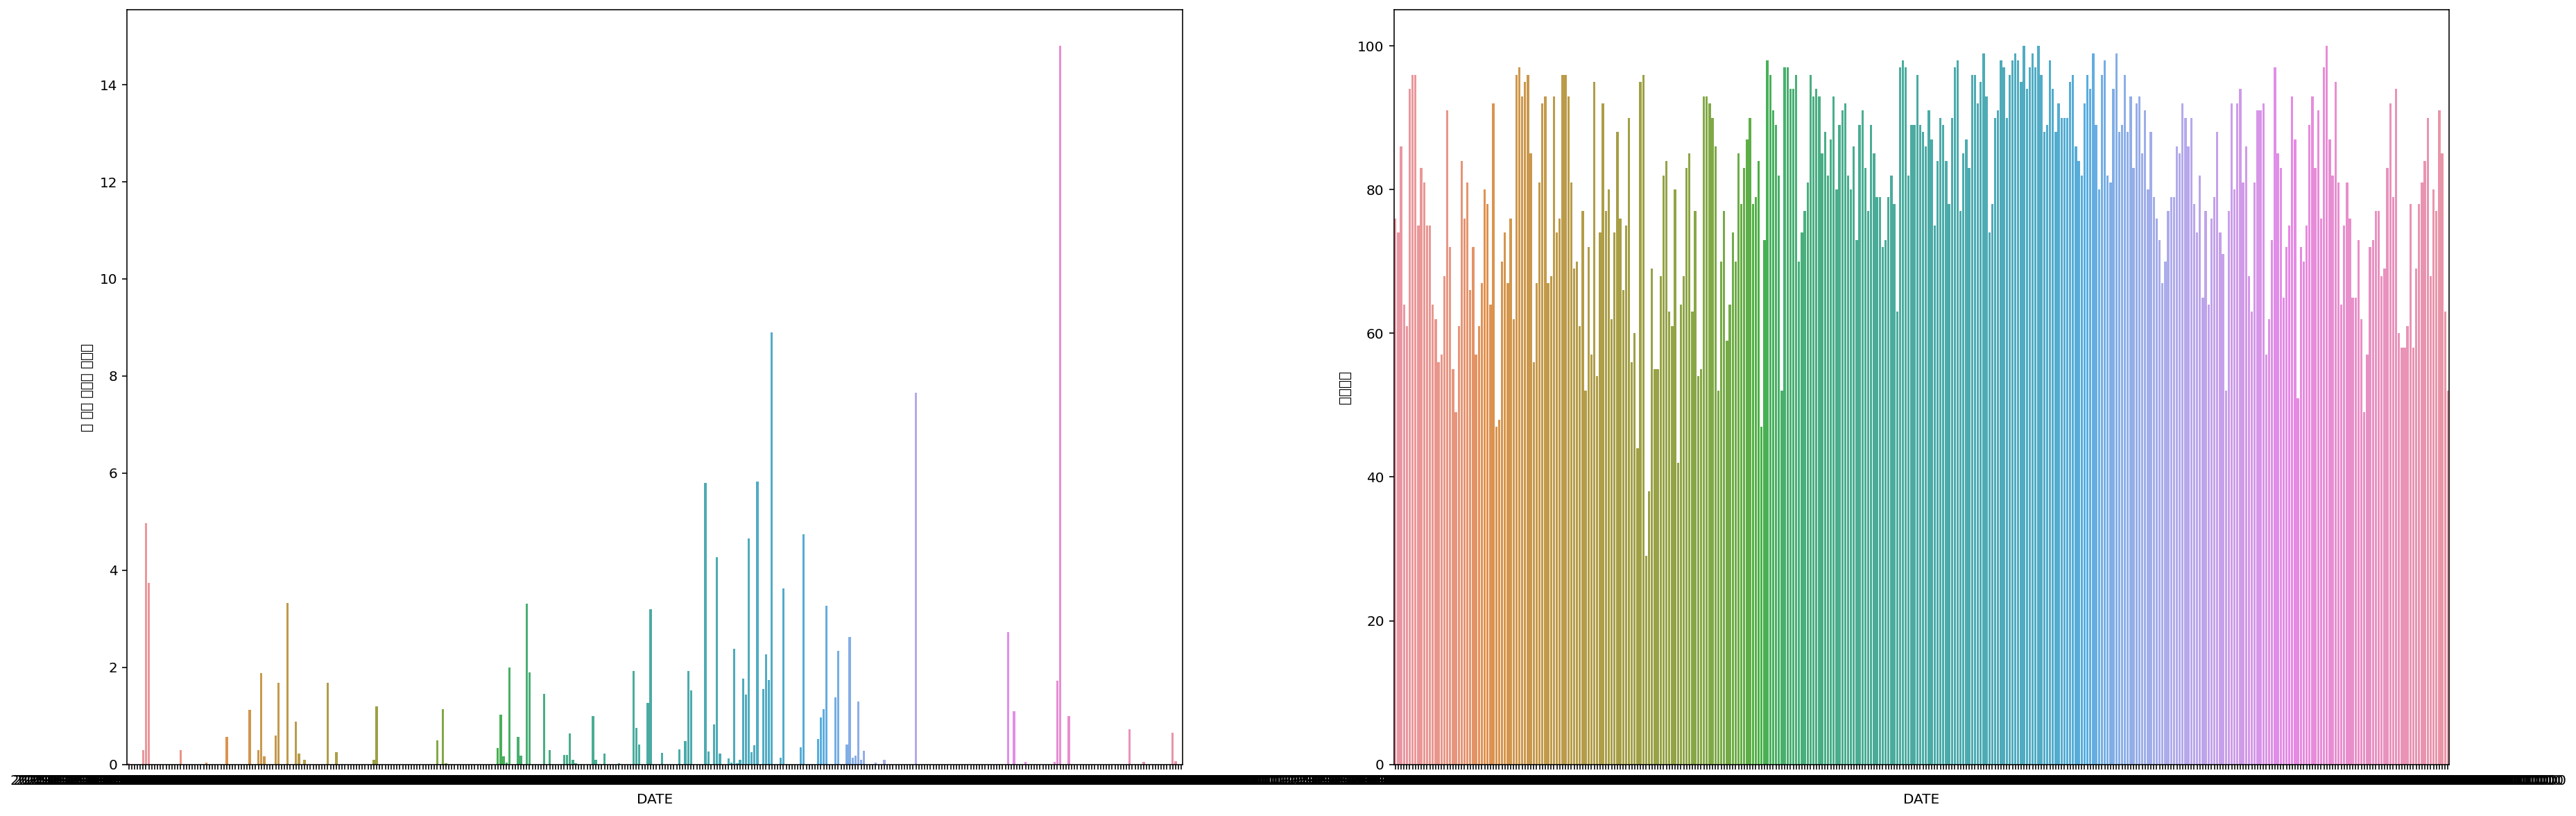

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=dailyweather_df3, x='DATE', y='일 평균 시간당 강수량', ax=ax1)
sns.barplot(data=dailyweather_df3, x='DATE', y='최고습도', ax=ax2)

### 교통량 데이터

In [ ]:
traffic.head()

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,5시,6시,7시,8시,9시,10시,11시,12시,13시,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,338.0,504.0,574.0,853.0,826.0,1051.0,1302.0,1362.0,1376.0,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,716.0,1561.0,2530.0,2524.0,2092.0,1904.0,1850.0,1730.0,1722.0,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,681.0,1385.0,2323.0,2544.0,2115.0,2018.0,2014.0,1693.0,1707.0,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,492.0,798.0,970.0,1369.0,1639.0,1828.0,2025.0,1899.0,1876.0,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,302.0,525.0,731.0,1098.0,1434.0,1578.0,1567.0,1605.0,1679.0,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [ ]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [ ]:
traffic.mean()

0시      738.555232
1시      529.370240
2시      395.721237
3시      334.523598
4시      414.291155
5시      834.110109
6시     1428.291456
7시     1802.420870
8시     1936.528719
9시     1941.244034
10시    1938.276676
11시    1934.119175
12시    1905.291136
13시    1967.721162
14시    1993.541210
15시    2016.848641
16시    2063.231722
17시    2084.878621
18시    1993.774096
19시    1806.331019
20시    1654.021262
21시    1578.728633
22시    1341.815713
23시    1004.166438
dtype: float64

교통량은 오전 8시부터 저녁 6시까지 많은 편

In [ ]:
traffic.isnull().sum()
non_list = list(set(np.where(traffic.isnull())[0]))
non_traffic = traffic[traffic.index.isin(non_list)]
len(non_traffic.지점명.unique())
traffic.dropna(how='any')
traffic

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,5시,6시,7시,8시,9시,10시,11시,12시,13시,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,338.0,504.0,574.0,853.0,826.0,1051.0,1302.0,1362.0,1376.0,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,716.0,1561.0,2530.0,2524.0,2092.0,1904.0,1850.0,1730.0,1722.0,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,681.0,1385.0,2323.0,2544.0,2115.0,2018.0,2014.0,1693.0,1707.0,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,492.0,798.0,970.0,1369.0,1639.0,1828.0,2025.0,1899.0,1876.0,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,302.0,525.0,731.0,1098.0,1434.0,1578.0,1567.0,1605.0,1679.0,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교,1310.0,804.0,582.0,473.0,488.0,745.0,1224.0,1472.0,1833.0,2308.0,2913.0,3106.0,3086.0,2961.0,3026.0,2957.0,2799.0,2858.0,2805.0,3031.0,3173.0,2928.0,2278.0,1559.0
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교,1030.0,614.0,501.0,565.0,1160.0,2515.0,2908.0,2219.0,1965.0,2386.0,2795.0,2820.0,2960.0,2984.0,2925.0,2595.0,2705.0,2264.0,2272.0,2954.0,3081.0,3099.0,2521.0,1837.0
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교,1294.0,833.0,582.0,597.0,900.0,2236.0,3135.0,2376.0,1952.0,2665.0,2850.0,2832.0,2828.0,2814.0,2634.0,2851.0,2704.0,2163.0,2165.0,2738.0,3054.0,3078.0,2544.0,1952.0
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교,1451.0,929.0,616.0,591.0,929.0,2067.0,3099.0,2509.0,2018.0,2459.0,3010.0,3296.0,2806.0,2818.0,2901.0,2636.0,2175.0,2036.0,1969.0,2787.0,3058.0,2936.0,2730.0,2160.0


In [ ]:
traffic['일 평균 교통량'] = traffic.loc[:, "0시":'23시'].mean(axis=1)
mean_traffic = traffic.groupby('DATE')['일 평균 교통량'].mean().reset_index()
mean_traffic

,DATE,일 평균 교통량
0,2020-01-01,1190.898206
1,2020-01-02,1512.705932
2,2020-01-03,1608.532497
3,2020-01-04,1476.214802
4,2020-01-05,1260.954808
...,...,...
361,2020-12-27,999.324239
362,2020-12-28,1484.316884
363,2020-12-29,1495.891649
364,2020-12-30,1480.773536


In [ ]:
ex_df = pd.merge(dailyweather_df3, mean_traffic, how = 'outer', on='DATE')
ex_df

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도,일 평균 교통량
0,2020-01-01,0.3,0.025000,-5.9,76,1190.898206
1,2020-01-02,3.8,NaN,-0.7,74,1512.705932
2,2020-01-03,4.3,NaN,-3.3,86,1608.532497
3,2020-01-04,6.1,NaN,-2.7,64,1476.214802
4,2020-01-05,6.5,NaN,-3.1,61,1260.954808
...,...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77,999.324239
362,2020-12-28,11.0,0.650000,4.3,91,1484.316884
363,2020-12-29,4.2,0.066667,-5.5,85,1495.891649
364,2020-12-30,-6.2,NaN,-12.9,63,1480.773536


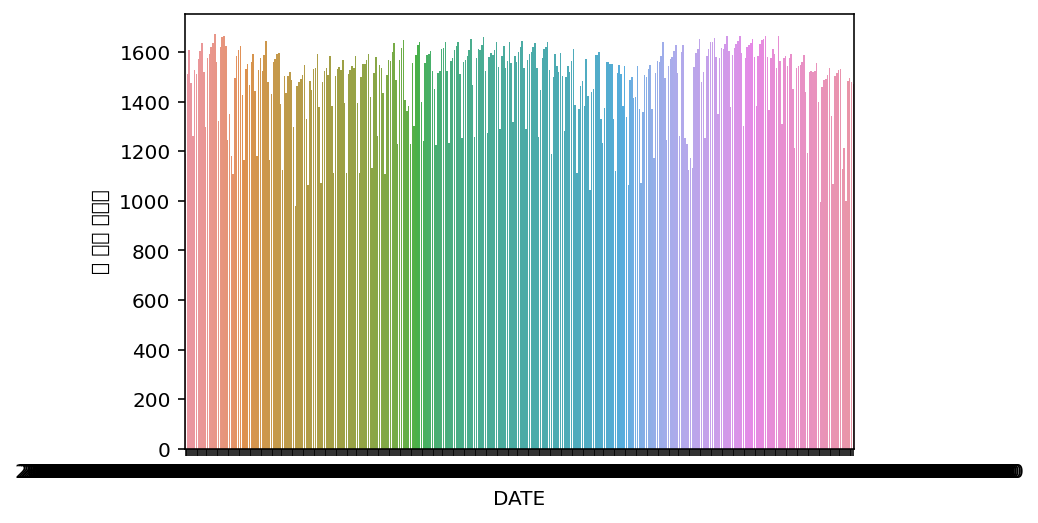

In [ ]:
sns.barplot(data=ex_df,y='일 평균 교통량', x= 'DATE')

In [ ]:
ex_df

,DATE,최고기온,일 평균 시간당 강수량,최저기온,최고습도,일 평균 교통량
0,2020-01-01,0.3,0.025000,-5.9,76,1190.898206
1,2020-01-02,3.8,NaN,-0.7,74,1512.705932
2,2020-01-03,4.3,NaN,-3.3,86,1608.532497
3,2020-01-04,6.1,NaN,-2.7,64,1476.214802
4,2020-01-05,6.5,NaN,-3.1,61,1260.954808
...,...,...,...,...,...,...
361,2020-12-27,9.9,0.000000,1.4,77,999.324239
362,2020-12-28,11.0,0.650000,4.3,91,1484.316884
363,2020-12-29,4.2,0.066667,-5.5,85,1495.891649
364,2020-12-30,-6.2,NaN,-12.9,63,1480.773536


In [ ]:
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE,is_weekend,is_holiday,DAY
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN,5,11,45,7919,mvp,1,0,5
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR,4,11,46,7919,mvp,0,0,4
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR,5,11,46,7919,mvp,1,0,5
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB,4,11,45,7919,mvp,0,0,4
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO,3,11,47,7919,mvp,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,AA,27996,A,2020-05-27,1,J,2,5,22,47,vip,0,0,2
295495,1579168,2020-05-26,AA,104916,A,2020-05-27,1,GN,2,5,22,1,new,0,0,2
295496,1579173,2020-05-26,AA,93362,A,2020-05-27,1,CY,2,5,22,44,vip,0,0,2
295497,1579174,2020-05-26,BB,221017,A,2020-05-27,1,YD,2,5,22,7,gold,0,0,2


### 데이터 통합

In [ ]:
data = pd.merge(df, ex_df, how='outer', on='DATE')
data = data.sort_values(['COUNT'], ascending=False)
data.rename(columns={"DATE":'날짜'}, inplace=True)
data = data.fillna(0)
data = data[['날짜','USER_ID','GRADE', 'AD1','STORE_ID', 'GOODS_TYPE', '최고기온','일 평균 시간당 강수량', '최고습도', '일 평균 교통량','COUNT_SUM', 'COUNT']]

In [ ]:
data

,날짜,USER_ID,GRADE,AD1,STORE_ID,GOODS_TYPE,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT
0,2020-11-07,999665,mvp,GN,96266,A,17.9,0.05,93,1581.016477,7919,61
3765,2020-11-13,999665,mvp,JRR,109677,A,17.3,0.00,89,1666.509256,7919,59
7294,2020-11-14,999665,mvp,JRR,1109,A,19.3,0.00,93,1580.947900,7919,58
11059,2020-11-06,999665,mvp,SB,190055,A,17.0,0.00,75,1654.971858,7919,55
14425,2020-11-19,999665,mvp,YO,131081,A,19.1,14.80,100,1535.027552,7919,53
...,...,...,...,...,...,...,...,...,...,...,...,...
295907,2020-10-21,1554852,silver,JRR,82400,B,17.3,0.00,81,1614.549383,3,1
295908,2020-10-21,1555178,gold,J,220893,B,17.3,0.00,81,1614.549383,12,1
295909,2020-10-21,1555305,gold,GN,221045,A,17.3,0.00,81,1614.549383,14,1
295910,2020-10-21,1555428,mvp,J,92505,A,17.3,0.00,81,1614.549383,146,1


In [ ]:
df[df['D_TYPE']==2].count()
df[df['is_weekend']==1].count()
df.query('GOODS_TYPE == 0 and is_weekend == 0') # 443327
df.query('GOODS_TYPE == 1 and is_weekend == 0') # 109883
df.query('GOODS_TYPE == 2 and is_weekend == 0') # 90606
df.query('GOODS_TYPE == 3 and is_weekend == 0') # 90606

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,day,month,week,COUNT_SUM,GRADE,is_weekend,is_holiday,DAY


## 데이터 모델링

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 30 kB/s 


### 라이브러리 임포트

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


### 데이터 전처리


In [ ]:
# 범주형 데이터 One_hot_encoding
data = pd.get_dummies(data, columns=['GRADE','AD1','GOODS_TYPE'])

### training & test set 분류

In [ ]:
#training set & test set 분류
# training data set(2020-01~2020-09), test data set(2020-10~2020-12)
train = data[data['날짜'] <= '2020-09-30']
test = data[data['날짜'] > '2020-09-30']
display(train, test)

,날짜,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,GRADE_gold,GRADE_mvp,GRADE_new,GRADE_silver,GRADE_vip,GRADE_vvip,AD1_0,AD1_ABP,AD1_ADS,AD1_AOI,AD1_BF,AD1_BHW,AD1_BI,AD1_BJG,AD1_BO,AD1_BOI,AD1_BP,AD1_BUD,AD1_CAS,AD1_CCA,AD1_CD,AD1_CN,AD1_COI,AD1_CU,AD1_CVB,AD1_CY,AD1_DB,AD1_DIV,AD1_DJ,AD1_DM,AD1_DOI,...,AD1_IYS,AD1_J,AD1_JR,AD1_JRR,AD1_MP,AD1_NO,AD1_NW,AD1_P,AD1_PJP,AD1_Q,AD1_QGI,AD1_QH,AD1_R,AD1_RRR,AD1_SB,AD1_SC,AD1_SD,AD1_SDU,AD1_SG,AD1_SJV,AD1_SOD,AD1_SOI,AD1_SP,AD1_VO,AD1_VU,AD1_WAE,AD1_WF,AD1_WH,AD1_WOID,AD1_WT,AD1_X,AD1_YC,AD1_YD,AD1_YO,AD1_ZE,AD1_ZP,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
34250,2020-08-15,999665,2428,26.9,3.631579,98,1330.054582,7919,49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
90644,2020-09-19,999665,90542,25.8,0.100000,88,1495.684009,7919,39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87739,2020-06-27,999665,2058,29.4,0.000000,82,1556.576350,7919,39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
93560,2020-09-24,999665,223666,24.9,0.000000,70,1606.697376,7919,39,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
102688,2020-09-26,999665,220959,24.8,0.000000,79,1516.472743,7919,38,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295001,2020-09-21,1531507,220959,25.0,0.000000,76,1543.107728,97,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
295002,2020-09-21,1528273,228946,25.0,0.000000,76,1543.107728,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
295003,2020-09-21,1528098,158176,25.0,0.000000,76,1543.107728,151,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
295004,2020-09-21,1528028,182320,25.0,0.000000,76,1543.107728,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


,날짜,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,COUNT_SUM,COUNT,GRADE_gold,GRADE_mvp,GRADE_new,GRADE_silver,GRADE_vip,GRADE_vvip,AD1_0,AD1_ABP,AD1_ADS,AD1_AOI,AD1_BF,AD1_BHW,AD1_BI,AD1_BJG,AD1_BO,AD1_BOI,AD1_BP,AD1_BUD,AD1_CAS,AD1_CCA,AD1_CD,AD1_CN,AD1_COI,AD1_CU,AD1_CVB,AD1_CY,AD1_DB,AD1_DIV,AD1_DJ,AD1_DM,AD1_DOI,...,AD1_IYS,AD1_J,AD1_JR,AD1_JRR,AD1_MP,AD1_NO,AD1_NW,AD1_P,AD1_PJP,AD1_Q,AD1_QGI,AD1_QH,AD1_R,AD1_RRR,AD1_SB,AD1_SC,AD1_SD,AD1_SDU,AD1_SG,AD1_SJV,AD1_SOD,AD1_SOI,AD1_SP,AD1_VO,AD1_VU,AD1_WAE,AD1_WF,AD1_WH,AD1_WOID,AD1_WT,AD1_X,AD1_YC,AD1_YD,AD1_YO,AD1_ZE,AD1_ZP,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
0,2020-11-07,999665,96266,17.9,0.05,93,1581.016477,7919,61,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3765,2020-11-13,999665,109677,17.3,0.00,89,1666.509256,7919,59,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7294,2020-11-14,999665,1109,19.3,0.00,93,1580.947900,7919,58,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11059,2020-11-06,999665,190055,17.0,0.00,75,1654.971858,7919,55,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14425,2020-11-19,999665,131081,19.1,14.80,100,1535.027552,7919,53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295906,2020-10-21,1554739,222221,17.3,0.00,81,1614.549383,64,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
295907,2020-10-21,1554852,82400,17.3,0.00,81,1614.549383,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
295908,2020-10-21,1555178,220893,17.3,0.00,81,1614.549383,12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
295909,2020-10-21,1555305,221045,17.3,0.00,81,1614.549383,14,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# train = train[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
#        'COUNT_SUM', 'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
#        'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
#        'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
#        'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
#        'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
#        'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
#        'GOODS_TYPE_D','COUNT']]
# test = test[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
#        'COUNT_SUM', 'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
#        'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
#        'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
#        'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
#        'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
#        'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
#        'GOODS_TYPE_D','COUNT']]

In [ ]:
### count 를 예측 하는데, count_sum 이 있으면 안될 거 같음.
train = train[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
       'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
       'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
       'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
       'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
       'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
       'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
       'GOODS_TYPE_D','COUNT']]
test = test[['날짜', 'USER_ID', 'STORE_ID', '최고기온', '일 평균 시간당 강수량', '최고습도', '일 평균 교통량',
       'GRADE_gold', 'GRADE_mvp', 'GRADE_new',
       'GRADE_silver', 'GRADE_vip', 'GRADE_vvip', 'AD1_DB', 'AD1_DJ', 'AD1_DM',
       'AD1_EP', 'AD1_GB', 'AD1_GD', 'AD1_GHN', 'AD1_GJ', 'AD1_GN', 'AD1_GR',
       'AD1_GS', 'AD1_GW', 'AD1_J', 'AD1_JR', 'AD1_JRR', 'AD1_MP', 'AD1_NW',
       'AD1_SB', 'AD1_SC', 'AD1_SD', 'AD1_SOD', 'AD1_SP', 'AD1_YC', 'AD1_YD',
       'AD1_YO', 'GOODS_TYPE_A', 'GOODS_TYPE_B', 'GOODS_TYPE_C',
       'GOODS_TYPE_D','COUNT']]

In [ ]:
train.iloc[0:566133, 1:42]
# train.iloc[0:566133, [-1]]

,USER_ID,STORE_ID,최고기온,일 평균 시간당 강수량,최고습도,일 평균 교통량,GRADE_gold,GRADE_mvp,GRADE_new,GRADE_silver,GRADE_vip,GRADE_vvip,AD1_DB,AD1_DJ,AD1_DM,AD1_EP,AD1_GB,AD1_GD,AD1_GHN,AD1_GJ,AD1_GN,AD1_GR,AD1_GS,AD1_GW,AD1_J,AD1_JR,AD1_JRR,AD1_MP,AD1_NW,AD1_SB,AD1_SC,AD1_SD,AD1_SOD,AD1_SP,AD1_YC,AD1_YD,AD1_YO,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D
34250,999665,2428,26.9,3.631579,98,1330.054582,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
90644,999665,90542,25.8,0.100000,88,1495.684009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87739,999665,2058,29.4,0.000000,82,1556.576350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
93560,999665,223666,24.9,0.000000,70,1606.697376,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
102688,999665,220959,24.8,0.000000,79,1516.472743,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406617,591610,28018,30.6,0.000000,82,1469.506967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
406618,592024,220655,30.6,0.000000,82,1469.506967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
406619,592273,82403,30.6,0.000000,82,1469.506967,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
406620,595300,109421,30.6,0.000000,82,1469.506967,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
print(train.shape, test.shape)

(623579, 43) (255692, 43)


In [ ]:

# x_train = train.iloc[0:566133, 1:43].values
# y_train = train.iloc[0:566133, [-1]].values

# x_train = np.array(x_train, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
# print(x_train.shape, y_train.shape)

# x_test = test.iloc[0:232371, 1:43].values
# y_test = test.iloc[0:232371, [-1]].values

# x_test = np.array(x_test, dtype=np.float32)
# y_test = np.array(y_test, dtype=np.float32)
# print(x_test.shape, y_test.shape)

In [ ]:

x_train = train.iloc[0:566133, 1:42].values
y_train = train.iloc[0:566133, [-1]].values

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
print(x_train.shape, y_train.shape)

x_test = test.iloc[0:232371, 1:42].values
y_test = test.iloc[0:232371, [-1]].values

x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
print(x_test.shape, y_test.shape)

(566133, 41) (566133, 1)
(232371, 41) (232371, 1)


### 데이터 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
# 각 모델별 MSE 값 확인 (디폴트 설정)
np.random.seed(42)

gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()
catboost = CatBoostRegressor()
models = [gboost, xgboost, lightgbm, rdforest, catboost]

In [ ]:
def performance(models1, x_train, y_train, x_test):
    df2 = {}

    for model in models:      
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print("사용한 모델 :",model)
        print("MSE :",mean_squared_error(y_test, y_pred))
        print("MAE :",mean_absolute_error(y_test, y_pred))
        print()
        print()

In [ ]:
performance(models, x_train, y_train, x_test)

사용한 모델 : GradientBoostingRegressor()
MSE : 0.5125579101490338
MAE : 0.07119260995530749


[02:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
사용한 모델 : XGBRegressor()
MSE : 0.51315135
MAE : 0.0741353


사용한 모델 : LGBMRegressor()
MSE : 0.6023217950465259
MAE : 0.11182825677832799


사용한 모델 : RandomForestRegressor()
MSE : 0.5348643415056096
MAE : 0.12634360569950642


Learning rate set to 0.12062
0:	learn: 0.4172056	total: 139ms	remaining: 2m 18s
1:	learn: 0.3938735	total: 213ms	remaining: 1m 46s
2:	learn: 0.3747647	total: 288ms	remaining: 1m 35s
3:	learn: 0.3592316	total: 366ms	remaining: 1m 31s
4:	learn: 0.3466931	total: 440ms	remaining: 1m 27s
5:	learn: 0.3366355	total: 529ms	remaining: 1m 27s
6:	learn: 0.3295914	total: 606ms	remaining: 1m 25s
7:	learn: 0.3272095	total: 673ms	remaining: 1m 23s
8:	learn: 0.3214653	total: 743ms	remaining: 1m 21s
9:	learn: 0.3144961	total: 819ms	remaining: 1m 21s
10:	learn: 0.3140552	

In [ ]:
# GradientBoostingRegressor 모델의 MSE, MAE값이 가장 낮음
# 모델의 가장 좋은 파라미터 찾기

# 파라미터 범위
param_grid = {
    'loss': ['huber', 'MSE', 'MAE'],
    'n_estimators': [100],
    'learning_rate' : [0.1],
    'criterion' : ['friedman_mse'],
    'max_depth' : [30]
}

# 모델 준비 (GradientBoostingRegressor)
model1 = GradientBoostingRegressor()

In [ ]:
# from sklearn.model_selectcion import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from scipy.stats import randint

# 이때 'kernel'이 'linear'일 경우 gamma값은 무시된다.
# param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=8), }
param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=6, high=41), }

# svm_reg = SVR()

# RandomizedSearchCV(모델명, param_distributions=하이퍼 파라미터 조정 범위,
#                    n_iter="탐색 횟수", cv="폴드 수", scoring"=평가방법",
#                    verbose="진행 상황 표시", random_state="시드")
rnd_search = RandomizedSearchCV(model1, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring="neg_mean_squared_error",
                                verbose=3, random_state=42)
rnd_search.fit(x_train, y_train)
print('Best params: ', rnd_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] max_features=34, n_estimators=15 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... max_features=34, n_estimators=15, score=-1.005, total=   0.4s
[CV] max_features=34, n_estimators=15 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ... max_features=34, n_estimators=15, score=-0.015, total=  17.1s
[CV] max_features=34, n_estimators=15 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV] ... max_features=34, n_estimators=15, score=-0.021, total=  16.8s
[CV] max_features=34, n_estimators=15 ................................
[CV] ... max_features=34, n_estimators=15, score=-0.036, total=  17.2s
[CV] max_features=34, n_estimators=15 ................................
[CV] ... max_features=34, n_estimators=15, score=-0.040, total=  16.4s
[CV] max_features=13, n_estimators=189 ...............................
[CV] .. max_features=13, n_estimators=189, score=-1.005, total=   3.1s
[CV] max_features=13, n_estimators=189 ...............................
[CV] .. max_features=13, n_estimators=189, score=-0.147, total= 1.3min
[CV] max_features=13, n_estimators=189 ...............................
[CV] .. max_features=13, n_estimators=189, score=-0.095, total= 1.4min
[CV] max_features=13, n_estimators=189 ...............................
[CV] .. max_features=13, n_estimators=189, score=-0.152, total= 1.4min
[CV] max_features=13, n_estimators=189 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 215.1min finished


Best params:  {'max_features': 9, 'n_estimators': 2}


### 가장 최적의 feature 값 : 9 , n_estimators :2

Best params:  {'max_features': 9, 'n_estimators': 2}

In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances


array([0.10095259, 0.        , 0.00187225, 0.        , 0.02284991,
       0.        , 0.02742303, 0.75518531, 0.07982292, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01189399, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [159]:
# 0, 2, 4,  6, 7, 8, 35
print(' Column : {} \t Feature Importance :{} '.format(train.columns[0], feature_importances[0]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[2], feature_importances[2]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[4], feature_importances[4]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[6], feature_importances[6]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[7], feature_importances[7]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[8], feature_importances[8]))
print(' Column : {} \t Feature Importance :{} '.format(train.columns[30], feature_importances[30]))

 Column : 날짜 	 Feature Importance :0.10095259344895173 
 Column : STORE_ID 	 Feature Importance :0.0018722469637244693 
 Column : 일 평균 시간당 강수량 	 Feature Importance :0.022849912051738225 
 Column : 일 평균 교통량 	 Feature Importance :0.02742302794869757 
 Column : GRADE_gold 	 Feature Importance :0.7551853078327768 
 Column : GRADE_mvp 	 Feature Importance :0.07982291723636616 
 Column : AD1_SB 	 Feature Importance :0.011893994517745017 


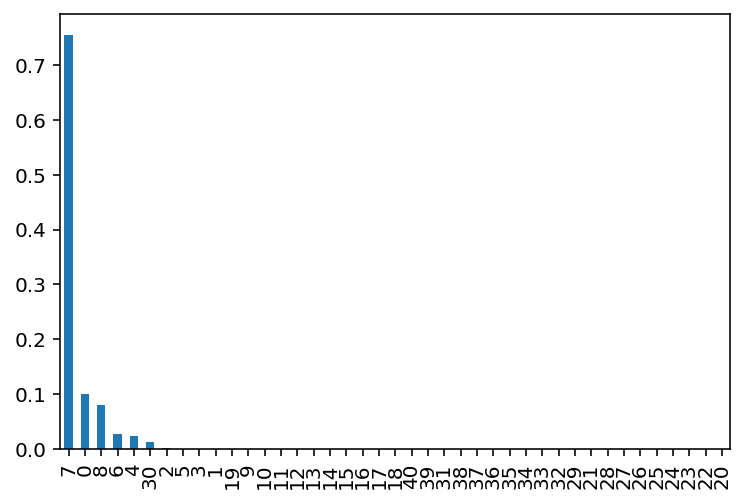

In [155]:
feature_list = pd.Series(feature_importances).sort_values(ascending=False)
feature_list.plot(kind='bar')
# feature_list

### Feature Importance 에서도 Grade_gold 가 가장 높으므로, 
### -> Gold 등급인 회원들을 위주로 하는 마케팅 전략이 주효할 것으로 예상됨.

In [ ]:
cvres = rnd_search.cv_results_ 
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
  print(np.sqrt(-mean_score), params)


0.472769224343533 {'max_features': 34, 'n_estimators': 15}
0.5855915737004642 {'max_features': 13, 'n_estimators': 189}
0.5681214656144242 {'max_features': 26, 'n_estimators': 103}
0.5330234195660519 {'max_features': 24, 'n_estimators': 75}
0.5199317685091661 {'max_features': 16, 'n_estimators': 88}
0.599831771171367 {'max_features': 29, 'n_estimators': 131}
0.5123452198389944 {'max_features': 27, 'n_estimators': 53}
0.5182547799294333 {'max_features': 7, 'n_estimators': 88}
0.5060338528726455 {'max_features': 35, 'n_estimators': 38}
0.5434185409071973 {'max_features': 7, 'n_estimators': 192}
0.6123871547895051 {'max_features': 26, 'n_estimators': 161}
0.5022035055979436 {'max_features': 17, 'n_estimators': 58}
0.5461395618013374 {'max_features': 27, 'n_estimators': 89}
0.5144312907900919 {'max_features': 32, 'n_estimators': 59}
0.6521931226128767 {'max_features': 33, 'n_estimators': 188}
0.4733725386175337 {'max_features': 21, 'n_estimators': 15}
0.5038049943011391 {'max_features': 8,

In [ ]:
model1=rnd_search.best_estimator_ 

In [ ]:
model1.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
y_pred1 = model1.predict(x_test)
y_pred1

array([1.04129793, 1.04129793, 1.04129793, ..., 1.0281452 , 1.0281452 ,
       1.0281452 ])

In [162]:
np.where(y_pred1 > 2)
### 2보다 큰 값은 없음.

(array([], dtype=int64),)

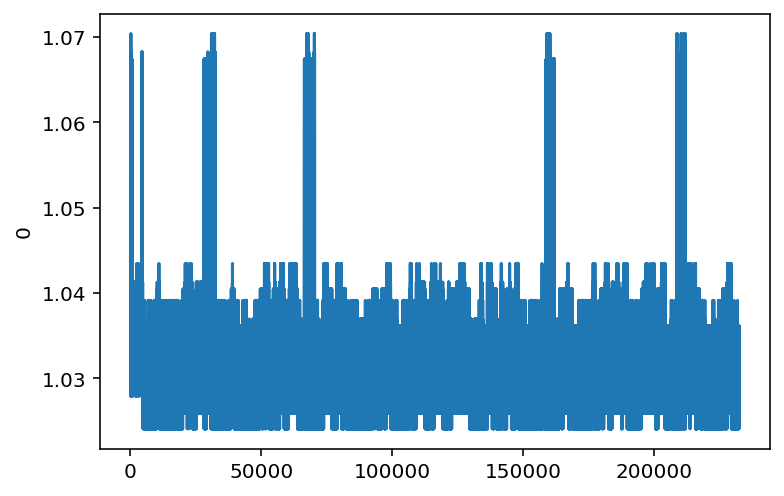

In [174]:
y_pred = pd.DataFrame(y_pred1)
y_pred
sns.lineplot(y=y_pred[0], x=y_pred.index)

### 결과적으로 Count 가 1인 값들이 많아서, 대부분의 값들이 1에 근접한 모습들을 볼 수 있음.
---

### 다만 이와는 별개로 Feature Importance 를 통해 본 결과 Gold 등급인 경우가 예측 결과에 많은 영향을 미치므로, Gold 등급 회원의 양이 많은 강남, 마포, 영등포 등의 지역의 결제비율이 높으므로 이 지역들을 공략할 필요가 있을 것으로 보인다.


In [ ]:
# MSE, MAE값
print("MSE :",mean_squared_error(y_test, y_pred1))
print("MAE :",mean_absolute_error(y_test, y_pred1))

MSE : 0.5055727494586608
MAE : 0.06561865566991788
